# Описание
В данной работе представлено исследование стоимости квартир (домов) в Тегеране, информацию о которых собрал потенциальный покупатель.

Данные содержат следующую информацию:
- Area – площадь жилья в квадратных метрах;
- Room – количество жилых комнат;
- Parking – наличие паркинга;
- Elevator – наличие лифта;
- Warehouse – наличие складского помещения;
- Address – район города;
- Price – цена в томанах; 
- Price(USD) – цена в долларах США.

**Этапы выполнения проекта**:

- Подготовка и анализ данных;
- Обучение нескольких моделей с подбором гиперпараметров;
- Анализ результатов.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import time
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv('housePrice.csv')

## Анализ данных

In [3]:
display(df.head())

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1.850000e+09,61666.67
1,60,1,True,True,True,Shahran,1.850000e+09,61666.67
2,79,2,True,True,True,Pardis,5.500000e+08,18333.33
3,95,2,True,True,True,Shahrake Qods,9.025000e+08,30083.33
4,123,2,True,True,True,Shahrake Gharb,7.000000e+09,233333.33


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   float64
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(2), int64(1), object(2)
memory usage: 146.2+ KB


In [5]:
df[df['Address'].isna() == True].head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
43,60,2,True,True,True,NaN,2.650000e+09,88333.33
662,85,2,True,True,True,NaN,1.955000e+09,65166.67
706,117,2,True,True,True,NaN,6.500000e+09,216666.67
1108,77,2,True,True,False,NaN,2.020000e+09,67333.33
1109,71,1,True,True,True,NaN,2.300000e+09,76666.67


В представленной таблице присутствуют пропуски в столце Address. Также стоит обратить внимание на столбец Area, тип которого вместо числового является строковым. В дальнейшем указанные недочеты будут исправлены.

In [6]:
df['Address'].nunique()

192

In [7]:
df["Area"] = pd.to_numeric(df["Area"], errors='coerce') 

In [8]:
df = df.dropna()

In [9]:
df[["Area",'Room','Price(USD)']].describe()

,Area,Room,Price(USD)
count,3450.000000,3450.000000,3.450000e+03
mean,106.917391,2.081159,1.791854e+05
std,69.550976,0.760216,2.708639e+05
min,30.000000,0.000000,1.200000e+02
25%,69.000000,2.000000,4.730833e+04
50%,90.000000,2.000000,9.666667e+04
75%,120.000000,2.000000,2.000000e+05
max,929.000000,5.000000,3.080000e+06


Из представленного описание можно заметить, что в данных могут присутствовать аномальные значения. Например, жилье с количеством комнат равным 0. Нет уточнения, это квартиры студии или нет.
Также привлекает внимание минимальная стоимость – 120 долларов.

In [10]:
df['Price(USD)_th'] = df['Price(USD)'] / 1000

Text(0.5, 1.0, 'House price')

<Figure size 700x400 with 0 Axes>

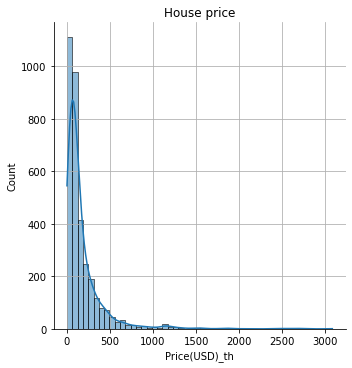

In [11]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Price(USD)_th'],kde=True,bins = 50)
plt.grid()
plt.title('House price')

In [12]:
df = df[(df['Price(USD)']<df['Price(USD)'].quantile(0.95)) & (df['Price(USD)']>df['Price(USD)'].quantile(0.05))]

Для удобства просмотра информации цена отображается в тысячах долларов. 
На гистограмме наблюдается длинный хвост в области низких цен. Для дальнейшего исследования отброшены по 5% самых дешевых и дорогих вариантов недвижимости, чтобы избежать краевых аномалий.

Text(0.5, 1.0, 'House price+')

<Figure size 700x400 with 0 Axes>

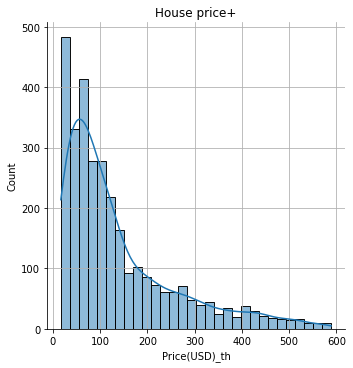

In [13]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Price(USD)_th'],kde=True,bins = 30)
plt.grid()
plt.title('House price+')

Text(0.5, 1.0, 'House area')

<Figure size 700x400 with 0 Axes>

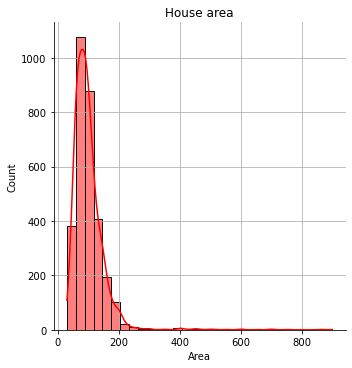

In [14]:
plt.figure(figsize=(7,4), dpi=100)
sns.displot(df['Area'],kde=True,bins = 30, color = 'r')
plt.grid()
plt.title('House area')

In [15]:
df = df[~((df['Area']>60) & (df['Room']<1))]

Из рассмотрения также удалены квартиры с количеством жилых комнат равным 0 при площади квартиры более 60 квадратных метров, так как данные объекты могут вносить дисбаланс при обучении модели.

In [16]:
df["Address"] = df["Address"].astype('category')
df_1 = pd.DataFrame(df.groupby('Address')['Price(USD)_th'].agg('median').sort_values())
df_1['C'] = np.arange(len(df_1))
df["Address"] = df["Address"].map(df_1['C'].to_dict())
df["Address"] = df["Address"].astype('int')
df["Address"]

0        99
1        99
2         7
3        21
4       173
       ... 
3472     65
3473     97
3474    106
3475    177
3477    174
Name: Address, Length: 3104, dtype: int32

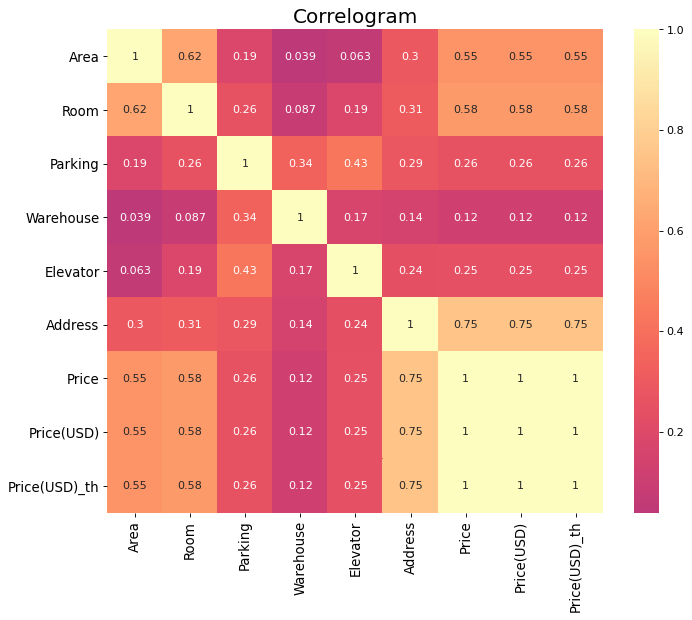

In [17]:
plt.figure(figsize=(10,8), dpi= 80)
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='magma', center=0, annot=True)
plt.title('Correlogram', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Данный график демонстрирует корреляцию между признаками и целевым признаком. Основная взаимосвязь стоимости наблюдается с площадью жилья и количеством комнат.
Корреляция района и стоимости наблюдается, так как при кодировании данного признака производилась сортировка по медианной стоимости жилья в каждом районе.

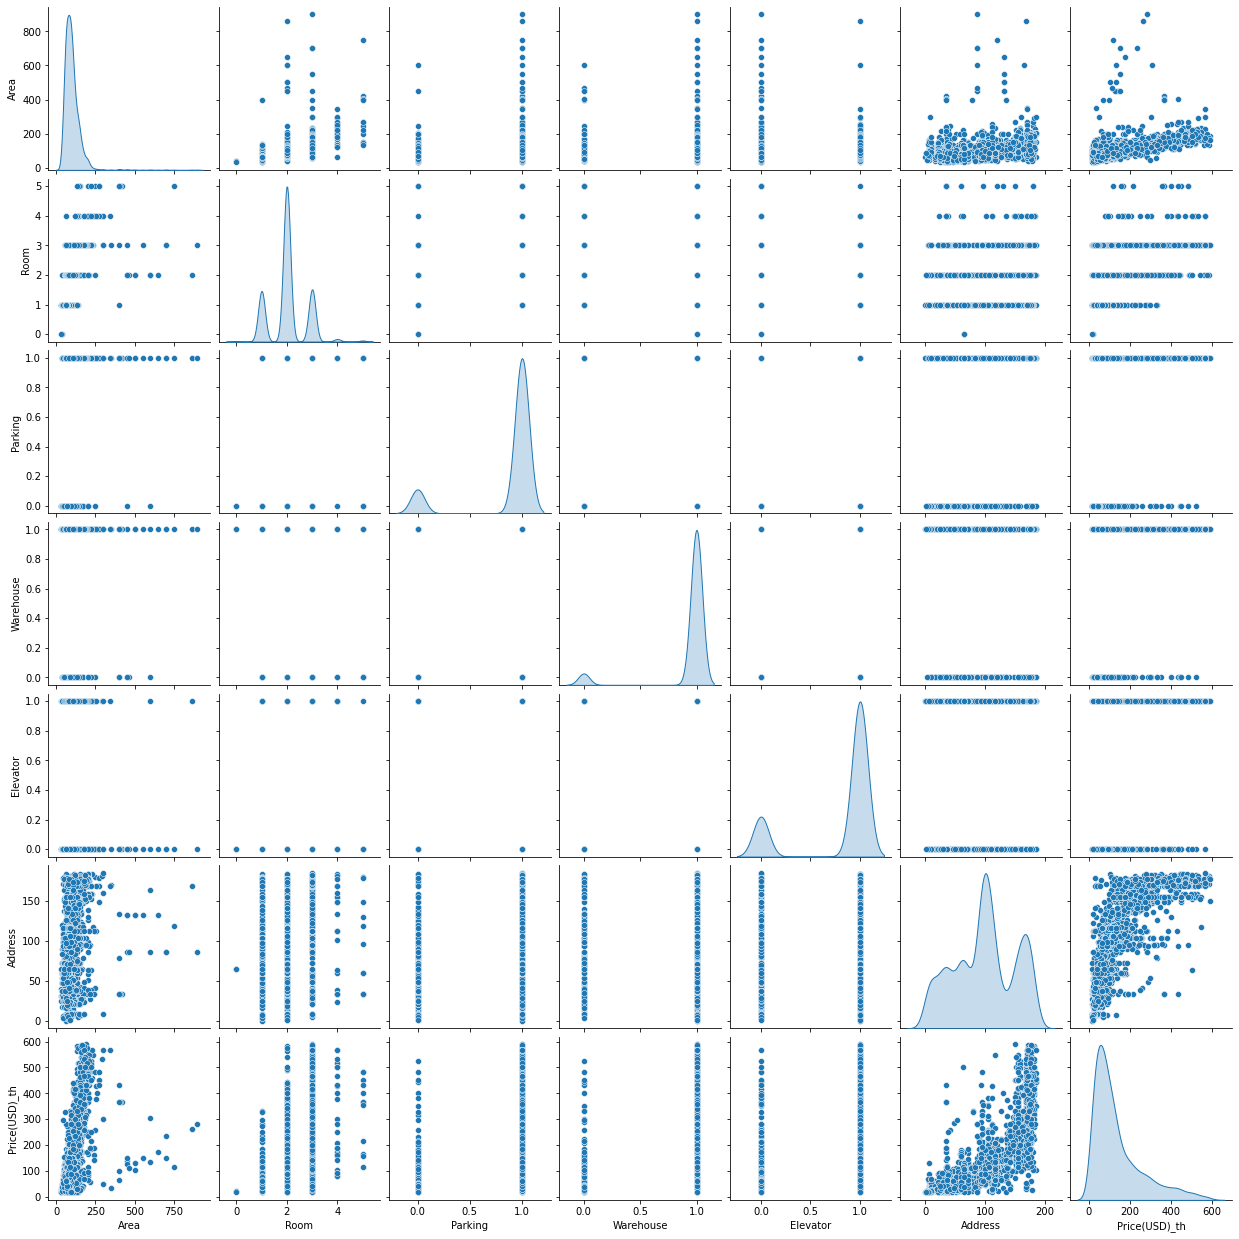

In [18]:
sns.pairplot(df[['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address',  'Price(USD)_th']], diag_kind='kde')

In [19]:
df[['Parking_str','Warehouse_str','Elevator_str']] =df[['Parking','Warehouse','Elevator']] .astype(str)
df[['Parking','Warehouse','Elevator']] = df[['Parking','Warehouse','Elevator']]*1

Text(0.5, 1.0, 'House price')

<Figure size 800x400 with 0 Axes>

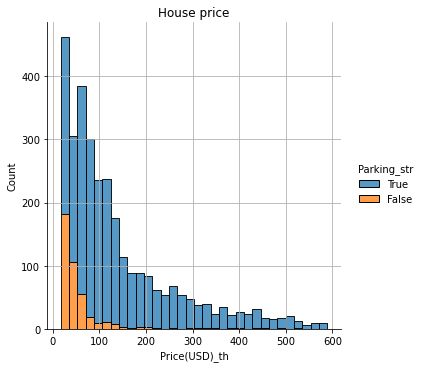

In [20]:
plt.figure(figsize=(8,4), dpi=100)
sns.displot(data=df, x="Price(USD)_th", hue="Parking_str", multiple="stack")
plt.grid()
plt.title('House price')

Text(0.5, 1.0, 'House price')

<Figure size 576x360 with 0 Axes>

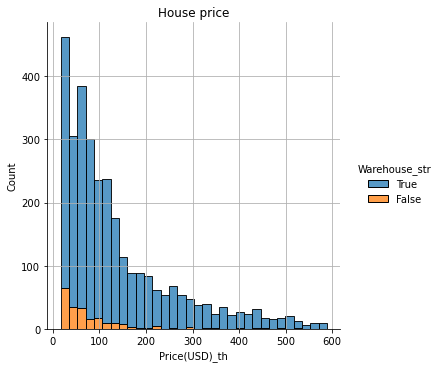

In [21]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x="Price(USD)_th", hue="Warehouse_str", multiple="stack")
plt.grid()
plt.title('House price')

Text(0.5, 1.0, 'House price')

<Figure size 576x360 with 0 Axes>

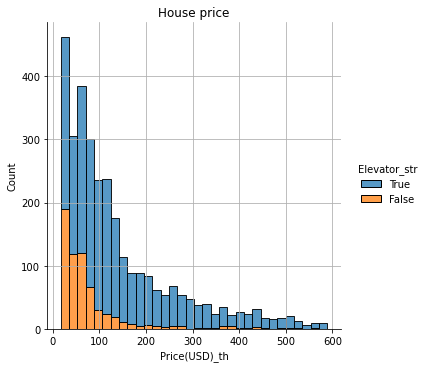

In [22]:
plt.figure(figsize=(8,5))
sns.displot(data=df, x="Price(USD)_th", hue="Elevator_str", multiple="stack")
plt.grid()
plt.title('House price')

Основная масса представленных вариантов жилой недвижимости имеет в  дополнении паркинг, складское помещение и лифт. Распределения по стоимости о всех видов жилья похожи.

## Подготовка данных для обучения моделей

In [23]:
numeric_cols = [name for name in df.columns if df[name].dtype in ['int64', 'int32','float']]
print(numeric_cols)

['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price', 'Price(USD)', 'Price(USD)_th']


In [24]:
X = df[numeric_cols].drop(['Price', 'Price(USD)', 'Price(USD)_th'], axis=1)
y = df['Price(USD)_th']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                                random_state=123456)

In [26]:
X_train.shape

(2483, 6)

In [27]:
X_test.shape

(621, 6)

In [28]:
def scal(data_1, data_2):
    """Масштабирование данных"""
    scaler = StandardScaler()
    scaler.fit(data_1)
    data_1 = scaler.transform(data_1)
    data_2 = scaler.transform(data_2)
    return data_1, data_2

In [29]:
def rmse(target, pred):
    """Создание метрики для применения ее в GridSearchCV """
    return (mean_squared_error(target, pred)**0.5)
my_score = make_scorer(rmse, greater_is_better=False)

In [30]:
def models(features, target, model_name, parameter):
    '''Подбор гиперпараметров'''
    start_time = datetime.now()
    model = GridSearchCV(model_name, parameter, refit=True, scoring = my_score, cv=5)
    best_model = model.fit(features,target)
    prediction = best_model.predict(features)
    end_time = datetime.now()
    time = end_time - start_time
    print(best_model.best_params_)
    print(best_model.best_score_)
    return best_model, prediction, best_model.best_params_, time

In [31]:
def predict_data(model,features_test, target_test):
    """Предсказание и измерение времени """
    start_time = datetime.now()
    pred_test = model.predict(features_test)
    end_time = datetime.now()
    time_predict = end_time - start_time
    rmse_test = rmse(target_test,pred_test)
    print('RMSE_test:',round(rmse_test,2))
    print('MAE_test:',round(mean_absolute_error(target_test,pred_test),2))
    print('R2_test:',round(r2_score(target_test,pred_test),2))
    print('time_predict:',time_predict)
    return rmse_test, time_predict, pred_test

Данные разбиты на обучающую и тестовую выборки. В дальнейшем подбор гиперпараметров и обучении моделей будет происходить с применением кросс-валидации. Также подготовлены функции.

## Обучение моделей

In [32]:
X_train_s, X_test_s = scal(X_train, X_test)

In [33]:

sgd = SGDRegressor()
params_sgd = {
    'loss': ['squared_loss', 'huber', 'epsilon_insensitive'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'learning_rate': ['constant', 'optimal', 'invscaling']
}

In [34]:
%%time
best_model_sgd, prediction_sgd, params_sgd, time_sgd = models(X_train_s, y_train, sgd, params_sgd)

{'learning_rate': 'invscaling', 'loss': 'squared_loss', 'penalty': 'elasticnet'}
-63.09827023950593
Wall time: 15.6 s


In [35]:
rmse_test_s, time_predict_s, pred_test_sgd = predict_data(best_model_sgd, X_test_s, y_test)

RMSE_test: 66.58
MAE_test: 46.88
R2_test: 0.72
time_predict: 0:00:00.001001


Результаты метрик RMSE(66 000) и  MAE(47000) для стохастического градиентного спуска достаточно велики, учитывая тот факт, что медианное значение цены - около 100 000 долларов. R2 равное 0,73, говорит о том, что взаимосвязь между признаками есть неплохая.

In [36]:
cbr = CatBoostRegressor()
params_cbr = {'depth': [7, 10, 20],
          'learning_rate' : [0.3, 1],
          'iterations': [2000]}

In [37]:
%%time
best_model_cbr, prediction_cbr, params_cbr, time_cbr = models(X_train_s, y_train, cbr, params_cbr)

0:	learn: 91.9736545	total: 59.3ms	remaining: 1m 58s
1:	learn: 73.6644877	total: 63.6ms	remaining: 1m 3s
2:	learn: 61.7684997	total: 67.9ms	remaining: 45.2s
3:	learn: 54.5719911	total: 72.1ms	remaining: 36s
4:	learn: 49.4680144	total: 76.3ms	remaining: 30.5s
5:	learn: 46.2563414	total: 80.8ms	remaining: 26.8s
6:	learn: 44.4908767	total: 82.9ms	remaining: 23.6s
7:	learn: 43.4254201	total: 87.1ms	remaining: 21.7s
8:	learn: 42.5048863	total: 91.4ms	remaining: 20.2s
9:	learn: 41.6286462	total: 95.5ms	remaining: 19s
10:	learn: 41.1448036	total: 99.7ms	remaining: 18s
11:	learn: 40.5057080	total: 104ms	remaining: 17.2s
12:	learn: 39.8635018	total: 110ms	remaining: 16.9s
13:	learn: 39.4330500	total: 114ms	remaining: 16.2s
14:	learn: 39.3400989	total: 117ms	remaining: 15.5s
15:	learn: 39.1412379	total: 121ms	remaining: 15.1s
16:	learn: 38.9239857	total: 126ms	remaining: 14.7s
17:	learn: 38.6963743	total: 130ms	remaining: 14.3s
18:	learn: 38.3264096	total: 134ms	remaining: 14s
19:	learn: 38.0607

158:	learn: 24.5913143	total: 857ms	remaining: 9.92s
159:	learn: 24.5432660	total: 861ms	remaining: 9.9s
160:	learn: 24.4856227	total: 867ms	remaining: 9.9s
161:	learn: 24.4619538	total: 871ms	remaining: 9.88s
162:	learn: 24.4265118	total: 891ms	remaining: 10s
163:	learn: 24.3910457	total: 896ms	remaining: 10s
164:	learn: 24.3823914	total: 901ms	remaining: 10s
165:	learn: 24.3604947	total: 905ms	remaining: 10s
166:	learn: 24.3270709	total: 911ms	remaining: 10s
167:	learn: 24.2667801	total: 915ms	remaining: 9.98s
168:	learn: 24.2618789	total: 919ms	remaining: 9.96s
169:	learn: 24.1710240	total: 924ms	remaining: 9.95s
170:	learn: 24.1692523	total: 928ms	remaining: 9.92s
171:	learn: 24.1172986	total: 932ms	remaining: 9.9s
172:	learn: 24.0379354	total: 936ms	remaining: 9.88s
173:	learn: 23.9723313	total: 940ms	remaining: 9.87s
174:	learn: 23.8673670	total: 945ms	remaining: 9.85s
175:	learn: 23.8428694	total: 949ms	remaining: 9.83s
176:	learn: 23.8246521	total: 954ms	remaining: 9.82s
177:	l

327:	learn: 20.1377262	total: 1.65s	remaining: 8.42s
328:	learn: 20.1081469	total: 1.66s	remaining: 8.41s
329:	learn: 20.1017700	total: 1.66s	remaining: 8.4s
330:	learn: 20.0892278	total: 1.67s	remaining: 8.4s
331:	learn: 20.0725215	total: 1.68s	remaining: 8.44s
332:	learn: 20.0548031	total: 1.68s	remaining: 8.43s
333:	learn: 20.0365877	total: 1.69s	remaining: 8.42s
334:	learn: 20.0160806	total: 1.69s	remaining: 8.41s
335:	learn: 19.9906056	total: 1.7s	remaining: 8.4s
336:	learn: 19.9749095	total: 1.7s	remaining: 8.39s
337:	learn: 19.9665051	total: 1.7s	remaining: 8.38s
338:	learn: 19.9368416	total: 1.71s	remaining: 8.37s
339:	learn: 19.9007002	total: 1.71s	remaining: 8.36s
340:	learn: 19.8905667	total: 1.72s	remaining: 8.36s
341:	learn: 19.8836584	total: 1.72s	remaining: 8.35s
342:	learn: 19.8827615	total: 1.73s	remaining: 8.34s
343:	learn: 19.8345216	total: 1.73s	remaining: 8.33s
344:	learn: 19.8253260	total: 1.73s	remaining: 8.32s
345:	learn: 19.8120559	total: 1.74s	remaining: 8.31s

499:	learn: 18.0435650	total: 2.46s	remaining: 7.37s
500:	learn: 18.0351909	total: 2.46s	remaining: 7.36s
501:	learn: 18.0189276	total: 2.48s	remaining: 7.39s
502:	learn: 18.0186639	total: 2.48s	remaining: 7.4s
503:	learn: 18.0159178	total: 2.49s	remaining: 7.39s
504:	learn: 18.0024669	total: 2.49s	remaining: 7.38s
505:	learn: 17.9925126	total: 2.5s	remaining: 7.38s
506:	learn: 17.9792867	total: 2.5s	remaining: 7.37s
507:	learn: 17.9792106	total: 2.51s	remaining: 7.36s
508:	learn: 17.9683184	total: 2.51s	remaining: 7.36s
509:	learn: 17.9643078	total: 2.52s	remaining: 7.35s
510:	learn: 17.9478086	total: 2.52s	remaining: 7.34s
511:	learn: 17.9218309	total: 2.52s	remaining: 7.33s
512:	learn: 17.9175396	total: 2.53s	remaining: 7.33s
513:	learn: 17.9119779	total: 2.53s	remaining: 7.32s
514:	learn: 17.8800638	total: 2.54s	remaining: 7.32s
515:	learn: 17.8681773	total: 2.54s	remaining: 7.31s
516:	learn: 17.8623241	total: 2.54s	remaining: 7.3s
517:	learn: 17.8472854	total: 2.55s	remaining: 7.2

667:	learn: 16.7774844	total: 3.27s	remaining: 6.52s
668:	learn: 16.7716000	total: 3.27s	remaining: 6.51s
669:	learn: 16.7647644	total: 3.28s	remaining: 6.5s
670:	learn: 16.7529058	total: 3.28s	remaining: 6.5s
671:	learn: 16.7509358	total: 3.28s	remaining: 6.49s
672:	learn: 16.7332359	total: 3.3s	remaining: 6.5s
673:	learn: 16.7272258	total: 3.3s	remaining: 6.49s
674:	learn: 16.7167624	total: 3.3s	remaining: 6.49s
675:	learn: 16.7072765	total: 3.31s	remaining: 6.48s
676:	learn: 16.7035422	total: 3.31s	remaining: 6.48s
677:	learn: 16.7022682	total: 3.32s	remaining: 6.47s
678:	learn: 16.6993513	total: 3.33s	remaining: 6.47s
679:	learn: 16.6969706	total: 3.33s	remaining: 6.46s
680:	learn: 16.6913413	total: 3.33s	remaining: 6.46s
681:	learn: 16.6876680	total: 3.34s	remaining: 6.45s
682:	learn: 16.6874964	total: 3.34s	remaining: 6.44s
683:	learn: 16.6847468	total: 3.35s	remaining: 6.44s
684:	learn: 16.6772530	total: 3.35s	remaining: 6.43s
685:	learn: 16.6754016	total: 3.35s	remaining: 6.42s

831:	learn: 15.9835416	total: 4.05s	remaining: 5.69s
832:	learn: 15.9769359	total: 4.05s	remaining: 5.68s
833:	learn: 15.9735779	total: 4.06s	remaining: 5.68s
834:	learn: 15.9698827	total: 4.08s	remaining: 5.69s
835:	learn: 15.9664476	total: 4.08s	remaining: 5.68s
836:	learn: 15.9629065	total: 4.09s	remaining: 5.68s
837:	learn: 15.9621475	total: 4.1s	remaining: 5.68s
838:	learn: 15.9593825	total: 4.1s	remaining: 5.67s
839:	learn: 15.9580749	total: 4.11s	remaining: 5.67s
840:	learn: 15.9571748	total: 4.11s	remaining: 5.67s
841:	learn: 15.9496517	total: 4.12s	remaining: 5.66s
842:	learn: 15.9493531	total: 4.12s	remaining: 5.66s
843:	learn: 15.9453594	total: 4.13s	remaining: 5.65s
844:	learn: 15.9443600	total: 4.13s	remaining: 5.65s
845:	learn: 15.9409516	total: 4.14s	remaining: 5.65s
846:	learn: 15.9382208	total: 4.14s	remaining: 5.64s
847:	learn: 15.9327171	total: 4.15s	remaining: 5.64s
848:	learn: 15.9279909	total: 4.16s	remaining: 5.64s
849:	learn: 15.9243666	total: 4.16s	remaining: 5

991:	learn: 15.4516620	total: 4.85s	remaining: 4.93s
992:	learn: 15.4513965	total: 4.86s	remaining: 4.92s
993:	learn: 15.4511510	total: 4.86s	remaining: 4.92s
994:	learn: 15.4503379	total: 4.86s	remaining: 4.91s
995:	learn: 15.4499849	total: 4.87s	remaining: 4.91s
996:	learn: 15.4478886	total: 4.87s	remaining: 4.9s
997:	learn: 15.4475092	total: 4.88s	remaining: 4.9s
998:	learn: 15.4436739	total: 4.88s	remaining: 4.89s
999:	learn: 15.4415354	total: 4.88s	remaining: 4.88s
1000:	learn: 15.4389924	total: 4.89s	remaining: 4.88s
1001:	learn: 15.4377930	total: 4.89s	remaining: 4.88s
1002:	learn: 15.4348744	total: 4.9s	remaining: 4.87s
1003:	learn: 15.4335205	total: 4.9s	remaining: 4.86s
1004:	learn: 15.4296263	total: 4.91s	remaining: 4.86s
1005:	learn: 15.4283235	total: 4.91s	remaining: 4.85s
1006:	learn: 15.4243775	total: 4.92s	remaining: 4.85s
1007:	learn: 15.4236464	total: 4.92s	remaining: 4.84s
1008:	learn: 15.4233939	total: 4.92s	remaining: 4.84s
1009:	learn: 15.4192431	total: 4.93s	rema

1162:	learn: 15.0633260	total: 5.64s	remaining: 4.06s
1163:	learn: 15.0626530	total: 5.65s	remaining: 4.06s
1164:	learn: 15.0620417	total: 5.65s	remaining: 4.05s
1165:	learn: 15.0602978	total: 5.66s	remaining: 4.04s
1166:	learn: 15.0596863	total: 5.66s	remaining: 4.04s
1167:	learn: 15.0582000	total: 5.66s	remaining: 4.04s
1168:	learn: 15.0560694	total: 5.67s	remaining: 4.03s
1169:	learn: 15.0542997	total: 5.67s	remaining: 4.03s
1170:	learn: 15.0515275	total: 5.68s	remaining: 4.02s
1171:	learn: 15.0500023	total: 5.68s	remaining: 4.02s
1172:	learn: 15.0465520	total: 5.69s	remaining: 4.01s
1173:	learn: 15.0444545	total: 5.69s	remaining: 4s
1174:	learn: 15.0425169	total: 5.7s	remaining: 4s
1175:	learn: 15.0421961	total: 5.7s	remaining: 4s
1176:	learn: 15.0311442	total: 5.71s	remaining: 3.99s
1177:	learn: 15.0303032	total: 5.71s	remaining: 3.99s
1178:	learn: 15.0302799	total: 5.72s	remaining: 3.98s
1179:	learn: 15.0243477	total: 5.72s	remaining: 3.98s
1180:	learn: 15.0240799	total: 5.73s	re

1351:	learn: 14.7148424	total: 6.43s	remaining: 3.08s
1352:	learn: 14.7114523	total: 6.43s	remaining: 3.08s
1353:	learn: 14.7103874	total: 6.44s	remaining: 3.07s
1354:	learn: 14.7075589	total: 6.44s	remaining: 3.07s
1355:	learn: 14.7070814	total: 6.45s	remaining: 3.06s
1356:	learn: 14.7049167	total: 6.45s	remaining: 3.06s
1357:	learn: 14.7038499	total: 6.46s	remaining: 3.05s
1358:	learn: 14.7032297	total: 6.46s	remaining: 3.05s
1359:	learn: 14.7031202	total: 6.46s	remaining: 3.04s
1360:	learn: 14.7011576	total: 6.47s	remaining: 3.04s
1361:	learn: 14.6985178	total: 6.47s	remaining: 3.03s
1362:	learn: 14.6981064	total: 6.47s	remaining: 3.02s
1363:	learn: 14.6970155	total: 6.47s	remaining: 3.02s
1364:	learn: 14.6955811	total: 6.48s	remaining: 3.01s
1365:	learn: 14.6943486	total: 6.48s	remaining: 3.01s
1366:	learn: 14.6929012	total: 6.49s	remaining: 3s
1367:	learn: 14.6917904	total: 6.49s	remaining: 3s
1368:	learn: 14.6910934	total: 6.5s	remaining: 2.99s
1369:	learn: 14.6900422	total: 6.5s

1517:	learn: 14.5069244	total: 7.04s	remaining: 2.23s
1518:	learn: 14.5069165	total: 7.04s	remaining: 2.23s
1519:	learn: 14.5065487	total: 7.05s	remaining: 2.23s
1520:	learn: 14.5065031	total: 7.06s	remaining: 2.22s
1521:	learn: 14.5024569	total: 7.07s	remaining: 2.22s
1522:	learn: 14.5022421	total: 7.07s	remaining: 2.21s
1523:	learn: 14.5021647	total: 7.07s	remaining: 2.21s
1524:	learn: 14.5019272	total: 7.08s	remaining: 2.2s
1525:	learn: 14.5006739	total: 7.08s	remaining: 2.2s
1526:	learn: 14.4990211	total: 7.08s	remaining: 2.19s
1527:	learn: 14.4989826	total: 7.09s	remaining: 2.19s
1528:	learn: 14.4989397	total: 7.09s	remaining: 2.18s
1529:	learn: 14.4984727	total: 7.1s	remaining: 2.18s
1530:	learn: 14.4965711	total: 7.1s	remaining: 2.17s
1531:	learn: 14.4962898	total: 7.1s	remaining: 2.17s
1532:	learn: 14.4962511	total: 7.11s	remaining: 2.16s
1533:	learn: 14.4960426	total: 7.11s	remaining: 2.16s
1534:	learn: 14.4949934	total: 7.11s	remaining: 2.15s
1535:	learn: 14.4940521	total: 7.

1675:	learn: 14.3640341	total: 7.66s	remaining: 1.48s
1676:	learn: 14.3639176	total: 7.66s	remaining: 1.48s
1677:	learn: 14.3638524	total: 7.67s	remaining: 1.47s
1678:	learn: 14.3637638	total: 7.69s	remaining: 1.47s
1679:	learn: 14.3634356	total: 7.7s	remaining: 1.47s
1680:	learn: 14.3622580	total: 7.7s	remaining: 1.46s
1681:	learn: 14.3608951	total: 7.7s	remaining: 1.46s
1682:	learn: 14.3592943	total: 7.71s	remaining: 1.45s
1683:	learn: 14.3548190	total: 7.71s	remaining: 1.45s
1684:	learn: 14.3545275	total: 7.71s	remaining: 1.44s
1685:	learn: 14.3539013	total: 7.72s	remaining: 1.44s
1686:	learn: 14.3509443	total: 7.72s	remaining: 1.43s
1687:	learn: 14.3504472	total: 7.72s	remaining: 1.43s
1688:	learn: 14.3496437	total: 7.73s	remaining: 1.42s
1689:	learn: 14.3489467	total: 7.73s	remaining: 1.42s
1690:	learn: 14.3483117	total: 7.74s	remaining: 1.41s
1691:	learn: 14.3474087	total: 7.74s	remaining: 1.41s
1692:	learn: 14.3470140	total: 7.75s	remaining: 1.4s
1693:	learn: 14.3469865	total: 7

1838:	learn: 14.2316479	total: 8.3s	remaining: 726ms
1839:	learn: 14.2309859	total: 8.3s	remaining: 722ms
1840:	learn: 14.2308632	total: 8.3s	remaining: 717ms
1841:	learn: 14.2302625	total: 8.31s	remaining: 713ms
1842:	learn: 14.2277726	total: 8.31s	remaining: 708ms
1843:	learn: 14.2256324	total: 8.32s	remaining: 704ms
1844:	learn: 14.2249661	total: 8.32s	remaining: 699ms
1845:	learn: 14.2247786	total: 8.32s	remaining: 695ms
1846:	learn: 14.2237305	total: 8.33s	remaining: 690ms
1847:	learn: 14.2236662	total: 8.33s	remaining: 685ms
1848:	learn: 14.2230249	total: 8.34s	remaining: 681ms
1849:	learn: 14.2226471	total: 8.34s	remaining: 676ms
1850:	learn: 14.2219916	total: 8.34s	remaining: 672ms
1851:	learn: 14.2200879	total: 8.35s	remaining: 667ms
1852:	learn: 14.2189702	total: 8.35s	remaining: 662ms
1853:	learn: 14.2187578	total: 8.35s	remaining: 658ms
1854:	learn: 14.2183314	total: 8.36s	remaining: 653ms
1855:	learn: 14.2179123	total: 8.36s	remaining: 649ms
1856:	learn: 14.2158534	total: 

1997:	learn: 14.1218546	total: 8.91s	remaining: 8.92ms
1998:	learn: 14.1216780	total: 8.92s	remaining: 4.46ms
1999:	learn: 14.1216158	total: 8.92s	remaining: 0us
0:	learn: 93.0383342	total: 4.06ms	remaining: 8.12s
1:	learn: 74.3016839	total: 7.85ms	remaining: 7.84s
2:	learn: 62.4604222	total: 11.6ms	remaining: 7.7s
3:	learn: 54.7756174	total: 15.3ms	remaining: 7.63s
4:	learn: 49.0101488	total: 18.8ms	remaining: 7.52s
5:	learn: 45.5489318	total: 22.2ms	remaining: 7.38s
6:	learn: 43.5521420	total: 39.4ms	remaining: 11.2s
7:	learn: 42.2222013	total: 43.5ms	remaining: 10.8s
8:	learn: 41.1837672	total: 47.3ms	remaining: 10.5s
9:	learn: 40.5792041	total: 52.9ms	remaining: 10.5s
10:	learn: 40.1542435	total: 56.9ms	remaining: 10.3s
11:	learn: 39.6602612	total: 60.7ms	remaining: 10.1s
12:	learn: 39.3206231	total: 64.7ms	remaining: 9.88s
13:	learn: 38.8064776	total: 68.6ms	remaining: 9.73s
14:	learn: 38.4158929	total: 92ms	remaining: 12.2s
15:	learn: 38.1904738	total: 95.8ms	remaining: 11.9s
16:

154:	learn: 23.4295852	total: 883ms	remaining: 10.5s
155:	learn: 23.4255223	total: 891ms	remaining: 10.5s
156:	learn: 23.3830152	total: 895ms	remaining: 10.5s
157:	learn: 23.3179279	total: 899ms	remaining: 10.5s
158:	learn: 23.3155701	total: 902ms	remaining: 10.4s
159:	learn: 23.3064611	total: 907ms	remaining: 10.4s
160:	learn: 23.2614146	total: 911ms	remaining: 10.4s
161:	learn: 23.2196376	total: 914ms	remaining: 10.4s
162:	learn: 23.1942795	total: 918ms	remaining: 10.3s
163:	learn: 23.1609701	total: 922ms	remaining: 10.3s
164:	learn: 23.1188163	total: 925ms	remaining: 10.3s
165:	learn: 23.0755135	total: 929ms	remaining: 10.3s
166:	learn: 22.9986508	total: 935ms	remaining: 10.3s
167:	learn: 22.9881337	total: 938ms	remaining: 10.2s
168:	learn: 22.9188507	total: 941ms	remaining: 10.2s
169:	learn: 22.8430494	total: 945ms	remaining: 10.2s
170:	learn: 22.7971269	total: 949ms	remaining: 10.2s
171:	learn: 22.7398700	total: 953ms	remaining: 10.1s
172:	learn: 22.6976649	total: 956ms	remaining:

342:	learn: 19.1400988	total: 1.68s	remaining: 8.12s
343:	learn: 19.1208437	total: 1.69s	remaining: 8.11s
344:	learn: 19.1094735	total: 1.69s	remaining: 8.1s
345:	learn: 19.0982683	total: 1.69s	remaining: 8.09s
346:	learn: 19.0834322	total: 1.7s	remaining: 8.08s
347:	learn: 19.0801784	total: 1.7s	remaining: 8.07s
348:	learn: 19.0750121	total: 1.71s	remaining: 8.07s
349:	learn: 19.0597661	total: 1.71s	remaining: 8.08s
350:	learn: 19.0430308	total: 1.72s	remaining: 8.06s
351:	learn: 19.0213276	total: 1.72s	remaining: 8.06s
352:	learn: 19.0096040	total: 1.72s	remaining: 8.05s
353:	learn: 18.9771868	total: 1.73s	remaining: 8.03s
354:	learn: 18.9516977	total: 1.73s	remaining: 8.02s
355:	learn: 18.9409011	total: 1.74s	remaining: 8.01s
356:	learn: 18.9281056	total: 1.74s	remaining: 8s
357:	learn: 18.9063229	total: 1.74s	remaining: 8s
358:	learn: 18.8862712	total: 1.75s	remaining: 7.99s
359:	learn: 18.8627926	total: 1.75s	remaining: 7.98s
360:	learn: 18.8559722	total: 1.75s	remaining: 7.97s
36

533:	learn: 16.9698367	total: 2.46s	remaining: 6.76s
534:	learn: 16.9622750	total: 2.47s	remaining: 6.75s
535:	learn: 16.9591235	total: 2.47s	remaining: 6.75s
536:	learn: 16.9572369	total: 2.47s	remaining: 6.74s
537:	learn: 16.9429388	total: 2.48s	remaining: 6.73s
538:	learn: 16.9368522	total: 2.5s	remaining: 6.77s
539:	learn: 16.9299745	total: 2.5s	remaining: 6.77s
540:	learn: 16.9270880	total: 2.51s	remaining: 6.76s
541:	learn: 16.9220696	total: 2.51s	remaining: 6.76s
542:	learn: 16.9188970	total: 2.52s	remaining: 6.75s
543:	learn: 16.9169310	total: 2.52s	remaining: 6.74s
544:	learn: 16.9100132	total: 2.52s	remaining: 6.74s
545:	learn: 16.9023163	total: 2.53s	remaining: 6.73s
546:	learn: 16.8932364	total: 2.53s	remaining: 6.73s
547:	learn: 16.8891063	total: 2.54s	remaining: 6.72s
548:	learn: 16.8890308	total: 2.54s	remaining: 6.71s
549:	learn: 16.8858024	total: 2.54s	remaining: 6.7s
550:	learn: 16.8784220	total: 2.55s	remaining: 6.7s
551:	learn: 16.8728476	total: 2.55s	remaining: 6.6

698:	learn: 16.1204004	total: 3.24s	remaining: 6.03s
699:	learn: 16.1161831	total: 3.25s	remaining: 6.03s
700:	learn: 16.1121025	total: 3.28s	remaining: 6.09s
701:	learn: 16.1120492	total: 3.29s	remaining: 6.08s
702:	learn: 16.1089338	total: 3.29s	remaining: 6.08s
703:	learn: 16.1003479	total: 3.3s	remaining: 6.07s
704:	learn: 16.0970326	total: 3.3s	remaining: 6.07s
705:	learn: 16.0946841	total: 3.31s	remaining: 6.06s
706:	learn: 16.0946429	total: 3.31s	remaining: 6.05s
707:	learn: 16.0789502	total: 3.31s	remaining: 6.05s
708:	learn: 16.0693573	total: 3.33s	remaining: 6.07s
709:	learn: 16.0633572	total: 3.33s	remaining: 6.06s
710:	learn: 16.0490499	total: 3.34s	remaining: 6.05s
711:	learn: 16.0399327	total: 3.34s	remaining: 6.05s
712:	learn: 16.0389869	total: 3.35s	remaining: 6.04s
713:	learn: 16.0219044	total: 3.35s	remaining: 6.04s
714:	learn: 16.0193318	total: 3.35s	remaining: 6.03s
715:	learn: 16.0157224	total: 3.36s	remaining: 6.02s
716:	learn: 16.0149580	total: 3.37s	remaining: 6

886:	learn: 15.3166184	total: 4.01s	remaining: 5.04s
887:	learn: 15.3151520	total: 4.02s	remaining: 5.03s
888:	learn: 15.3134500	total: 4.02s	remaining: 5.03s
889:	learn: 15.3132970	total: 4.03s	remaining: 5.02s
890:	learn: 15.2930468	total: 4.03s	remaining: 5.01s
891:	learn: 15.2906916	total: 4.03s	remaining: 5.01s
892:	learn: 15.2880310	total: 4.04s	remaining: 5s
893:	learn: 15.2842298	total: 4.04s	remaining: 5s
894:	learn: 15.2815506	total: 4.04s	remaining: 4.99s
895:	learn: 15.2813820	total: 4.05s	remaining: 4.99s
896:	learn: 15.2796094	total: 4.05s	remaining: 4.98s
897:	learn: 15.2772158	total: 4.05s	remaining: 4.98s
898:	learn: 15.2759759	total: 4.06s	remaining: 4.97s
899:	learn: 15.2570420	total: 4.06s	remaining: 4.96s
900:	learn: 15.2565660	total: 4.07s	remaining: 4.96s
901:	learn: 15.2564687	total: 4.07s	remaining: 4.95s
902:	learn: 15.2535780	total: 4.07s	remaining: 4.95s
903:	learn: 15.2504914	total: 4.08s	remaining: 4.94s
904:	learn: 15.2496422	total: 4.08s	remaining: 4.93s

1044:	learn: 14.8392830	total: 4.64s	remaining: 4.24s
1045:	learn: 14.8365848	total: 4.65s	remaining: 4.24s
1046:	learn: 14.8361167	total: 4.65s	remaining: 4.23s
1047:	learn: 14.8341767	total: 4.66s	remaining: 4.23s
1048:	learn: 14.8324448	total: 4.66s	remaining: 4.22s
1049:	learn: 14.8310220	total: 4.66s	remaining: 4.22s
1050:	learn: 14.8300512	total: 4.67s	remaining: 4.21s
1051:	learn: 14.8276192	total: 4.67s	remaining: 4.21s
1052:	learn: 14.8255297	total: 4.67s	remaining: 4.2s
1053:	learn: 14.8243309	total: 4.68s	remaining: 4.2s
1054:	learn: 14.8242890	total: 4.68s	remaining: 4.19s
1055:	learn: 14.8220819	total: 4.68s	remaining: 4.19s
1056:	learn: 14.8172504	total: 4.69s	remaining: 4.18s
1057:	learn: 14.8161604	total: 4.69s	remaining: 4.18s
1058:	learn: 14.8154231	total: 4.69s	remaining: 4.17s
1059:	learn: 14.8117717	total: 4.7s	remaining: 4.17s
1060:	learn: 14.8116855	total: 4.7s	remaining: 4.16s
1061:	learn: 14.8079255	total: 4.71s	remaining: 4.16s
1062:	learn: 14.8051802	total: 4

1231:	learn: 14.4444763	total: 5.4s	remaining: 3.37s
1232:	learn: 14.4430441	total: 5.4s	remaining: 3.36s
1233:	learn: 14.4411404	total: 5.41s	remaining: 3.36s
1234:	learn: 14.4396692	total: 5.41s	remaining: 3.35s
1235:	learn: 14.4352567	total: 5.42s	remaining: 3.35s
1236:	learn: 14.4333074	total: 5.42s	remaining: 3.34s
1237:	learn: 14.4324097	total: 5.42s	remaining: 3.34s
1238:	learn: 14.4317766	total: 5.43s	remaining: 3.33s
1239:	learn: 14.4263811	total: 5.43s	remaining: 3.33s
1240:	learn: 14.4256776	total: 5.43s	remaining: 3.32s
1241:	learn: 14.4247455	total: 5.44s	remaining: 3.32s
1242:	learn: 14.4239087	total: 5.44s	remaining: 3.31s
1243:	learn: 14.4234191	total: 5.44s	remaining: 3.31s
1244:	learn: 14.4192834	total: 5.45s	remaining: 3.3s
1245:	learn: 14.4184855	total: 5.45s	remaining: 3.3s
1246:	learn: 14.4181683	total: 5.46s	remaining: 3.29s
1247:	learn: 14.4173439	total: 5.46s	remaining: 3.29s
1248:	learn: 14.4172232	total: 5.46s	remaining: 3.29s
1249:	learn: 14.4171402	total: 5

1405:	learn: 14.1681852	total: 6.16s	remaining: 2.6s
1406:	learn: 14.1678622	total: 6.17s	remaining: 2.6s
1407:	learn: 14.1651874	total: 6.17s	remaining: 2.59s
1408:	learn: 14.1649575	total: 6.17s	remaining: 2.59s
1409:	learn: 14.1649271	total: 6.19s	remaining: 2.59s
1410:	learn: 14.1640170	total: 6.19s	remaining: 2.58s
1411:	learn: 14.1636706	total: 6.2s	remaining: 2.58s
1412:	learn: 14.1630946	total: 6.2s	remaining: 2.58s
1413:	learn: 14.1618664	total: 6.21s	remaining: 2.57s
1414:	learn: 14.1608846	total: 6.21s	remaining: 2.57s
1415:	learn: 14.1603494	total: 6.22s	remaining: 2.56s
1416:	learn: 14.1540314	total: 6.22s	remaining: 2.56s
1417:	learn: 14.1532392	total: 6.23s	remaining: 2.56s
1418:	learn: 14.1527546	total: 6.23s	remaining: 2.55s
1419:	learn: 14.1523114	total: 6.24s	remaining: 2.55s
1420:	learn: 14.1511212	total: 6.24s	remaining: 2.54s
1421:	learn: 14.1505323	total: 6.25s	remaining: 2.54s
1422:	learn: 14.1491601	total: 6.25s	remaining: 2.54s
1423:	learn: 14.1485340	total: 6

1567:	learn: 13.9741394	total: 6.98s	remaining: 1.92s
1568:	learn: 13.9736583	total: 6.98s	remaining: 1.92s
1569:	learn: 13.9721037	total: 6.99s	remaining: 1.91s
1570:	learn: 13.9708871	total: 6.99s	remaining: 1.91s
1571:	learn: 13.9691069	total: 6.99s	remaining: 1.9s
1572:	learn: 13.9688640	total: 7s	remaining: 1.9s
1573:	learn: 13.9687387	total: 7s	remaining: 1.9s
1574:	learn: 13.9681453	total: 7.01s	remaining: 1.89s
1575:	learn: 13.9673941	total: 7.01s	remaining: 1.89s
1576:	learn: 13.9667111	total: 7.02s	remaining: 1.88s
1577:	learn: 13.9652171	total: 7.02s	remaining: 1.88s
1578:	learn: 13.9636972	total: 7.03s	remaining: 1.87s
1579:	learn: 13.9635022	total: 7.03s	remaining: 1.87s
1580:	learn: 13.9621094	total: 7.04s	remaining: 1.86s
1581:	learn: 13.9614891	total: 7.04s	remaining: 1.86s
1582:	learn: 13.9613464	total: 7.05s	remaining: 1.86s
1583:	learn: 13.9610029	total: 7.05s	remaining: 1.85s
1584:	learn: 13.9608311	total: 7.05s	remaining: 1.85s
1585:	learn: 13.9608129	total: 7.06s	

1738:	learn: 13.7948213	total: 7.78s	remaining: 1.17s
1739:	learn: 13.7937443	total: 7.79s	remaining: 1.16s
1740:	learn: 13.7929309	total: 7.8s	remaining: 1.16s
1741:	learn: 13.7926949	total: 7.8s	remaining: 1.16s
1742:	learn: 13.7920982	total: 7.8s	remaining: 1.15s
1743:	learn: 13.7911226	total: 7.81s	remaining: 1.15s
1744:	learn: 13.7907313	total: 7.81s	remaining: 1.14s
1745:	learn: 13.7905919	total: 7.82s	remaining: 1.14s
1746:	learn: 13.7904251	total: 7.82s	remaining: 1.13s
1747:	learn: 13.7896402	total: 7.83s	remaining: 1.13s
1748:	learn: 13.7892234	total: 7.83s	remaining: 1.12s
1749:	learn: 13.7886845	total: 7.84s	remaining: 1.12s
1750:	learn: 13.7866917	total: 7.84s	remaining: 1.11s
1751:	learn: 13.7849304	total: 7.84s	remaining: 1.11s
1752:	learn: 13.7847510	total: 7.85s	remaining: 1.11s
1753:	learn: 13.7842366	total: 7.86s	remaining: 1.1s
1754:	learn: 13.7822434	total: 7.86s	remaining: 1.1s
1755:	learn: 13.7815419	total: 7.87s	remaining: 1.09s
1756:	learn: 13.7795634	total: 7.

1910:	learn: 13.6724119	total: 8.57s	remaining: 399ms
1911:	learn: 13.6723683	total: 8.58s	remaining: 395ms
1912:	learn: 13.6721054	total: 8.58s	remaining: 390ms
1913:	learn: 13.6718051	total: 8.62s	remaining: 387ms
1914:	learn: 13.6704287	total: 8.62s	remaining: 383ms
1915:	learn: 13.6694327	total: 8.63s	remaining: 378ms
1916:	learn: 13.6683148	total: 8.63s	remaining: 374ms
1917:	learn: 13.6681767	total: 8.64s	remaining: 369ms
1918:	learn: 13.6678776	total: 8.64s	remaining: 365ms
1919:	learn: 13.6676442	total: 8.65s	remaining: 360ms
1920:	learn: 13.6666491	total: 8.65s	remaining: 356ms
1921:	learn: 13.6665011	total: 8.65s	remaining: 351ms
1922:	learn: 13.6663540	total: 8.66s	remaining: 347ms
1923:	learn: 13.6655889	total: 8.66s	remaining: 342ms
1924:	learn: 13.6650692	total: 8.67s	remaining: 338ms
1925:	learn: 13.6649502	total: 8.67s	remaining: 333ms
1926:	learn: 13.6647611	total: 8.68s	remaining: 329ms
1927:	learn: 13.6643341	total: 8.68s	remaining: 324ms
1928:	learn: 13.6635765	tota

69:	learn: 28.4144538	total: 335ms	remaining: 9.22s
70:	learn: 28.3955286	total: 339ms	remaining: 9.2s
71:	learn: 28.3435195	total: 344ms	remaining: 9.21s
72:	learn: 28.2886252	total: 348ms	remaining: 9.19s
73:	learn: 28.2113608	total: 352ms	remaining: 9.17s
74:	learn: 28.1374315	total: 363ms	remaining: 9.32s
75:	learn: 28.1148108	total: 367ms	remaining: 9.29s
76:	learn: 28.0664516	total: 373ms	remaining: 9.31s
77:	learn: 27.9641414	total: 377ms	remaining: 9.29s
78:	learn: 27.9464215	total: 385ms	remaining: 9.37s
79:	learn: 27.8912197	total: 390ms	remaining: 9.35s
80:	learn: 27.7843630	total: 394ms	remaining: 9.33s
81:	learn: 27.7648183	total: 400ms	remaining: 9.36s
82:	learn: 27.6552999	total: 404ms	remaining: 9.34s
83:	learn: 27.6429781	total: 408ms	remaining: 9.32s
84:	learn: 27.5122352	total: 413ms	remaining: 9.31s
85:	learn: 27.4271172	total: 418ms	remaining: 9.3s
86:	learn: 27.3528435	total: 422ms	remaining: 9.28s
87:	learn: 27.2716306	total: 426ms	remaining: 9.26s
88:	learn: 27.

238:	learn: 21.0330729	total: 1.14s	remaining: 8.43s
239:	learn: 20.9984857	total: 1.15s	remaining: 8.42s
240:	learn: 20.9479689	total: 1.15s	remaining: 8.41s
241:	learn: 20.9438072	total: 1.17s	remaining: 8.52s
242:	learn: 20.9136336	total: 1.18s	remaining: 8.52s
243:	learn: 20.8995195	total: 1.18s	remaining: 8.51s
244:	learn: 20.8887929	total: 1.19s	remaining: 8.5s
245:	learn: 20.8605492	total: 1.19s	remaining: 8.5s
246:	learn: 20.8225604	total: 1.2s	remaining: 8.49s
247:	learn: 20.8041527	total: 1.2s	remaining: 8.48s
248:	learn: 20.7945020	total: 1.21s	remaining: 8.48s
249:	learn: 20.7940004	total: 1.21s	remaining: 8.47s
250:	learn: 20.7917321	total: 1.21s	remaining: 8.46s
251:	learn: 20.7682467	total: 1.22s	remaining: 8.45s
252:	learn: 20.7492205	total: 1.22s	remaining: 8.45s
253:	learn: 20.7486813	total: 1.23s	remaining: 8.44s
254:	learn: 20.7088757	total: 1.23s	remaining: 8.43s
255:	learn: 20.6612338	total: 1.24s	remaining: 8.43s
256:	learn: 20.6183831	total: 1.24s	remaining: 8.4

407:	learn: 17.7682888	total: 1.97s	remaining: 7.68s
408:	learn: 17.7472500	total: 1.97s	remaining: 7.68s
409:	learn: 17.7297457	total: 1.98s	remaining: 7.67s
410:	learn: 17.7269224	total: 1.99s	remaining: 7.68s
411:	learn: 17.7174343	total: 1.99s	remaining: 7.68s
412:	learn: 17.7168459	total: 2s	remaining: 7.67s
413:	learn: 17.7090297	total: 2s	remaining: 7.66s
414:	learn: 17.6972529	total: 2s	remaining: 7.65s
415:	learn: 17.6834193	total: 2.01s	remaining: 7.65s
416:	learn: 17.6772994	total: 2.02s	remaining: 7.65s
417:	learn: 17.6700419	total: 2.02s	remaining: 7.65s
418:	learn: 17.6440343	total: 2.02s	remaining: 7.64s
419:	learn: 17.6383463	total: 2.03s	remaining: 7.63s
420:	learn: 17.5975654	total: 2.03s	remaining: 7.63s
421:	learn: 17.5817866	total: 2.04s	remaining: 7.62s
422:	learn: 17.5794831	total: 2.04s	remaining: 7.62s
423:	learn: 17.5563680	total: 2.05s	remaining: 7.61s
424:	learn: 17.5543320	total: 2.05s	remaining: 7.6s
425:	learn: 17.5367990	total: 2.06s	remaining: 7.59s
426

578:	learn: 15.9683996	total: 2.75s	remaining: 6.75s
579:	learn: 15.9652700	total: 2.75s	remaining: 6.74s
580:	learn: 15.9617283	total: 2.76s	remaining: 6.73s
581:	learn: 15.9544251	total: 2.76s	remaining: 6.73s
582:	learn: 15.9416706	total: 2.77s	remaining: 6.72s
583:	learn: 15.9385248	total: 2.77s	remaining: 6.71s
584:	learn: 15.9333210	total: 2.77s	remaining: 6.71s
585:	learn: 15.9250496	total: 2.78s	remaining: 6.7s
586:	learn: 15.9187829	total: 2.78s	remaining: 6.7s
587:	learn: 15.9141109	total: 2.79s	remaining: 6.69s
588:	learn: 15.9037926	total: 2.79s	remaining: 6.68s
589:	learn: 15.8906546	total: 2.79s	remaining: 6.68s
590:	learn: 15.8900762	total: 2.8s	remaining: 6.67s
591:	learn: 15.8804017	total: 2.8s	remaining: 6.66s
592:	learn: 15.8748639	total: 2.81s	remaining: 6.66s
593:	learn: 15.8658777	total: 2.81s	remaining: 6.65s
594:	learn: 15.8626656	total: 2.81s	remaining: 6.64s
595:	learn: 15.8577950	total: 2.81s	remaining: 6.63s
596:	learn: 15.8514277	total: 2.82s	remaining: 6.6

749:	learn: 14.8248146	total: 3.38s	remaining: 5.63s
750:	learn: 14.8247737	total: 3.38s	remaining: 5.62s
751:	learn: 14.8212320	total: 3.38s	remaining: 5.62s
752:	learn: 14.8108657	total: 3.39s	remaining: 5.61s
753:	learn: 14.8104500	total: 3.39s	remaining: 5.6s
754:	learn: 14.8080568	total: 3.39s	remaining: 5.6s
755:	learn: 14.8051660	total: 3.4s	remaining: 5.59s
756:	learn: 14.8010505	total: 3.4s	remaining: 5.58s
757:	learn: 14.7960171	total: 3.4s	remaining: 5.58s
758:	learn: 14.7916568	total: 3.42s	remaining: 5.58s
759:	learn: 14.7864700	total: 3.43s	remaining: 5.6s
760:	learn: 14.7825936	total: 3.43s	remaining: 5.59s
761:	learn: 14.7823260	total: 3.44s	remaining: 5.58s
762:	learn: 14.7819405	total: 3.44s	remaining: 5.58s
763:	learn: 14.7790375	total: 3.44s	remaining: 5.57s
764:	learn: 14.7663168	total: 3.45s	remaining: 5.57s
765:	learn: 14.7585520	total: 3.45s	remaining: 5.56s
766:	learn: 14.7515355	total: 3.48s	remaining: 5.6s
767:	learn: 14.7505651	total: 3.49s	remaining: 5.59s


906:	learn: 14.0569396	total: 4.14s	remaining: 4.99s
907:	learn: 14.0563307	total: 4.14s	remaining: 4.98s
908:	learn: 14.0555293	total: 4.15s	remaining: 4.98s
909:	learn: 14.0516896	total: 4.15s	remaining: 4.97s
910:	learn: 14.0475827	total: 4.15s	remaining: 4.97s
911:	learn: 14.0459662	total: 4.16s	remaining: 4.96s
912:	learn: 14.0446625	total: 4.16s	remaining: 4.96s
913:	learn: 14.0398219	total: 4.17s	remaining: 4.95s
914:	learn: 14.0358757	total: 4.17s	remaining: 4.95s
915:	learn: 14.0285226	total: 4.18s	remaining: 4.94s
916:	learn: 14.0274426	total: 4.18s	remaining: 4.94s
917:	learn: 14.0250285	total: 4.18s	remaining: 4.93s
918:	learn: 14.0234542	total: 4.19s	remaining: 4.92s
919:	learn: 14.0057304	total: 4.19s	remaining: 4.92s
920:	learn: 14.0028238	total: 4.19s	remaining: 4.91s
921:	learn: 13.9796163	total: 4.2s	remaining: 4.91s
922:	learn: 13.9636951	total: 4.2s	remaining: 4.9s
923:	learn: 13.9552281	total: 4.21s	remaining: 4.9s
924:	learn: 13.9539102	total: 4.21s	remaining: 4.8

1076:	learn: 13.3945015	total: 4.94s	remaining: 4.24s
1077:	learn: 13.3940227	total: 4.95s	remaining: 4.23s
1078:	learn: 13.3879962	total: 4.96s	remaining: 4.23s
1079:	learn: 13.3865934	total: 4.96s	remaining: 4.22s
1080:	learn: 13.3861314	total: 4.96s	remaining: 4.22s
1081:	learn: 13.3860837	total: 4.97s	remaining: 4.21s
1082:	learn: 13.3804264	total: 4.97s	remaining: 4.21s
1083:	learn: 13.3774393	total: 4.97s	remaining: 4.2s
1084:	learn: 13.3771245	total: 4.98s	remaining: 4.2s
1085:	learn: 13.3764034	total: 4.98s	remaining: 4.19s
1086:	learn: 13.3747533	total: 4.99s	remaining: 4.19s
1087:	learn: 13.3730382	total: 4.99s	remaining: 4.18s
1088:	learn: 13.3719990	total: 5s	remaining: 4.18s
1089:	learn: 13.3706367	total: 5s	remaining: 4.18s
1090:	learn: 13.3692108	total: 5.04s	remaining: 4.2s
1091:	learn: 13.3632023	total: 5.05s	remaining: 4.2s
1092:	learn: 13.3613312	total: 5.05s	remaining: 4.19s
1093:	learn: 13.3607367	total: 5.06s	remaining: 4.19s
1094:	learn: 13.3560215	total: 5.06s	r

1256:	learn: 12.9440303	total: 5.87s	remaining: 3.47s
1257:	learn: 12.9422078	total: 5.87s	remaining: 3.46s
1258:	learn: 12.9357475	total: 5.87s	remaining: 3.46s
1259:	learn: 12.9324154	total: 5.88s	remaining: 3.45s
1260:	learn: 12.9307448	total: 5.88s	remaining: 3.44s
1261:	learn: 12.9297262	total: 5.88s	remaining: 3.44s
1262:	learn: 12.9235400	total: 5.89s	remaining: 3.43s
1263:	learn: 12.9152324	total: 5.89s	remaining: 3.43s
1264:	learn: 12.9146082	total: 5.89s	remaining: 3.42s
1265:	learn: 12.9077592	total: 5.9s	remaining: 3.42s
1266:	learn: 12.9065845	total: 5.9s	remaining: 3.41s
1267:	learn: 12.9052591	total: 5.91s	remaining: 3.41s
1268:	learn: 12.9015658	total: 5.91s	remaining: 3.4s
1269:	learn: 12.8909516	total: 5.92s	remaining: 3.4s
1270:	learn: 12.8860695	total: 5.92s	remaining: 3.39s
1271:	learn: 12.8852801	total: 5.92s	remaining: 3.39s
1272:	learn: 12.8844167	total: 5.93s	remaining: 3.38s
1273:	learn: 12.8840151	total: 5.93s	remaining: 3.38s
1274:	learn: 12.8750806	total: 5

1422:	learn: 12.5529647	total: 6.63s	remaining: 2.69s
1423:	learn: 12.5486457	total: 6.64s	remaining: 2.68s
1424:	learn: 12.5485548	total: 6.64s	remaining: 2.68s
1425:	learn: 12.5479444	total: 6.64s	remaining: 2.67s
1426:	learn: 12.5447082	total: 6.65s	remaining: 2.67s
1427:	learn: 12.5435417	total: 6.65s	remaining: 2.66s
1428:	learn: 12.5375539	total: 6.68s	remaining: 2.67s
1429:	learn: 12.5315966	total: 6.69s	remaining: 2.67s
1430:	learn: 12.5311543	total: 6.69s	remaining: 2.66s
1431:	learn: 12.5297385	total: 6.69s	remaining: 2.65s
1432:	learn: 12.5293412	total: 6.7s	remaining: 2.65s
1433:	learn: 12.5264557	total: 6.7s	remaining: 2.65s
1434:	learn: 12.5224557	total: 6.71s	remaining: 2.64s
1435:	learn: 12.5216934	total: 6.71s	remaining: 2.63s
1436:	learn: 12.5187175	total: 6.71s	remaining: 2.63s
1437:	learn: 12.5153742	total: 6.72s	remaining: 2.63s
1438:	learn: 12.5145725	total: 6.72s	remaining: 2.62s
1439:	learn: 12.5092147	total: 6.73s	remaining: 2.62s
1440:	learn: 12.5067336	total:

1593:	learn: 12.2562371	total: 7.45s	remaining: 1.9s
1594:	learn: 12.2554414	total: 7.45s	remaining: 1.89s
1595:	learn: 12.2539314	total: 7.46s	remaining: 1.89s
1596:	learn: 12.2528686	total: 7.46s	remaining: 1.88s
1597:	learn: 12.2515800	total: 7.46s	remaining: 1.88s
1598:	learn: 12.2483967	total: 7.47s	remaining: 1.87s
1599:	learn: 12.2475167	total: 7.5s	remaining: 1.87s
1600:	learn: 12.2472766	total: 7.5s	remaining: 1.87s
1601:	learn: 12.2455186	total: 7.5s	remaining: 1.86s
1602:	learn: 12.2437871	total: 7.51s	remaining: 1.86s
1603:	learn: 12.2426684	total: 7.51s	remaining: 1.85s
1604:	learn: 12.2371793	total: 7.52s	remaining: 1.85s
1605:	learn: 12.2363469	total: 7.52s	remaining: 1.84s
1606:	learn: 12.2358871	total: 7.52s	remaining: 1.84s
1607:	learn: 12.2352671	total: 7.53s	remaining: 1.83s
1608:	learn: 12.2347292	total: 7.53s	remaining: 1.83s
1609:	learn: 12.2346758	total: 7.53s	remaining: 1.82s
1610:	learn: 12.2346403	total: 7.54s	remaining: 1.82s
1611:	learn: 12.2330787	total: 7

1760:	learn: 12.0600564	total: 8.25s	remaining: 1.12s
1761:	learn: 12.0596952	total: 8.25s	remaining: 1.11s
1762:	learn: 12.0572335	total: 8.26s	remaining: 1.11s
1763:	learn: 12.0559144	total: 8.26s	remaining: 1.1s
1764:	learn: 12.0512738	total: 8.27s	remaining: 1.1s
1765:	learn: 12.0504573	total: 8.3s	remaining: 1.1s
1766:	learn: 12.0483954	total: 8.3s	remaining: 1.09s
1767:	learn: 12.0479851	total: 8.31s	remaining: 1.09s
1768:	learn: 12.0457053	total: 8.31s	remaining: 1.08s
1769:	learn: 12.0447523	total: 8.31s	remaining: 1.08s
1770:	learn: 12.0446809	total: 8.32s	remaining: 1.07s
1771:	learn: 12.0416205	total: 8.32s	remaining: 1.07s
1772:	learn: 12.0391623	total: 8.33s	remaining: 1.07s
1773:	learn: 12.0389425	total: 8.33s	remaining: 1.06s
1774:	learn: 12.0373214	total: 8.33s	remaining: 1.06s
1775:	learn: 12.0371146	total: 8.34s	remaining: 1.05s
1776:	learn: 12.0364018	total: 8.34s	remaining: 1.05s
1777:	learn: 12.0363411	total: 8.34s	remaining: 1.04s
1778:	learn: 12.0333475	total: 8.

1914:	learn: 11.8941670	total: 8.88s	remaining: 394ms
1915:	learn: 11.8932196	total: 8.88s	remaining: 390ms
1916:	learn: 11.8922194	total: 8.89s	remaining: 385ms
1917:	learn: 11.8915337	total: 8.89s	remaining: 380ms
1918:	learn: 11.8887492	total: 8.9s	remaining: 376ms
1919:	learn: 11.8875775	total: 8.9s	remaining: 371ms
1920:	learn: 11.8869910	total: 8.9s	remaining: 366ms
1921:	learn: 11.8859893	total: 8.91s	remaining: 362ms
1922:	learn: 11.8850128	total: 8.91s	remaining: 357ms
1923:	learn: 11.8846133	total: 8.92s	remaining: 352ms
1924:	learn: 11.8816409	total: 8.92s	remaining: 348ms
1925:	learn: 11.8812238	total: 8.93s	remaining: 343ms
1926:	learn: 11.8806011	total: 8.93s	remaining: 338ms
1927:	learn: 11.8801076	total: 8.93s	remaining: 334ms
1928:	learn: 11.8794540	total: 8.94s	remaining: 329ms
1929:	learn: 11.8783379	total: 8.94s	remaining: 324ms
1930:	learn: 11.8767069	total: 8.94s	remaining: 320ms
1931:	learn: 11.8753748	total: 8.95s	remaining: 315ms
1932:	learn: 11.8751991	total: 

70:	learn: 31.0685670	total: 334ms	remaining: 9.07s
71:	learn: 31.0023031	total: 339ms	remaining: 9.07s
72:	learn: 30.8365607	total: 343ms	remaining: 9.05s
73:	learn: 30.7568330	total: 347ms	remaining: 9.03s
74:	learn: 30.6965290	total: 353ms	remaining: 9.07s
75:	learn: 30.6735993	total: 359ms	remaining: 9.1s
76:	learn: 30.4953898	total: 364ms	remaining: 9.08s
77:	learn: 30.4272645	total: 368ms	remaining: 9.06s
78:	learn: 30.3737764	total: 374ms	remaining: 9.08s
79:	learn: 30.2095474	total: 378ms	remaining: 9.07s
80:	learn: 30.1645291	total: 382ms	remaining: 9.06s
81:	learn: 30.0450949	total: 388ms	remaining: 9.08s
82:	learn: 29.9149000	total: 392ms	remaining: 9.06s
83:	learn: 29.8794746	total: 397ms	remaining: 9.05s
84:	learn: 29.8152921	total: 402ms	remaining: 9.06s
85:	learn: 29.7939840	total: 406ms	remaining: 9.04s
86:	learn: 29.7253227	total: 410ms	remaining: 9.03s
87:	learn: 29.6382294	total: 415ms	remaining: 9.02s
88:	learn: 29.5121216	total: 420ms	remaining: 9.01s
89:	learn: 29

244:	learn: 23.2189307	total: 1.14s	remaining: 8.14s
245:	learn: 23.2182750	total: 1.14s	remaining: 8.13s
246:	learn: 23.2070447	total: 1.15s	remaining: 8.13s
247:	learn: 23.1670144	total: 1.15s	remaining: 8.12s
248:	learn: 23.1448352	total: 1.16s	remaining: 8.13s
249:	learn: 23.1342316	total: 1.16s	remaining: 8.12s
250:	learn: 23.1242521	total: 1.16s	remaining: 8.12s
251:	learn: 23.1008815	total: 1.17s	remaining: 8.11s
252:	learn: 23.0620961	total: 1.17s	remaining: 8.1s
253:	learn: 23.0565487	total: 1.18s	remaining: 8.13s
254:	learn: 23.0358111	total: 1.19s	remaining: 8.12s
255:	learn: 22.9473131	total: 1.19s	remaining: 8.11s
256:	learn: 22.8988222	total: 1.2s	remaining: 8.12s
257:	learn: 22.8964829	total: 1.2s	remaining: 8.11s
258:	learn: 22.8830367	total: 1.21s	remaining: 8.1s
259:	learn: 22.8596968	total: 1.21s	remaining: 8.1s
260:	learn: 22.8165478	total: 1.22s	remaining: 8.1s
261:	learn: 22.8028440	total: 1.22s	remaining: 8.1s
262:	learn: 22.7629876	total: 1.23s	remaining: 8.13s


425:	learn: 19.9772895	total: 2.1s	remaining: 7.76s
426:	learn: 19.9544744	total: 2.11s	remaining: 7.76s
427:	learn: 19.9509241	total: 2.11s	remaining: 7.75s
428:	learn: 19.9358144	total: 2.11s	remaining: 7.74s
429:	learn: 19.9340037	total: 2.12s	remaining: 7.73s
430:	learn: 19.9263832	total: 2.12s	remaining: 7.72s
431:	learn: 19.9210637	total: 2.13s	remaining: 7.73s
432:	learn: 19.9066774	total: 2.19s	remaining: 7.91s
433:	learn: 19.9017852	total: 2.19s	remaining: 7.91s
434:	learn: 19.8909529	total: 2.19s	remaining: 7.9s
435:	learn: 19.8784889	total: 2.2s	remaining: 7.89s
436:	learn: 19.8773367	total: 2.2s	remaining: 7.88s
437:	learn: 19.8715971	total: 2.24s	remaining: 7.98s
438:	learn: 19.8641471	total: 2.24s	remaining: 7.97s
439:	learn: 19.8407863	total: 2.25s	remaining: 7.97s
440:	learn: 19.8325470	total: 2.25s	remaining: 7.96s
441:	learn: 19.8262539	total: 2.26s	remaining: 7.96s
442:	learn: 19.8131271	total: 2.26s	remaining: 7.95s
443:	learn: 19.8097718	total: 2.27s	remaining: 7.9

592:	learn: 18.4497977	total: 3.26s	remaining: 7.73s
593:	learn: 18.4423877	total: 3.26s	remaining: 7.72s
594:	learn: 18.4361402	total: 3.27s	remaining: 7.72s
595:	learn: 18.4219589	total: 3.27s	remaining: 7.71s
596:	learn: 18.4173276	total: 3.28s	remaining: 7.7s
597:	learn: 18.4136483	total: 3.28s	remaining: 7.69s
598:	learn: 18.4089364	total: 3.29s	remaining: 7.68s
599:	learn: 18.4039085	total: 3.29s	remaining: 7.68s
600:	learn: 18.3946690	total: 3.3s	remaining: 7.67s
601:	learn: 18.3944368	total: 3.3s	remaining: 7.66s
602:	learn: 18.3878010	total: 3.31s	remaining: 7.66s
603:	learn: 18.3854338	total: 3.31s	remaining: 7.65s
604:	learn: 18.3709782	total: 3.31s	remaining: 7.64s
605:	learn: 18.3623792	total: 3.32s	remaining: 7.63s
606:	learn: 18.3608361	total: 3.32s	remaining: 7.63s
607:	learn: 18.3501549	total: 3.33s	remaining: 7.62s
608:	learn: 18.3481179	total: 3.34s	remaining: 7.63s
609:	learn: 18.3453218	total: 3.34s	remaining: 7.62s
610:	learn: 18.3367837	total: 3.35s	remaining: 7.

772:	learn: 17.4635936	total: 4.2s	remaining: 6.67s
773:	learn: 17.4617125	total: 4.2s	remaining: 6.66s
774:	learn: 17.4415201	total: 4.21s	remaining: 6.66s
775:	learn: 17.4332240	total: 4.22s	remaining: 6.65s
776:	learn: 17.4253377	total: 4.22s	remaining: 6.65s
777:	learn: 17.4206016	total: 4.23s	remaining: 6.64s
778:	learn: 17.4180464	total: 4.24s	remaining: 6.64s
779:	learn: 17.4179187	total: 4.24s	remaining: 6.63s
780:	learn: 17.4153978	total: 4.25s	remaining: 6.63s
781:	learn: 17.4098448	total: 4.25s	remaining: 6.62s
782:	learn: 17.4077581	total: 4.25s	remaining: 6.61s
783:	learn: 17.4024341	total: 4.26s	remaining: 6.61s
784:	learn: 17.3988377	total: 4.26s	remaining: 6.6s
785:	learn: 17.3974758	total: 4.27s	remaining: 6.59s
786:	learn: 17.3912301	total: 4.27s	remaining: 6.59s
787:	learn: 17.3883961	total: 4.28s	remaining: 6.58s
788:	learn: 17.3780020	total: 4.28s	remaining: 6.57s
789:	learn: 17.3716144	total: 4.29s	remaining: 6.57s
790:	learn: 17.3690840	total: 4.29s	remaining: 6.

951:	learn: 16.7353955	total: 5.16s	remaining: 5.67s
952:	learn: 16.7287682	total: 5.16s	remaining: 5.67s
953:	learn: 16.7245887	total: 5.16s	remaining: 5.66s
954:	learn: 16.7207400	total: 5.17s	remaining: 5.66s
955:	learn: 16.7193753	total: 5.17s	remaining: 5.65s
956:	learn: 16.7142030	total: 5.18s	remaining: 5.65s
957:	learn: 16.7136152	total: 5.19s	remaining: 5.64s
958:	learn: 16.7076390	total: 5.19s	remaining: 5.64s
959:	learn: 16.7067868	total: 5.2s	remaining: 5.63s
960:	learn: 16.7029290	total: 5.21s	remaining: 5.63s
961:	learn: 16.6910421	total: 5.21s	remaining: 5.62s
962:	learn: 16.6902014	total: 5.21s	remaining: 5.62s
963:	learn: 16.6852989	total: 5.22s	remaining: 5.61s
964:	learn: 16.6799528	total: 5.22s	remaining: 5.6s
965:	learn: 16.6769752	total: 5.23s	remaining: 5.6s
966:	learn: 16.6751866	total: 5.23s	remaining: 5.59s
967:	learn: 16.6737095	total: 5.24s	remaining: 5.58s
968:	learn: 16.6638307	total: 5.24s	remaining: 5.58s
969:	learn: 16.6550580	total: 5.25s	remaining: 5.

1129:	learn: 16.1832682	total: 6.13s	remaining: 4.72s
1130:	learn: 16.1796158	total: 6.14s	remaining: 4.71s
1131:	learn: 16.1767763	total: 6.14s	remaining: 4.71s
1132:	learn: 16.1756053	total: 6.16s	remaining: 4.72s
1133:	learn: 16.1725380	total: 6.17s	remaining: 4.71s
1134:	learn: 16.1724482	total: 6.17s	remaining: 4.71s
1135:	learn: 16.1724014	total: 6.18s	remaining: 4.7s
1136:	learn: 16.1719463	total: 6.18s	remaining: 4.69s
1137:	learn: 16.1719179	total: 6.19s	remaining: 4.69s
1138:	learn: 16.1701609	total: 6.2s	remaining: 4.68s
1139:	learn: 16.1666572	total: 6.2s	remaining: 4.68s
1140:	learn: 16.1605770	total: 6.21s	remaining: 4.67s
1141:	learn: 16.1597822	total: 6.21s	remaining: 4.67s
1142:	learn: 16.1587621	total: 6.21s	remaining: 4.66s
1143:	learn: 16.1586179	total: 6.22s	remaining: 4.65s
1144:	learn: 16.1582773	total: 6.22s	remaining: 4.65s
1145:	learn: 16.1565969	total: 6.23s	remaining: 4.64s
1146:	learn: 16.1532382	total: 6.23s	remaining: 4.63s
1147:	learn: 16.1517074	total: 

1309:	learn: 15.8485583	total: 7.1s	remaining: 3.74s
1310:	learn: 15.8483790	total: 7.1s	remaining: 3.73s
1311:	learn: 15.8457866	total: 7.11s	remaining: 3.73s
1312:	learn: 15.8427471	total: 7.11s	remaining: 3.72s
1313:	learn: 15.8418130	total: 7.12s	remaining: 3.72s
1314:	learn: 15.8411093	total: 7.12s	remaining: 3.71s
1315:	learn: 15.8397074	total: 7.13s	remaining: 3.71s
1316:	learn: 15.8380764	total: 7.14s	remaining: 3.7s
1317:	learn: 15.8331321	total: 7.14s	remaining: 3.69s
1318:	learn: 15.8316969	total: 7.15s	remaining: 3.69s
1319:	learn: 15.8309500	total: 7.15s	remaining: 3.68s
1320:	learn: 15.8299246	total: 7.16s	remaining: 3.68s
1321:	learn: 15.8294938	total: 7.16s	remaining: 3.67s
1322:	learn: 15.8281662	total: 7.17s	remaining: 3.67s
1323:	learn: 15.8277371	total: 7.17s	remaining: 3.66s
1324:	learn: 15.8269032	total: 7.17s	remaining: 3.65s
1325:	learn: 15.8243598	total: 7.18s	remaining: 3.65s
1326:	learn: 15.8215807	total: 7.18s	remaining: 3.64s
1327:	learn: 15.8168310	total: 

1491:	learn: 15.5398480	total: 8.07s	remaining: 2.75s
1492:	learn: 15.5390384	total: 8.07s	remaining: 2.74s
1493:	learn: 15.5377781	total: 8.08s	remaining: 2.74s
1494:	learn: 15.5365621	total: 8.09s	remaining: 2.73s
1495:	learn: 15.5323313	total: 8.09s	remaining: 2.73s
1496:	learn: 15.5312239	total: 8.1s	remaining: 2.72s
1497:	learn: 15.5277349	total: 8.1s	remaining: 2.71s
1498:	learn: 15.5277242	total: 8.1s	remaining: 2.71s
1499:	learn: 15.5274994	total: 8.11s	remaining: 2.7s
1500:	learn: 15.5263587	total: 8.12s	remaining: 2.7s
1501:	learn: 15.5257599	total: 8.12s	remaining: 2.69s
1502:	learn: 15.5250714	total: 8.13s	remaining: 2.69s
1503:	learn: 15.5249371	total: 8.14s	remaining: 2.68s
1504:	learn: 15.5244549	total: 8.14s	remaining: 2.68s
1505:	learn: 15.5240105	total: 8.14s	remaining: 2.67s
1506:	learn: 15.5217858	total: 8.15s	remaining: 2.67s
1507:	learn: 15.5216793	total: 8.15s	remaining: 2.66s
1508:	learn: 15.5176047	total: 8.15s	remaining: 2.65s
1509:	learn: 15.5151061	total: 8.

1667:	learn: 15.3434920	total: 9.03s	remaining: 1.8s
1668:	learn: 15.3422342	total: 9.04s	remaining: 1.79s
1669:	learn: 15.3420800	total: 9.04s	remaining: 1.79s
1670:	learn: 15.3418008	total: 9.07s	remaining: 1.79s
1671:	learn: 15.3415405	total: 9.08s	remaining: 1.78s
1672:	learn: 15.3410687	total: 9.09s	remaining: 1.77s
1673:	learn: 15.3398275	total: 9.09s	remaining: 1.77s
1674:	learn: 15.3396395	total: 9.1s	remaining: 1.76s
1675:	learn: 15.3392990	total: 9.1s	remaining: 1.76s
1676:	learn: 15.3390470	total: 9.11s	remaining: 1.75s
1677:	learn: 15.3387180	total: 9.11s	remaining: 1.75s
1678:	learn: 15.3347709	total: 9.12s	remaining: 1.74s
1679:	learn: 15.3343280	total: 9.12s	remaining: 1.74s
1680:	learn: 15.3343170	total: 9.13s	remaining: 1.73s
1681:	learn: 15.3341672	total: 9.13s	remaining: 1.73s
1682:	learn: 15.3321042	total: 9.13s	remaining: 1.72s
1683:	learn: 15.3304212	total: 9.14s	remaining: 1.71s
1684:	learn: 15.3267707	total: 9.14s	remaining: 1.71s
1685:	learn: 15.3258001	total: 

1836:	learn: 15.1877459	total: 9.92s	remaining: 880ms
1837:	learn: 15.1874352	total: 9.92s	remaining: 874ms
1838:	learn: 15.1871933	total: 9.93s	remaining: 869ms
1839:	learn: 15.1865739	total: 9.93s	remaining: 864ms
1840:	learn: 15.1846840	total: 9.93s	remaining: 858ms
1841:	learn: 15.1834439	total: 9.94s	remaining: 853ms
1842:	learn: 15.1833869	total: 9.96s	remaining: 848ms
1843:	learn: 15.1822291	total: 9.97s	remaining: 844ms
1844:	learn: 15.1818736	total: 9.98s	remaining: 838ms
1845:	learn: 15.1815529	total: 9.98s	remaining: 833ms
1846:	learn: 15.1807837	total: 9.99s	remaining: 828ms
1847:	learn: 15.1806313	total: 9.99s	remaining: 822ms
1848:	learn: 15.1800080	total: 10s	remaining: 817ms
1849:	learn: 15.1782722	total: 10s	remaining: 811ms
1850:	learn: 15.1775424	total: 10s	remaining: 805ms
1851:	learn: 15.1769987	total: 10s	remaining: 800ms
1852:	learn: 15.1768463	total: 10s	remaining: 794ms
1853:	learn: 15.1760344	total: 10s	remaining: 789ms
1854:	learn: 15.1759831	total: 10s	remai

0:	learn: 91.7805596	total: 4.57ms	remaining: 9.13s
1:	learn: 73.1370028	total: 8.9ms	remaining: 8.89s
2:	learn: 62.2493893	total: 12.8ms	remaining: 8.49s
3:	learn: 54.3502600	total: 28ms	remaining: 14s
4:	learn: 48.8852168	total: 32.2ms	remaining: 12.8s
5:	learn: 45.2421601	total: 35.8ms	remaining: 11.9s
6:	learn: 43.1278252	total: 42.8ms	remaining: 12.2s
7:	learn: 41.8919662	total: 46.7ms	remaining: 11.6s
8:	learn: 40.9999922	total: 50.8ms	remaining: 11.2s
9:	learn: 40.3236280	total: 54.6ms	remaining: 10.9s
10:	learn: 39.6899473	total: 58.3ms	remaining: 10.5s
11:	learn: 39.3694456	total: 61.9ms	remaining: 10.3s
12:	learn: 38.9819115	total: 65.6ms	remaining: 10s
13:	learn: 38.5656037	total: 69.1ms	remaining: 9.8s
14:	learn: 38.3383477	total: 109ms	remaining: 14.5s
15:	learn: 38.0911220	total: 112ms	remaining: 13.9s
16:	learn: 37.4371651	total: 117ms	remaining: 13.6s
17:	learn: 37.3405500	total: 121ms	remaining: 13.3s
18:	learn: 37.1847668	total: 124ms	remaining: 13s
19:	learn: 36.8806

161:	learn: 24.1639196	total: 797ms	remaining: 9.04s
162:	learn: 24.1305238	total: 801ms	remaining: 9.03s
163:	learn: 24.1092337	total: 805ms	remaining: 9.01s
164:	learn: 24.1051241	total: 808ms	remaining: 8.99s
165:	learn: 24.0810653	total: 812ms	remaining: 8.97s
166:	learn: 24.0517558	total: 817ms	remaining: 8.97s
167:	learn: 24.0302833	total: 823ms	remaining: 8.98s
168:	learn: 23.9941804	total: 827ms	remaining: 8.96s
169:	learn: 23.9839104	total: 832ms	remaining: 8.96s
170:	learn: 23.9587732	total: 835ms	remaining: 8.94s
171:	learn: 23.9555131	total: 839ms	remaining: 8.91s
172:	learn: 23.9117877	total: 842ms	remaining: 8.89s
173:	learn: 23.8860959	total: 848ms	remaining: 8.89s
174:	learn: 23.8528716	total: 851ms	remaining: 8.87s
175:	learn: 23.8058889	total: 854ms	remaining: 8.86s
176:	learn: 23.7924193	total: 859ms	remaining: 8.84s
177:	learn: 23.7164541	total: 862ms	remaining: 8.83s
178:	learn: 23.6817964	total: 866ms	remaining: 8.81s
179:	learn: 23.6586187	total: 871ms	remaining:

326:	learn: 20.4852458	total: 1.42s	remaining: 7.24s
327:	learn: 20.4668858	total: 1.42s	remaining: 7.23s
328:	learn: 20.3960328	total: 1.42s	remaining: 7.23s
329:	learn: 20.3954993	total: 1.43s	remaining: 7.22s
330:	learn: 20.3862082	total: 1.43s	remaining: 7.21s
331:	learn: 20.3720237	total: 1.43s	remaining: 7.2s
332:	learn: 20.3582820	total: 1.44s	remaining: 7.2s
333:	learn: 20.3219251	total: 1.44s	remaining: 7.2s
334:	learn: 20.3110826	total: 1.45s	remaining: 7.19s
335:	learn: 20.2976488	total: 1.45s	remaining: 7.18s
336:	learn: 20.2925406	total: 1.45s	remaining: 7.17s
337:	learn: 20.2874152	total: 1.46s	remaining: 7.16s
338:	learn: 20.2863486	total: 1.46s	remaining: 7.15s
339:	learn: 20.2699792	total: 1.46s	remaining: 7.15s
340:	learn: 20.2652483	total: 1.47s	remaining: 7.14s
341:	learn: 20.2575640	total: 1.47s	remaining: 7.13s
342:	learn: 20.2449089	total: 1.47s	remaining: 7.12s
343:	learn: 20.2315498	total: 1.48s	remaining: 7.12s
344:	learn: 20.2227178	total: 1.48s	remaining: 7.

492:	learn: 18.6113058	total: 2.03s	remaining: 6.21s
493:	learn: 18.6005028	total: 2.04s	remaining: 6.2s
494:	learn: 18.5958706	total: 2.04s	remaining: 6.2s
495:	learn: 18.5935374	total: 2.04s	remaining: 6.19s
496:	learn: 18.5890790	total: 2.04s	remaining: 6.19s
497:	learn: 18.5828106	total: 2.05s	remaining: 6.18s
498:	learn: 18.5682174	total: 2.05s	remaining: 6.18s
499:	learn: 18.5621509	total: 2.06s	remaining: 6.18s
500:	learn: 18.5618809	total: 2.06s	remaining: 6.18s
501:	learn: 18.5554941	total: 2.07s	remaining: 6.17s
502:	learn: 18.5445955	total: 2.07s	remaining: 6.17s
503:	learn: 18.5388780	total: 2.08s	remaining: 6.16s
504:	learn: 18.5308166	total: 2.08s	remaining: 6.16s
505:	learn: 18.5219655	total: 2.08s	remaining: 6.15s
506:	learn: 18.4969335	total: 2.09s	remaining: 6.14s
507:	learn: 18.4968364	total: 2.09s	remaining: 6.14s
508:	learn: 18.4776978	total: 2.09s	remaining: 6.13s
509:	learn: 18.4636324	total: 2.1s	remaining: 6.13s
510:	learn: 18.4594110	total: 2.1s	remaining: 6.1

655:	learn: 17.6667327	total: 2.67s	remaining: 5.47s
656:	learn: 17.6663817	total: 2.67s	remaining: 5.46s
657:	learn: 17.6649543	total: 2.67s	remaining: 5.46s
658:	learn: 17.6638190	total: 2.68s	remaining: 5.45s
659:	learn: 17.6599274	total: 2.68s	remaining: 5.45s
660:	learn: 17.6573296	total: 2.69s	remaining: 5.44s
661:	learn: 17.6522052	total: 2.69s	remaining: 5.44s
662:	learn: 17.6461661	total: 2.69s	remaining: 5.43s
663:	learn: 17.6388835	total: 2.7s	remaining: 5.43s
664:	learn: 17.6343109	total: 2.7s	remaining: 5.42s
665:	learn: 17.6322845	total: 2.7s	remaining: 5.42s
666:	learn: 17.6312637	total: 2.71s	remaining: 5.41s
667:	learn: 17.6276078	total: 2.72s	remaining: 5.42s
668:	learn: 17.6257441	total: 2.72s	remaining: 5.41s
669:	learn: 17.6225398	total: 2.72s	remaining: 5.41s
670:	learn: 17.6194490	total: 2.73s	remaining: 5.4s
671:	learn: 17.6184371	total: 2.73s	remaining: 5.4s
672:	learn: 17.6162181	total: 2.73s	remaining: 5.39s
673:	learn: 17.6135362	total: 2.74s	remaining: 5.39

839:	learn: 16.8811726	total: 3.46s	remaining: 4.78s
840:	learn: 16.8774576	total: 3.46s	remaining: 4.77s
841:	learn: 16.8734965	total: 3.47s	remaining: 4.77s
842:	learn: 16.8728544	total: 3.47s	remaining: 4.76s
843:	learn: 16.8680658	total: 3.48s	remaining: 4.77s
844:	learn: 16.8662521	total: 3.49s	remaining: 4.77s
845:	learn: 16.8594304	total: 3.49s	remaining: 4.76s
846:	learn: 16.8581814	total: 3.5s	remaining: 4.76s
847:	learn: 16.8557993	total: 3.5s	remaining: 4.76s
848:	learn: 16.8550620	total: 3.51s	remaining: 4.76s
849:	learn: 16.8546808	total: 3.52s	remaining: 4.76s
850:	learn: 16.8530288	total: 3.52s	remaining: 4.76s
851:	learn: 16.8525964	total: 3.53s	remaining: 4.76s
852:	learn: 16.8505712	total: 3.53s	remaining: 4.75s
853:	learn: 16.8485957	total: 3.54s	remaining: 4.75s
854:	learn: 16.8475270	total: 3.54s	remaining: 4.75s
855:	learn: 16.8352864	total: 3.55s	remaining: 4.74s
856:	learn: 16.8278964	total: 3.55s	remaining: 4.74s
857:	learn: 16.8213942	total: 3.56s	remaining: 4

1021:	learn: 16.3379154	total: 4.41s	remaining: 4.22s
1022:	learn: 16.3345415	total: 4.41s	remaining: 4.21s
1023:	learn: 16.3340071	total: 4.45s	remaining: 4.24s
1024:	learn: 16.3336804	total: 4.45s	remaining: 4.23s
1025:	learn: 16.3308634	total: 4.45s	remaining: 4.23s
1026:	learn: 16.3261214	total: 4.46s	remaining: 4.22s
1027:	learn: 16.3239448	total: 4.46s	remaining: 4.22s
1028:	learn: 16.3232682	total: 4.47s	remaining: 4.22s
1029:	learn: 16.3211271	total: 4.47s	remaining: 4.21s
1030:	learn: 16.3162524	total: 4.48s	remaining: 4.21s
1031:	learn: 16.3154586	total: 4.48s	remaining: 4.2s
1032:	learn: 16.3144817	total: 4.49s	remaining: 4.2s
1033:	learn: 16.3071178	total: 4.49s	remaining: 4.2s
1034:	learn: 16.3062853	total: 4.5s	remaining: 4.19s
1035:	learn: 16.3057571	total: 4.5s	remaining: 4.19s
1036:	learn: 16.3057329	total: 4.5s	remaining: 4.18s
1037:	learn: 16.2993115	total: 4.51s	remaining: 4.18s
1038:	learn: 16.2992933	total: 4.51s	remaining: 4.17s
1039:	learn: 16.2975057	total: 4.5

1181:	learn: 16.0041825	total: 5.2s	remaining: 3.6s
1182:	learn: 15.9995757	total: 5.21s	remaining: 3.6s
1183:	learn: 15.9967332	total: 5.25s	remaining: 3.62s
1184:	learn: 15.9966720	total: 5.25s	remaining: 3.61s
1185:	learn: 15.9951936	total: 5.26s	remaining: 3.61s
1186:	learn: 15.9884424	total: 5.26s	remaining: 3.6s
1187:	learn: 15.9881644	total: 5.26s	remaining: 3.6s
1188:	learn: 15.9844066	total: 5.27s	remaining: 3.59s
1189:	learn: 15.9772764	total: 5.27s	remaining: 3.59s
1190:	learn: 15.9748633	total: 5.28s	remaining: 3.58s
1191:	learn: 15.9721318	total: 5.28s	remaining: 3.58s
1192:	learn: 15.9718799	total: 5.29s	remaining: 3.58s
1193:	learn: 15.9705536	total: 5.29s	remaining: 3.57s
1194:	learn: 15.9687149	total: 5.3s	remaining: 3.57s
1195:	learn: 15.9687069	total: 5.3s	remaining: 3.56s
1196:	learn: 15.9661909	total: 5.3s	remaining: 3.56s
1197:	learn: 15.9603404	total: 5.31s	remaining: 3.55s
1198:	learn: 15.9602844	total: 5.31s	remaining: 3.55s
1199:	learn: 15.9591095	total: 5.32s

1337:	learn: 15.7180298	total: 5.99s	remaining: 2.96s
1338:	learn: 15.7166048	total: 6s	remaining: 2.96s
1339:	learn: 15.7150731	total: 6s	remaining: 2.96s
1340:	learn: 15.7145175	total: 6.01s	remaining: 2.95s
1341:	learn: 15.7113965	total: 6.01s	remaining: 2.95s
1342:	learn: 15.7110053	total: 6.01s	remaining: 2.94s
1343:	learn: 15.7100557	total: 6.02s	remaining: 2.94s
1344:	learn: 15.7089743	total: 6.03s	remaining: 2.94s
1345:	learn: 15.7049470	total: 6.03s	remaining: 2.93s
1346:	learn: 15.7029295	total: 6.04s	remaining: 2.93s
1347:	learn: 15.7004074	total: 6.04s	remaining: 2.92s
1348:	learn: 15.6995691	total: 6.05s	remaining: 2.92s
1349:	learn: 15.6976255	total: 6.06s	remaining: 2.92s
1350:	learn: 15.6945354	total: 6.07s	remaining: 2.91s
1351:	learn: 15.6935746	total: 6.07s	remaining: 2.91s
1352:	learn: 15.6917113	total: 6.08s	remaining: 2.9s
1353:	learn: 15.6899639	total: 6.08s	remaining: 2.9s
1354:	learn: 15.6858050	total: 6.08s	remaining: 2.9s
1355:	learn: 15.6857421	total: 6.09s	

1518:	learn: 15.4594365	total: 6.96s	remaining: 2.21s
1519:	learn: 15.4588828	total: 6.97s	remaining: 2.2s
1520:	learn: 15.4588577	total: 6.97s	remaining: 2.19s
1521:	learn: 15.4587046	total: 6.98s	remaining: 2.19s
1522:	learn: 15.4585644	total: 7s	remaining: 2.19s
1523:	learn: 15.4579386	total: 7s	remaining: 2.19s
1524:	learn: 15.4577273	total: 7s	remaining: 2.18s
1525:	learn: 15.4577138	total: 7.01s	remaining: 2.18s
1526:	learn: 15.4572109	total: 7.02s	remaining: 2.17s
1527:	learn: 15.4557679	total: 7.03s	remaining: 2.17s
1528:	learn: 15.4547963	total: 7.03s	remaining: 2.17s
1529:	learn: 15.4537956	total: 7.04s	remaining: 2.16s
1530:	learn: 15.4534107	total: 7.04s	remaining: 2.16s
1531:	learn: 15.4523791	total: 7.04s	remaining: 2.15s
1532:	learn: 15.4477772	total: 7.05s	remaining: 2.15s
1533:	learn: 15.4475854	total: 7.05s	remaining: 2.14s
1534:	learn: 15.4444161	total: 7.06s	remaining: 2.14s
1535:	learn: 15.4436794	total: 7.07s	remaining: 2.13s
1536:	learn: 15.4367128	total: 7.07s	r

1674:	learn: 15.3068077	total: 7.78s	remaining: 1.51s
1675:	learn: 15.3053508	total: 7.78s	remaining: 1.5s
1676:	learn: 15.3053174	total: 7.79s	remaining: 1.5s
1677:	learn: 15.3052831	total: 7.79s	remaining: 1.49s
1678:	learn: 15.3052381	total: 7.79s	remaining: 1.49s
1679:	learn: 15.3049597	total: 7.8s	remaining: 1.49s
1680:	learn: 15.3040456	total: 7.81s	remaining: 1.48s
1681:	learn: 15.3036302	total: 7.81s	remaining: 1.48s
1682:	learn: 15.3009964	total: 7.82s	remaining: 1.47s
1683:	learn: 15.2968315	total: 7.83s	remaining: 1.47s
1684:	learn: 15.2940916	total: 7.83s	remaining: 1.46s
1685:	learn: 15.2936768	total: 7.84s	remaining: 1.46s
1686:	learn: 15.2925873	total: 7.85s	remaining: 1.46s
1687:	learn: 15.2924844	total: 7.85s	remaining: 1.45s
1688:	learn: 15.2906517	total: 7.86s	remaining: 1.45s
1689:	learn: 15.2893520	total: 7.86s	remaining: 1.44s
1690:	learn: 15.2890113	total: 7.87s	remaining: 1.44s
1691:	learn: 15.2881221	total: 7.87s	remaining: 1.43s
1692:	learn: 15.2863545	total: 

1828:	learn: 15.1485629	total: 8.58s	remaining: 802ms
1829:	learn: 15.1475533	total: 8.58s	remaining: 797ms
1830:	learn: 15.1472704	total: 8.59s	remaining: 792ms
1831:	learn: 15.1464573	total: 8.59s	remaining: 788ms
1832:	learn: 15.1457328	total: 8.59s	remaining: 783ms
1833:	learn: 15.1455141	total: 8.6s	remaining: 778ms
1834:	learn: 15.1441230	total: 8.6s	remaining: 774ms
1835:	learn: 15.1439916	total: 8.61s	remaining: 769ms
1836:	learn: 15.1434040	total: 8.61s	remaining: 764ms
1837:	learn: 15.1420600	total: 8.62s	remaining: 760ms
1838:	learn: 15.1419862	total: 8.62s	remaining: 755ms
1839:	learn: 15.1410524	total: 8.63s	remaining: 750ms
1840:	learn: 15.1406567	total: 8.63s	remaining: 746ms
1841:	learn: 15.1406404	total: 8.64s	remaining: 741ms
1842:	learn: 15.1402693	total: 8.64s	remaining: 736ms
1843:	learn: 15.1397112	total: 8.64s	remaining: 731ms
1844:	learn: 15.1391961	total: 8.65s	remaining: 727ms
1845:	learn: 15.1391545	total: 8.65s	remaining: 722ms
1846:	learn: 15.1387280	total:

1985:	learn: 15.0404288	total: 9.35s	remaining: 65.9ms
1986:	learn: 15.0401274	total: 9.36s	remaining: 61.2ms
1987:	learn: 15.0394670	total: 9.36s	remaining: 56.5ms
1988:	learn: 15.0394610	total: 9.37s	remaining: 51.8ms
1989:	learn: 15.0386501	total: 9.37s	remaining: 47.1ms
1990:	learn: 15.0381876	total: 9.39s	remaining: 42.4ms
1991:	learn: 15.0381782	total: 9.39s	remaining: 37.7ms
1992:	learn: 15.0378148	total: 9.4s	remaining: 33ms
1993:	learn: 15.0376776	total: 9.4s	remaining: 28.3ms
1994:	learn: 15.0371152	total: 9.41s	remaining: 23.6ms
1995:	learn: 15.0370124	total: 9.41s	remaining: 18.9ms
1996:	learn: 15.0369939	total: 9.41s	remaining: 14.1ms
1997:	learn: 15.0342520	total: 9.42s	remaining: 9.43ms
1998:	learn: 15.0330178	total: 9.43s	remaining: 4.71ms
1999:	learn: 15.0325495	total: 9.43s	remaining: 0us
0:	learn: 54.7189498	total: 15.9ms	remaining: 31.7s
1:	learn: 48.2921861	total: 20.9ms	remaining: 20.8s
2:	learn: 45.6336644	total: 26.3ms	remaining: 17.5s
3:	learn: 44.7199340	total

152:	learn: 17.7913881	total: 801ms	remaining: 9.68s
153:	learn: 17.7756045	total: 805ms	remaining: 9.65s
154:	learn: 17.7444318	total: 809ms	remaining: 9.63s
155:	learn: 17.6483221	total: 812ms	remaining: 9.6s
156:	learn: 17.6261018	total: 816ms	remaining: 9.58s
157:	learn: 17.6214042	total: 819ms	remaining: 9.55s
158:	learn: 17.6127414	total: 823ms	remaining: 9.53s
159:	learn: 17.5932465	total: 826ms	remaining: 9.5s
160:	learn: 17.5389188	total: 849ms	remaining: 9.7s
161:	learn: 17.5111699	total: 853ms	remaining: 9.68s
162:	learn: 17.4379415	total: 857ms	remaining: 9.65s
163:	learn: 17.4286580	total: 860ms	remaining: 9.63s
164:	learn: 17.4243797	total: 863ms	remaining: 9.6s
165:	learn: 17.4034382	total: 868ms	remaining: 9.59s
166:	learn: 17.3832170	total: 871ms	remaining: 9.56s
167:	learn: 17.3795839	total: 875ms	remaining: 9.54s
168:	learn: 17.3628893	total: 880ms	remaining: 9.53s
169:	learn: 17.3452856	total: 883ms	remaining: 9.51s
170:	learn: 17.3193295	total: 887ms	remaining: 9.4

331:	learn: 14.9412524	total: 1.64s	remaining: 8.26s
332:	learn: 14.9380963	total: 1.65s	remaining: 8.25s
333:	learn: 14.9220369	total: 1.65s	remaining: 8.24s
334:	learn: 14.9132448	total: 1.66s	remaining: 8.24s
335:	learn: 14.9024860	total: 1.66s	remaining: 8.23s
336:	learn: 14.8899537	total: 1.66s	remaining: 8.21s
337:	learn: 14.8837097	total: 1.67s	remaining: 8.2s
338:	learn: 14.8600628	total: 1.67s	remaining: 8.2s
339:	learn: 14.8491844	total: 1.69s	remaining: 8.26s
340:	learn: 14.8379124	total: 1.7s	remaining: 8.25s
341:	learn: 14.8294658	total: 1.7s	remaining: 8.24s
342:	learn: 14.8195645	total: 1.7s	remaining: 8.23s
343:	learn: 14.8148592	total: 1.71s	remaining: 8.22s
344:	learn: 14.8126245	total: 1.71s	remaining: 8.21s
345:	learn: 14.8091997	total: 1.72s	remaining: 8.2s
346:	learn: 14.8053610	total: 1.72s	remaining: 8.19s
347:	learn: 14.8004932	total: 1.72s	remaining: 8.18s
348:	learn: 14.7976479	total: 1.73s	remaining: 8.16s
349:	learn: 14.7904366	total: 1.73s	remaining: 8.15s

509:	learn: 14.1502727	total: 2.37s	remaining: 6.91s
510:	learn: 14.1450887	total: 2.37s	remaining: 6.9s
511:	learn: 14.1419587	total: 2.37s	remaining: 6.89s
512:	learn: 14.1403798	total: 2.38s	remaining: 6.89s
513:	learn: 14.1382381	total: 2.38s	remaining: 6.88s
514:	learn: 14.1359664	total: 2.4s	remaining: 6.91s
515:	learn: 14.1338383	total: 2.4s	remaining: 6.9s
516:	learn: 14.1307650	total: 2.4s	remaining: 6.89s
517:	learn: 14.1301043	total: 2.41s	remaining: 6.89s
518:	learn: 14.1276438	total: 2.41s	remaining: 6.88s
519:	learn: 14.1263383	total: 2.41s	remaining: 6.87s
520:	learn: 14.1245506	total: 2.42s	remaining: 6.86s
521:	learn: 14.1204432	total: 2.42s	remaining: 6.86s
522:	learn: 14.1191158	total: 2.44s	remaining: 6.89s
523:	learn: 14.1175132	total: 2.44s	remaining: 6.88s
524:	learn: 14.1155513	total: 2.44s	remaining: 6.87s
525:	learn: 14.1138277	total: 2.45s	remaining: 6.86s
526:	learn: 14.1131230	total: 2.45s	remaining: 6.86s
527:	learn: 14.1113374	total: 2.46s	remaining: 6.85

687:	learn: 13.8861940	total: 3.18s	remaining: 6.06s
688:	learn: 13.8859502	total: 3.18s	remaining: 6.05s
689:	learn: 13.8851984	total: 3.18s	remaining: 6.04s
690:	learn: 13.8848710	total: 3.19s	remaining: 6.04s
691:	learn: 13.8845018	total: 3.19s	remaining: 6.03s
692:	learn: 13.8838339	total: 3.21s	remaining: 6.05s
693:	learn: 13.8837197	total: 3.21s	remaining: 6.04s
694:	learn: 13.8829308	total: 3.22s	remaining: 6.04s
695:	learn: 13.8826505	total: 3.22s	remaining: 6.03s
696:	learn: 13.8810034	total: 3.22s	remaining: 6.03s
697:	learn: 13.8789623	total: 3.23s	remaining: 6.02s
698:	learn: 13.8786985	total: 3.23s	remaining: 6.01s
699:	learn: 13.8770512	total: 3.23s	remaining: 6.01s
700:	learn: 13.8765731	total: 3.24s	remaining: 6s
701:	learn: 13.8759846	total: 3.24s	remaining: 6s
702:	learn: 13.8758010	total: 3.25s	remaining: 5.99s
703:	learn: 13.8744616	total: 3.25s	remaining: 5.98s
704:	learn: 13.8738146	total: 3.25s	remaining: 5.98s
705:	learn: 13.8732462	total: 3.26s	remaining: 5.97s

879:	learn: 13.7827596	total: 4.1s	remaining: 5.22s
880:	learn: 13.7826194	total: 4.11s	remaining: 5.22s
881:	learn: 13.7825571	total: 4.13s	remaining: 5.24s
882:	learn: 13.7820755	total: 4.13s	remaining: 5.23s
883:	learn: 13.7816794	total: 4.14s	remaining: 5.22s
884:	learn: 13.7816182	total: 4.14s	remaining: 5.22s
885:	learn: 13.7812098	total: 4.14s	remaining: 5.21s
886:	learn: 13.7808415	total: 4.15s	remaining: 5.2s
887:	learn: 13.7807647	total: 4.15s	remaining: 5.2s
888:	learn: 13.7804616	total: 4.15s	remaining: 5.19s
889:	learn: 13.7800194	total: 4.16s	remaining: 5.18s
890:	learn: 13.7798250	total: 4.16s	remaining: 5.18s
891:	learn: 13.7792046	total: 4.17s	remaining: 5.17s
892:	learn: 13.7785134	total: 4.17s	remaining: 5.17s
893:	learn: 13.7782624	total: 4.17s	remaining: 5.16s
894:	learn: 13.7778902	total: 4.17s	remaining: 5.15s
895:	learn: 13.7774199	total: 4.18s	remaining: 5.15s
896:	learn: 13.7773560	total: 4.18s	remaining: 5.14s
897:	learn: 13.7767057	total: 4.18s	remaining: 5.

1044:	learn: 13.7318049	total: 4.72s	remaining: 4.31s
1045:	learn: 13.7314087	total: 4.72s	remaining: 4.31s
1046:	learn: 13.7313353	total: 4.72s	remaining: 4.3s
1047:	learn: 13.7312980	total: 4.73s	remaining: 4.29s
1048:	learn: 13.7312695	total: 4.73s	remaining: 4.29s
1049:	learn: 13.7311925	total: 4.74s	remaining: 4.28s
1050:	learn: 13.7311022	total: 4.74s	remaining: 4.28s
1051:	learn: 13.7307168	total: 4.75s	remaining: 4.28s
1052:	learn: 13.7305247	total: 4.75s	remaining: 4.27s
1053:	learn: 13.7304710	total: 4.75s	remaining: 4.27s
1054:	learn: 13.7302383	total: 4.76s	remaining: 4.26s
1055:	learn: 13.7301773	total: 4.76s	remaining: 4.26s
1056:	learn: 13.7300602	total: 4.76s	remaining: 4.25s
1057:	learn: 13.7299606	total: 4.77s	remaining: 4.25s
1058:	learn: 13.7298886	total: 4.77s	remaining: 4.24s
1059:	learn: 13.7297490	total: 4.78s	remaining: 4.24s
1060:	learn: 13.7297264	total: 4.78s	remaining: 4.23s
1061:	learn: 13.7296761	total: 4.78s	remaining: 4.22s
1062:	learn: 13.7294939	total

1209:	learn: 13.7084163	total: 5.35s	remaining: 3.49s
1210:	learn: 13.7082976	total: 5.35s	remaining: 3.49s
1211:	learn: 13.7082780	total: 5.35s	remaining: 3.48s
1212:	learn: 13.7080471	total: 5.36s	remaining: 3.48s
1213:	learn: 13.7079645	total: 5.36s	remaining: 3.47s
1214:	learn: 13.7079204	total: 5.36s	remaining: 3.46s
1215:	learn: 13.7078925	total: 5.37s	remaining: 3.46s
1216:	learn: 13.7078875	total: 5.38s	remaining: 3.46s
1217:	learn: 13.7078728	total: 5.38s	remaining: 3.45s
1218:	learn: 13.7078552	total: 5.38s	remaining: 3.45s
1219:	learn: 13.7077830	total: 5.39s	remaining: 3.45s
1220:	learn: 13.7077484	total: 5.39s	remaining: 3.44s
1221:	learn: 13.7077389	total: 5.4s	remaining: 3.44s
1222:	learn: 13.7077032	total: 5.4s	remaining: 3.43s
1223:	learn: 13.7077006	total: 5.4s	remaining: 3.43s
1224:	learn: 13.7076346	total: 5.41s	remaining: 3.42s
1225:	learn: 13.7075785	total: 5.41s	remaining: 3.42s
1226:	learn: 13.7075227	total: 5.42s	remaining: 3.41s
1227:	learn: 13.7074929	total: 

1382:	learn: 13.6956521	total: 5.95s	remaining: 2.65s
1383:	learn: 13.6956109	total: 5.96s	remaining: 2.65s
1384:	learn: 13.6954194	total: 5.96s	remaining: 2.65s
1385:	learn: 13.6953603	total: 5.96s	remaining: 2.64s
1386:	learn: 13.6953017	total: 5.97s	remaining: 2.64s
1387:	learn: 13.6952258	total: 5.97s	remaining: 2.63s
1388:	learn: 13.6949652	total: 5.99s	remaining: 2.63s
1389:	learn: 13.6949159	total: 5.99s	remaining: 2.63s
1390:	learn: 13.6947571	total: 5.99s	remaining: 2.62s
1391:	learn: 13.6947443	total: 6s	remaining: 2.62s
1392:	learn: 13.6947247	total: 6s	remaining: 2.62s
1393:	learn: 13.6946984	total: 6.01s	remaining: 2.61s
1394:	learn: 13.6946813	total: 6.01s	remaining: 2.61s
1395:	learn: 13.6946630	total: 6.01s	remaining: 2.6s
1396:	learn: 13.6946349	total: 6.02s	remaining: 2.6s
1397:	learn: 13.6946284	total: 6.02s	remaining: 2.59s
1398:	learn: 13.6946248	total: 6.03s	remaining: 2.59s
1399:	learn: 13.6945466	total: 6.03s	remaining: 2.58s
1400:	learn: 13.6944440	total: 6.04s

1564:	learn: 13.6889044	total: 6.89s	remaining: 1.92s
1565:	learn: 13.6889013	total: 6.9s	remaining: 1.91s
1566:	learn: 13.6888596	total: 6.9s	remaining: 1.91s
1567:	learn: 13.6888569	total: 6.91s	remaining: 1.9s
1568:	learn: 13.6888504	total: 6.93s	remaining: 1.9s
1569:	learn: 13.6888301	total: 6.93s	remaining: 1.9s
1570:	learn: 13.6888184	total: 6.94s	remaining: 1.89s
1571:	learn: 13.6887982	total: 6.94s	remaining: 1.89s
1572:	learn: 13.6887232	total: 6.95s	remaining: 1.89s
1573:	learn: 13.6887087	total: 6.95s	remaining: 1.88s
1574:	learn: 13.6887048	total: 6.96s	remaining: 1.88s
1575:	learn: 13.6886917	total: 6.96s	remaining: 1.87s
1576:	learn: 13.6885780	total: 6.96s	remaining: 1.87s
1577:	learn: 13.6885237	total: 6.97s	remaining: 1.86s
1578:	learn: 13.6884997	total: 6.97s	remaining: 1.86s
1579:	learn: 13.6884891	total: 6.98s	remaining: 1.85s
1580:	learn: 13.6884554	total: 6.98s	remaining: 1.85s
1581:	learn: 13.6884439	total: 6.99s	remaining: 1.85s
1582:	learn: 13.6884323	total: 7s

1731:	learn: 13.6858823	total: 7.91s	remaining: 1.22s
1732:	learn: 13.6858782	total: 7.92s	remaining: 1.22s
1733:	learn: 13.6858639	total: 7.92s	remaining: 1.22s
1734:	learn: 13.6858434	total: 7.92s	remaining: 1.21s
1735:	learn: 13.6858158	total: 7.93s	remaining: 1.21s
1736:	learn: 13.6857793	total: 7.93s	remaining: 1.2s
1737:	learn: 13.6857655	total: 7.94s	remaining: 1.2s
1738:	learn: 13.6857623	total: 7.95s	remaining: 1.19s
1739:	learn: 13.6857603	total: 7.95s	remaining: 1.19s
1740:	learn: 13.6857431	total: 7.96s	remaining: 1.18s
1741:	learn: 13.6857321	total: 7.96s	remaining: 1.18s
1742:	learn: 13.6857231	total: 7.97s	remaining: 1.17s
1743:	learn: 13.6857150	total: 7.97s	remaining: 1.17s
1744:	learn: 13.6857092	total: 7.97s	remaining: 1.17s
1745:	learn: 13.6857080	total: 7.98s	remaining: 1.16s
1746:	learn: 13.6856988	total: 7.98s	remaining: 1.16s
1747:	learn: 13.6856774	total: 7.99s	remaining: 1.15s
1748:	learn: 13.6856551	total: 7.99s	remaining: 1.15s
1749:	learn: 13.6856530	total:

1886:	learn: 13.6839960	total: 8.67s	remaining: 519ms
1887:	learn: 13.6839941	total: 8.67s	remaining: 515ms
1888:	learn: 13.6839861	total: 8.68s	remaining: 510ms
1889:	learn: 13.6839827	total: 8.68s	remaining: 505ms
1890:	learn: 13.6839690	total: 8.69s	remaining: 501ms
1891:	learn: 13.6839601	total: 8.7s	remaining: 497ms
1892:	learn: 13.6839502	total: 8.71s	remaining: 492ms
1893:	learn: 13.6838967	total: 8.71s	remaining: 488ms
1894:	learn: 13.6838919	total: 8.72s	remaining: 483ms
1895:	learn: 13.6838599	total: 8.72s	remaining: 479ms
1896:	learn: 13.6838561	total: 8.73s	remaining: 474ms
1897:	learn: 13.6838547	total: 8.73s	remaining: 469ms
1898:	learn: 13.6838509	total: 8.74s	remaining: 465ms
1899:	learn: 13.6838466	total: 8.74s	remaining: 460ms
1900:	learn: 13.6838350	total: 8.75s	remaining: 456ms
1901:	learn: 13.6838207	total: 8.75s	remaining: 451ms
1902:	learn: 13.6838164	total: 8.76s	remaining: 446ms
1903:	learn: 13.6838130	total: 8.76s	remaining: 442ms
1904:	learn: 13.6838099	total

63:	learn: 21.4443200	total: 306ms	remaining: 9.26s
64:	learn: 21.3586331	total: 345ms	remaining: 10.3s
65:	learn: 21.2660802	total: 350ms	remaining: 10.3s
66:	learn: 21.1935162	total: 354ms	remaining: 10.2s
67:	learn: 21.0512012	total: 359ms	remaining: 10.2s
68:	learn: 21.0114070	total: 364ms	remaining: 10.2s
69:	learn: 20.8278004	total: 368ms	remaining: 10.1s
70:	learn: 20.7039071	total: 372ms	remaining: 10.1s
71:	learn: 20.6294356	total: 377ms	remaining: 10.1s
72:	learn: 20.5925931	total: 382ms	remaining: 10.1s
73:	learn: 20.4991022	total: 386ms	remaining: 10.1s
74:	learn: 20.4470752	total: 391ms	remaining: 10s
75:	learn: 20.3907696	total: 395ms	remaining: 10s
76:	learn: 20.3353672	total: 400ms	remaining: 9.98s
77:	learn: 20.1505005	total: 404ms	remaining: 9.95s
78:	learn: 20.1121176	total: 408ms	remaining: 9.92s
79:	learn: 20.0865068	total: 412ms	remaining: 9.89s
80:	learn: 19.9245398	total: 416ms	remaining: 9.86s
81:	learn: 19.7716782	total: 421ms	remaining: 9.84s
82:	learn: 19.74

223:	learn: 15.6215269	total: 1.13s	remaining: 8.93s
224:	learn: 15.6057259	total: 1.13s	remaining: 8.91s
225:	learn: 15.6055756	total: 1.13s	remaining: 8.9s
226:	learn: 15.5812747	total: 1.14s	remaining: 8.89s
227:	learn: 15.5726635	total: 1.14s	remaining: 8.88s
228:	learn: 15.5723070	total: 1.15s	remaining: 8.87s
229:	learn: 15.5541617	total: 1.15s	remaining: 8.88s
230:	learn: 15.5426131	total: 1.16s	remaining: 8.87s
231:	learn: 15.5354461	total: 1.16s	remaining: 8.87s
232:	learn: 15.5191938	total: 1.17s	remaining: 8.86s
233:	learn: 15.4981833	total: 1.17s	remaining: 8.85s
234:	learn: 15.4850887	total: 1.18s	remaining: 8.83s
235:	learn: 15.4829481	total: 1.18s	remaining: 8.83s
236:	learn: 15.4740041	total: 1.19s	remaining: 8.82s
237:	learn: 15.4655040	total: 1.19s	remaining: 8.8s
238:	learn: 15.4614785	total: 1.19s	remaining: 8.8s
239:	learn: 15.4377322	total: 1.2s	remaining: 8.79s
240:	learn: 15.4329773	total: 1.2s	remaining: 8.78s
241:	learn: 15.4252056	total: 1.21s	remaining: 8.77

383:	learn: 14.1233435	total: 1.92s	remaining: 8.06s
384:	learn: 14.1222351	total: 1.92s	remaining: 8.06s
385:	learn: 14.1210913	total: 1.93s	remaining: 8.05s
386:	learn: 14.1210499	total: 1.93s	remaining: 8.04s
387:	learn: 14.1197108	total: 1.93s	remaining: 8.04s
388:	learn: 14.1058494	total: 1.95s	remaining: 8.07s
389:	learn: 14.1001265	total: 1.95s	remaining: 8.06s
390:	learn: 14.0971456	total: 1.96s	remaining: 8.05s
391:	learn: 14.0963021	total: 1.96s	remaining: 8.05s
392:	learn: 14.0922177	total: 1.97s	remaining: 8.04s
393:	learn: 14.0746492	total: 1.97s	remaining: 8.03s
394:	learn: 14.0662119	total: 1.98s	remaining: 8.03s
395:	learn: 14.0628572	total: 1.98s	remaining: 8.02s
396:	learn: 14.0594404	total: 1.98s	remaining: 8.01s
397:	learn: 14.0491547	total: 1.99s	remaining: 8.01s
398:	learn: 14.0441948	total: 1.99s	remaining: 8s
399:	learn: 14.0386152	total: 2s	remaining: 7.99s
400:	learn: 14.0281108	total: 2s	remaining: 7.98s
401:	learn: 14.0190900	total: 2.01s	remaining: 7.98s
40

545:	learn: 13.5834169	total: 2.69s	remaining: 7.17s
546:	learn: 13.5824180	total: 2.7s	remaining: 7.17s
547:	learn: 13.5820829	total: 2.7s	remaining: 7.16s
548:	learn: 13.5808430	total: 2.71s	remaining: 7.16s
549:	learn: 13.5804395	total: 2.71s	remaining: 7.15s
550:	learn: 13.5791161	total: 2.72s	remaining: 7.16s
551:	learn: 13.5769976	total: 2.73s	remaining: 7.16s
552:	learn: 13.5727756	total: 2.73s	remaining: 7.15s
553:	learn: 13.5714697	total: 2.74s	remaining: 7.15s
554:	learn: 13.5712337	total: 2.74s	remaining: 7.14s
555:	learn: 13.5703860	total: 2.75s	remaining: 7.14s
556:	learn: 13.5649456	total: 2.75s	remaining: 7.13s
557:	learn: 13.5612770	total: 2.76s	remaining: 7.12s
558:	learn: 13.5515620	total: 2.79s	remaining: 7.19s
559:	learn: 13.5510198	total: 2.8s	remaining: 7.19s
560:	learn: 13.5447294	total: 2.8s	remaining: 7.18s
561:	learn: 13.5436542	total: 2.81s	remaining: 7.18s
562:	learn: 13.5405516	total: 2.81s	remaining: 7.17s
563:	learn: 13.5404438	total: 2.81s	remaining: 7.1

724:	learn: 13.2849182	total: 3.64s	remaining: 6.41s
725:	learn: 13.2848626	total: 3.65s	remaining: 6.4s
726:	learn: 13.2835981	total: 3.65s	remaining: 6.39s
727:	learn: 13.2826368	total: 3.66s	remaining: 6.39s
728:	learn: 13.2818685	total: 3.66s	remaining: 6.38s
729:	learn: 13.2814640	total: 3.67s	remaining: 6.38s
730:	learn: 13.2813587	total: 3.67s	remaining: 6.37s
731:	learn: 13.2802771	total: 3.67s	remaining: 6.36s
732:	learn: 13.2797260	total: 3.68s	remaining: 6.36s
733:	learn: 13.2796914	total: 3.68s	remaining: 6.35s
734:	learn: 13.2791946	total: 3.69s	remaining: 6.34s
735:	learn: 13.2785211	total: 3.69s	remaining: 6.34s
736:	learn: 13.2772666	total: 3.69s	remaining: 6.33s
737:	learn: 13.2742323	total: 3.7s	remaining: 6.32s
738:	learn: 13.2736162	total: 3.7s	remaining: 6.32s
739:	learn: 13.2729505	total: 3.71s	remaining: 6.31s
740:	learn: 13.2724986	total: 3.71s	remaining: 6.3s
741:	learn: 13.2714139	total: 3.71s	remaining: 6.3s
742:	learn: 13.2712481	total: 3.72s	remaining: 6.29

896:	learn: 13.1675926	total: 4.44s	remaining: 5.46s
897:	learn: 13.1669801	total: 4.46s	remaining: 5.47s
898:	learn: 13.1667755	total: 4.48s	remaining: 5.48s
899:	learn: 13.1663075	total: 4.48s	remaining: 5.48s
900:	learn: 13.1662001	total: 4.49s	remaining: 5.47s
901:	learn: 13.1658684	total: 4.49s	remaining: 5.46s
902:	learn: 13.1654185	total: 4.49s	remaining: 5.46s
903:	learn: 13.1653597	total: 4.5s	remaining: 5.45s
904:	learn: 13.1642929	total: 4.5s	remaining: 5.44s
905:	learn: 13.1636008	total: 4.5s	remaining: 5.44s
906:	learn: 13.1623513	total: 4.51s	remaining: 5.43s
907:	learn: 13.1622148	total: 4.51s	remaining: 5.42s
908:	learn: 13.1614346	total: 4.51s	remaining: 5.42s
909:	learn: 13.1611945	total: 4.52s	remaining: 5.41s
910:	learn: 13.1611663	total: 4.52s	remaining: 5.4s
911:	learn: 13.1607132	total: 4.52s	remaining: 5.4s
912:	learn: 13.1606634	total: 4.53s	remaining: 5.39s
913:	learn: 13.1598229	total: 4.53s	remaining: 5.38s
914:	learn: 13.1597450	total: 4.54s	remaining: 5.38

1064:	learn: 13.1092832	total: 5.4s	remaining: 4.74s
1065:	learn: 13.1090616	total: 5.41s	remaining: 4.74s
1066:	learn: 13.1090557	total: 5.41s	remaining: 4.73s
1067:	learn: 13.1087274	total: 5.41s	remaining: 4.72s
1068:	learn: 13.1074544	total: 5.43s	remaining: 4.73s
1069:	learn: 13.1071624	total: 5.44s	remaining: 4.72s
1070:	learn: 13.1069450	total: 5.44s	remaining: 4.72s
1071:	learn: 13.1069030	total: 5.44s	remaining: 4.71s
1072:	learn: 13.1065375	total: 5.45s	remaining: 4.71s
1073:	learn: 13.1063357	total: 5.46s	remaining: 4.71s
1074:	learn: 13.1062007	total: 5.47s	remaining: 4.7s
1075:	learn: 13.1058626	total: 5.47s	remaining: 4.7s
1076:	learn: 13.1058174	total: 5.47s	remaining: 4.69s
1077:	learn: 13.1055793	total: 5.48s	remaining: 4.68s
1078:	learn: 13.1055327	total: 5.48s	remaining: 4.68s
1079:	learn: 13.1053569	total: 5.49s	remaining: 4.67s
1080:	learn: 13.1049736	total: 5.49s	remaining: 4.67s
1081:	learn: 13.1047871	total: 5.49s	remaining: 4.66s
1082:	learn: 13.1047189	total: 

1221:	learn: 13.0824462	total: 6.19s	remaining: 3.94s
1222:	learn: 13.0823946	total: 6.19s	remaining: 3.93s
1223:	learn: 13.0820851	total: 6.2s	remaining: 3.93s
1224:	learn: 13.0820604	total: 6.2s	remaining: 3.92s
1225:	learn: 13.0820006	total: 6.21s	remaining: 3.92s
1226:	learn: 13.0819054	total: 6.21s	remaining: 3.91s
1227:	learn: 13.0818829	total: 6.21s	remaining: 3.91s
1228:	learn: 13.0818175	total: 6.22s	remaining: 3.9s
1229:	learn: 13.0814872	total: 6.22s	remaining: 3.89s
1230:	learn: 13.0813293	total: 6.22s	remaining: 3.89s
1231:	learn: 13.0813280	total: 6.23s	remaining: 3.88s
1232:	learn: 13.0811727	total: 6.23s	remaining: 3.88s
1233:	learn: 13.0810688	total: 6.24s	remaining: 3.87s
1234:	learn: 13.0810609	total: 6.24s	remaining: 3.86s
1235:	learn: 13.0808356	total: 6.24s	remaining: 3.86s
1236:	learn: 13.0806757	total: 6.25s	remaining: 3.85s
1237:	learn: 13.0803740	total: 6.25s	remaining: 3.85s
1238:	learn: 13.0799962	total: 6.25s	remaining: 3.84s
1239:	learn: 13.0799199	total: 

1388:	learn: 13.0643319	total: 6.93s	remaining: 3.05s
1389:	learn: 13.0642023	total: 6.94s	remaining: 3.04s
1390:	learn: 13.0641818	total: 6.94s	remaining: 3.04s
1391:	learn: 13.0641640	total: 6.96s	remaining: 3.04s
1392:	learn: 13.0640939	total: 6.96s	remaining: 3.04s
1393:	learn: 13.0640169	total: 6.97s	remaining: 3.03s
1394:	learn: 13.0640158	total: 6.97s	remaining: 3.02s
1395:	learn: 13.0639736	total: 6.98s	remaining: 3.02s
1396:	learn: 13.0639026	total: 6.98s	remaining: 3.01s
1397:	learn: 13.0638528	total: 6.98s	remaining: 3.01s
1398:	learn: 13.0637576	total: 6.99s	remaining: 3s
1399:	learn: 13.0637477	total: 6.99s	remaining: 3s
1400:	learn: 13.0635957	total: 7s	remaining: 2.99s
1401:	learn: 13.0635383	total: 7s	remaining: 2.98s
1402:	learn: 13.0635150	total: 7s	remaining: 2.98s
1403:	learn: 13.0634268	total: 7.01s	remaining: 2.97s
1404:	learn: 13.0633940	total: 7.01s	remaining: 2.97s
1405:	learn: 13.0633062	total: 7.01s	remaining: 2.96s
1406:	learn: 13.0632464	total: 7.02s	remain

1558:	learn: 13.0556035	total: 7.75s	remaining: 2.19s
1559:	learn: 13.0556003	total: 7.76s	remaining: 2.19s
1560:	learn: 13.0555611	total: 7.76s	remaining: 2.18s
1561:	learn: 13.0555378	total: 7.76s	remaining: 2.18s
1562:	learn: 13.0555257	total: 7.77s	remaining: 2.17s
1563:	learn: 13.0555019	total: 7.77s	remaining: 2.17s
1564:	learn: 13.0554945	total: 7.78s	remaining: 2.16s
1565:	learn: 13.0554850	total: 7.78s	remaining: 2.16s
1566:	learn: 13.0554250	total: 7.81s	remaining: 2.16s
1567:	learn: 13.0553898	total: 7.81s	remaining: 2.15s
1568:	learn: 13.0553705	total: 7.82s	remaining: 2.15s
1569:	learn: 13.0553413	total: 7.82s	remaining: 2.14s
1570:	learn: 13.0553274	total: 7.82s	remaining: 2.14s
1571:	learn: 13.0553262	total: 7.83s	remaining: 2.13s
1572:	learn: 13.0553093	total: 7.83s	remaining: 2.13s
1573:	learn: 13.0552945	total: 7.84s	remaining: 2.12s
1574:	learn: 13.0552894	total: 7.85s	remaining: 2.12s
1575:	learn: 13.0552552	total: 7.86s	remaining: 2.11s
1576:	learn: 13.0552429	tota

1731:	learn: 13.0508991	total: 8.55s	remaining: 1.32s
1732:	learn: 13.0508936	total: 8.56s	remaining: 1.32s
1733:	learn: 13.0508671	total: 8.56s	remaining: 1.31s
1734:	learn: 13.0508587	total: 8.57s	remaining: 1.31s
1735:	learn: 13.0508539	total: 8.57s	remaining: 1.3s
1736:	learn: 13.0508520	total: 8.58s	remaining: 1.3s
1737:	learn: 13.0508418	total: 8.58s	remaining: 1.29s
1738:	learn: 13.0508179	total: 8.59s	remaining: 1.29s
1739:	learn: 13.0507768	total: 8.59s	remaining: 1.28s
1740:	learn: 13.0507723	total: 8.59s	remaining: 1.28s
1741:	learn: 13.0507170	total: 8.6s	remaining: 1.27s
1742:	learn: 13.0507056	total: 8.6s	remaining: 1.27s
1743:	learn: 13.0507044	total: 8.6s	remaining: 1.26s
1744:	learn: 13.0506861	total: 8.61s	remaining: 1.26s
1745:	learn: 13.0506547	total: 8.61s	remaining: 1.25s
1746:	learn: 13.0506247	total: 8.61s	remaining: 1.25s
1747:	learn: 13.0506184	total: 8.62s	remaining: 1.24s
1748:	learn: 13.0505856	total: 8.62s	remaining: 1.24s
1749:	learn: 13.0505457	total: 8.

1892:	learn: 13.0479122	total: 9.18s	remaining: 519ms
1893:	learn: 13.0479009	total: 9.18s	remaining: 514ms
1894:	learn: 13.0478948	total: 9.19s	remaining: 509ms
1895:	learn: 13.0478801	total: 9.19s	remaining: 504ms
1896:	learn: 13.0478699	total: 9.2s	remaining: 499ms
1897:	learn: 13.0478680	total: 9.2s	remaining: 495ms
1898:	learn: 13.0478630	total: 9.21s	remaining: 490ms
1899:	learn: 13.0478553	total: 9.21s	remaining: 485ms
1900:	learn: 13.0478510	total: 9.22s	remaining: 480ms
1901:	learn: 13.0478460	total: 9.22s	remaining: 475ms
1902:	learn: 13.0478337	total: 9.23s	remaining: 470ms
1903:	learn: 13.0478191	total: 9.23s	remaining: 465ms
1904:	learn: 13.0478145	total: 9.23s	remaining: 461ms
1905:	learn: 13.0477987	total: 9.24s	remaining: 456ms
1906:	learn: 13.0477805	total: 9.24s	remaining: 451ms
1907:	learn: 13.0477801	total: 9.25s	remaining: 446ms
1908:	learn: 13.0477764	total: 9.25s	remaining: 441ms
1909:	learn: 13.0477560	total: 9.26s	remaining: 436ms
1910:	learn: 13.0476943	total:

64:	learn: 21.9425678	total: 333ms	remaining: 9.92s
65:	learn: 21.8137157	total: 337ms	remaining: 9.89s
66:	learn: 21.6755512	total: 343ms	remaining: 9.89s
67:	learn: 21.6226013	total: 352ms	remaining: 9.99s
68:	learn: 21.5621107	total: 362ms	remaining: 10.1s
69:	learn: 21.5578034	total: 366ms	remaining: 10.1s
70:	learn: 21.5319001	total: 370ms	remaining: 10.1s
71:	learn: 21.4796238	total: 376ms	remaining: 10.1s
72:	learn: 21.2848476	total: 380ms	remaining: 10s
73:	learn: 21.2006719	total: 384ms	remaining: 10s
74:	learn: 21.1332876	total: 389ms	remaining: 9.99s
75:	learn: 21.0782407	total: 394ms	remaining: 9.96s
76:	learn: 20.9152577	total: 398ms	remaining: 9.94s
77:	learn: 20.7723672	total: 403ms	remaining: 9.93s
78:	learn: 20.6979276	total: 407ms	remaining: 9.9s
79:	learn: 20.6215124	total: 411ms	remaining: 9.87s
80:	learn: 20.5394381	total: 416ms	remaining: 9.85s
81:	learn: 20.4671985	total: 420ms	remaining: 9.83s
82:	learn: 20.4074299	total: 427ms	remaining: 9.86s
83:	learn: 20.365

249:	learn: 13.8487473	total: 1.28s	remaining: 8.98s
250:	learn: 13.8443211	total: 1.29s	remaining: 8.97s
251:	learn: 13.8325224	total: 1.29s	remaining: 8.96s
252:	learn: 13.8268219	total: 1.3s	remaining: 8.95s
253:	learn: 13.7960860	total: 1.31s	remaining: 9s
254:	learn: 13.7860969	total: 1.31s	remaining: 8.99s
255:	learn: 13.7858544	total: 1.32s	remaining: 8.98s
256:	learn: 13.7845535	total: 1.32s	remaining: 8.98s
257:	learn: 13.7781315	total: 1.33s	remaining: 8.97s
258:	learn: 13.7737334	total: 1.34s	remaining: 9s
259:	learn: 13.7608714	total: 1.34s	remaining: 8.99s
260:	learn: 13.7379911	total: 1.35s	remaining: 8.98s
261:	learn: 13.7231355	total: 1.35s	remaining: 8.97s
262:	learn: 13.7045770	total: 1.36s	remaining: 8.96s
263:	learn: 13.6731907	total: 1.36s	remaining: 8.95s
264:	learn: 13.6604782	total: 1.36s	remaining: 8.94s
265:	learn: 13.6458949	total: 1.37s	remaining: 8.93s
266:	learn: 13.6235580	total: 1.37s	remaining: 8.92s
267:	learn: 13.6222194	total: 1.38s	remaining: 8.91s


435:	learn: 12.1457722	total: 2.23s	remaining: 8.02s
436:	learn: 12.1451296	total: 2.24s	remaining: 8.01s
437:	learn: 12.1366371	total: 2.25s	remaining: 8.01s
438:	learn: 12.1335621	total: 2.25s	remaining: 8s
439:	learn: 12.1333358	total: 2.25s	remaining: 8s
440:	learn: 12.1288738	total: 2.26s	remaining: 7.99s
441:	learn: 12.1263797	total: 2.28s	remaining: 8.05s
442:	learn: 12.1235429	total: 2.29s	remaining: 8.04s
443:	learn: 12.1234605	total: 2.29s	remaining: 8.03s
444:	learn: 12.1233792	total: 2.3s	remaining: 8.03s
445:	learn: 12.1165317	total: 2.3s	remaining: 8.02s
446:	learn: 12.1136890	total: 2.31s	remaining: 8.01s
447:	learn: 12.0956079	total: 2.31s	remaining: 8.01s
448:	learn: 12.0841761	total: 2.31s	remaining: 8s
449:	learn: 12.0840569	total: 2.32s	remaining: 7.99s
450:	learn: 12.0693124	total: 2.32s	remaining: 7.98s
451:	learn: 12.0621123	total: 2.33s	remaining: 7.97s
452:	learn: 12.0607016	total: 2.33s	remaining: 7.97s
453:	learn: 12.0543818	total: 2.34s	remaining: 7.96s
454:

607:	learn: 11.6145328	total: 3.21s	remaining: 7.35s
608:	learn: 11.6145113	total: 3.21s	remaining: 7.34s
609:	learn: 11.6128593	total: 3.22s	remaining: 7.33s
610:	learn: 11.6116609	total: 3.22s	remaining: 7.33s
611:	learn: 11.6075109	total: 3.23s	remaining: 7.32s
612:	learn: 11.5974611	total: 3.24s	remaining: 7.32s
613:	learn: 11.5942984	total: 3.25s	remaining: 7.34s
614:	learn: 11.5928382	total: 3.25s	remaining: 7.33s
615:	learn: 11.5917463	total: 3.26s	remaining: 7.33s
616:	learn: 11.5896731	total: 3.26s	remaining: 7.32s
617:	learn: 11.5850612	total: 3.27s	remaining: 7.31s
618:	learn: 11.5840994	total: 3.27s	remaining: 7.3s
619:	learn: 11.5839943	total: 3.28s	remaining: 7.29s
620:	learn: 11.5807007	total: 3.28s	remaining: 7.29s
621:	learn: 11.5798621	total: 3.29s	remaining: 7.28s
622:	learn: 11.5794686	total: 3.29s	remaining: 7.27s
623:	learn: 11.5788748	total: 3.29s	remaining: 7.27s
624:	learn: 11.5779959	total: 3.3s	remaining: 7.26s
625:	learn: 11.5775222	total: 3.3s	remaining: 7.

795:	learn: 11.3647851	total: 4.17s	remaining: 6.3s
796:	learn: 11.3646338	total: 4.17s	remaining: 6.29s
797:	learn: 11.3614079	total: 4.17s	remaining: 6.29s
798:	learn: 11.3601752	total: 4.18s	remaining: 6.28s
799:	learn: 11.3600492	total: 4.18s	remaining: 6.28s
800:	learn: 11.3595643	total: 4.19s	remaining: 6.27s
801:	learn: 11.3595431	total: 4.2s	remaining: 6.28s
802:	learn: 11.3593473	total: 4.21s	remaining: 6.27s
803:	learn: 11.3578338	total: 4.21s	remaining: 6.27s
804:	learn: 11.3575447	total: 4.22s	remaining: 6.26s
805:	learn: 11.3573391	total: 4.22s	remaining: 6.25s
806:	learn: 11.3570012	total: 4.23s	remaining: 6.25s
807:	learn: 11.3569888	total: 4.23s	remaining: 6.24s
808:	learn: 11.3549174	total: 4.24s	remaining: 6.24s
809:	learn: 11.3524090	total: 4.24s	remaining: 6.23s
810:	learn: 11.3501468	total: 4.25s	remaining: 6.22s
811:	learn: 11.3489658	total: 4.25s	remaining: 6.22s
812:	learn: 11.3489345	total: 4.25s	remaining: 6.21s
813:	learn: 11.3484467	total: 4.26s	remaining: 6

959:	learn: 11.2728524	total: 4.97s	remaining: 5.39s
960:	learn: 11.2727099	total: 4.98s	remaining: 5.38s
961:	learn: 11.2724192	total: 4.99s	remaining: 5.39s
962:	learn: 11.2722593	total: 5s	remaining: 5.38s
963:	learn: 11.2718880	total: 5.01s	remaining: 5.38s
964:	learn: 11.2718691	total: 5.01s	remaining: 5.37s
965:	learn: 11.2712275	total: 5.01s	remaining: 5.37s
966:	learn: 11.2708603	total: 5.02s	remaining: 5.36s
967:	learn: 11.2705030	total: 5.02s	remaining: 5.36s
968:	learn: 11.2702738	total: 5.03s	remaining: 5.35s
969:	learn: 11.2697558	total: 5.03s	remaining: 5.34s
970:	learn: 11.2694451	total: 5.04s	remaining: 5.34s
971:	learn: 11.2691894	total: 5.04s	remaining: 5.33s
972:	learn: 11.2685022	total: 5.04s	remaining: 5.33s
973:	learn: 11.2684060	total: 5.05s	remaining: 5.32s
974:	learn: 11.2679943	total: 5.05s	remaining: 5.31s
975:	learn: 11.2675431	total: 5.06s	remaining: 5.31s
976:	learn: 11.2674551	total: 5.06s	remaining: 5.3s
977:	learn: 11.2673382	total: 5.07s	remaining: 5.3

1131:	learn: 11.2176318	total: 5.77s	remaining: 4.43s
1132:	learn: 11.2174165	total: 5.78s	remaining: 4.42s
1133:	learn: 11.2172517	total: 5.78s	remaining: 4.42s
1134:	learn: 11.2172153	total: 5.79s	remaining: 4.41s
1135:	learn: 11.2170515	total: 5.79s	remaining: 4.41s
1136:	learn: 11.2167084	total: 5.8s	remaining: 4.4s
1137:	learn: 11.2166532	total: 5.8s	remaining: 4.39s
1138:	learn: 11.2165629	total: 5.81s	remaining: 4.39s
1139:	learn: 11.2165181	total: 5.81s	remaining: 4.38s
1140:	learn: 11.2161269	total: 5.82s	remaining: 4.38s
1141:	learn: 11.2159764	total: 5.82s	remaining: 4.38s
1142:	learn: 11.2154640	total: 5.83s	remaining: 4.37s
1143:	learn: 11.2152967	total: 5.83s	remaining: 4.37s
1144:	learn: 11.2150530	total: 5.84s	remaining: 4.36s
1145:	learn: 11.2148075	total: 5.84s	remaining: 4.35s
1146:	learn: 11.2142910	total: 5.85s	remaining: 4.35s
1147:	learn: 11.2141057	total: 5.85s	remaining: 4.34s
1148:	learn: 11.2137536	total: 5.86s	remaining: 4.34s
1149:	learn: 11.2134118	total: 

1312:	learn: 11.1841298	total: 6.55s	remaining: 3.42s
1313:	learn: 11.1841194	total: 6.55s	remaining: 3.42s
1314:	learn: 11.1840377	total: 6.55s	remaining: 3.41s
1315:	learn: 11.1839854	total: 6.56s	remaining: 3.41s
1316:	learn: 11.1839065	total: 6.56s	remaining: 3.4s
1317:	learn: 11.1837020	total: 6.57s	remaining: 3.4s
1318:	learn: 11.1832751	total: 6.57s	remaining: 3.39s
1319:	learn: 11.1832211	total: 6.58s	remaining: 3.39s
1320:	learn: 11.1831215	total: 6.58s	remaining: 3.38s
1321:	learn: 11.1831105	total: 6.58s	remaining: 3.38s
1322:	learn: 11.1830138	total: 6.58s	remaining: 3.37s
1323:	learn: 11.1827559	total: 6.59s	remaining: 3.36s
1324:	learn: 11.1827267	total: 6.59s	remaining: 3.36s
1325:	learn: 11.1826812	total: 6.6s	remaining: 3.35s
1326:	learn: 11.1826568	total: 6.6s	remaining: 3.35s
1327:	learn: 11.1826342	total: 6.61s	remaining: 3.34s
1328:	learn: 11.1824348	total: 6.61s	remaining: 3.34s
1329:	learn: 11.1823332	total: 6.61s	remaining: 3.33s
1330:	learn: 11.1822266	total: 6

1474:	learn: 11.1695010	total: 7.27s	remaining: 2.59s
1475:	learn: 11.1694903	total: 7.28s	remaining: 2.58s
1476:	learn: 11.1694634	total: 7.28s	remaining: 2.58s
1477:	learn: 11.1694258	total: 7.28s	remaining: 2.57s
1478:	learn: 11.1694232	total: 7.29s	remaining: 2.57s
1479:	learn: 11.1694166	total: 7.29s	remaining: 2.56s
1480:	learn: 11.1694016	total: 7.29s	remaining: 2.56s
1481:	learn: 11.1694002	total: 7.3s	remaining: 2.55s
1482:	learn: 11.1693769	total: 7.31s	remaining: 2.55s
1483:	learn: 11.1693036	total: 7.31s	remaining: 2.54s
1484:	learn: 11.1692268	total: 7.32s	remaining: 2.54s
1485:	learn: 11.1691977	total: 7.35s	remaining: 2.54s
1486:	learn: 11.1691572	total: 7.36s	remaining: 2.54s
1487:	learn: 11.1691465	total: 7.36s	remaining: 2.53s
1488:	learn: 11.1691338	total: 7.36s	remaining: 2.53s
1489:	learn: 11.1691005	total: 7.37s	remaining: 2.52s
1490:	learn: 11.1689835	total: 7.37s	remaining: 2.52s
1491:	learn: 11.1689590	total: 7.37s	remaining: 2.51s
1492:	learn: 11.1688175	total

1654:	learn: 11.1601423	total: 8.26s	remaining: 1.72s
1655:	learn: 11.1600939	total: 8.26s	remaining: 1.72s
1656:	learn: 11.1600871	total: 8.26s	remaining: 1.71s
1657:	learn: 11.1599251	total: 8.27s	remaining: 1.71s
1658:	learn: 11.1598512	total: 8.27s	remaining: 1.7s
1659:	learn: 11.1598281	total: 8.27s	remaining: 1.69s
1660:	learn: 11.1598248	total: 8.28s	remaining: 1.69s
1661:	learn: 11.1598104	total: 8.31s	remaining: 1.69s
1662:	learn: 11.1598091	total: 8.32s	remaining: 1.69s
1663:	learn: 11.1597807	total: 8.32s	remaining: 1.68s
1664:	learn: 11.1597526	total: 8.33s	remaining: 1.68s
1665:	learn: 11.1595783	total: 8.33s	remaining: 1.67s
1666:	learn: 11.1594617	total: 8.33s	remaining: 1.66s
1667:	learn: 11.1594130	total: 8.34s	remaining: 1.66s
1668:	learn: 11.1594058	total: 8.34s	remaining: 1.65s
1669:	learn: 11.1592826	total: 8.35s	remaining: 1.65s
1670:	learn: 11.1592726	total: 8.35s	remaining: 1.64s
1671:	learn: 11.1592294	total: 8.36s	remaining: 1.64s
1672:	learn: 11.1591733	total

1819:	learn: 11.1558007	total: 9.07s	remaining: 897ms
1820:	learn: 11.1557943	total: 9.07s	remaining: 892ms
1821:	learn: 11.1557430	total: 9.1s	remaining: 889ms
1822:	learn: 11.1557087	total: 9.1s	remaining: 884ms
1823:	learn: 11.1556920	total: 9.11s	remaining: 879ms
1824:	learn: 11.1556623	total: 9.11s	remaining: 874ms
1825:	learn: 11.1555877	total: 9.12s	remaining: 869ms
1826:	learn: 11.1555054	total: 9.12s	remaining: 864ms
1827:	learn: 11.1554730	total: 9.12s	remaining: 858ms
1828:	learn: 11.1554650	total: 9.13s	remaining: 853ms
1829:	learn: 11.1554442	total: 9.17s	remaining: 852ms
1830:	learn: 11.1554436	total: 9.17s	remaining: 847ms
1831:	learn: 11.1554209	total: 9.18s	remaining: 841ms
1832:	learn: 11.1554190	total: 9.18s	remaining: 836ms
1833:	learn: 11.1554132	total: 9.18s	remaining: 831ms
1834:	learn: 11.1554060	total: 9.19s	remaining: 826ms
1835:	learn: 11.1553698	total: 9.19s	remaining: 821ms
1836:	learn: 11.1553358	total: 9.19s	remaining: 816ms
1837:	learn: 11.1553046	total:

1978:	learn: 11.1530434	total: 9.88s	remaining: 105ms
1979:	learn: 11.1530229	total: 9.88s	remaining: 99.8ms
1980:	learn: 11.1530138	total: 9.89s	remaining: 94.8ms
1981:	learn: 11.1529973	total: 9.89s	remaining: 89.8ms
1982:	learn: 11.1529836	total: 9.89s	remaining: 84.8ms
1983:	learn: 11.1529756	total: 9.9s	remaining: 79.8ms
1984:	learn: 11.1529600	total: 9.9s	remaining: 74.8ms
1985:	learn: 11.1529583	total: 9.91s	remaining: 69.8ms
1986:	learn: 11.1529483	total: 9.91s	remaining: 64.8ms
1987:	learn: 11.1529431	total: 9.91s	remaining: 59.8ms
1988:	learn: 11.1529171	total: 9.92s	remaining: 54.8ms
1989:	learn: 11.1529136	total: 9.95s	remaining: 50ms
1990:	learn: 11.1529129	total: 9.96s	remaining: 45ms
1991:	learn: 11.1528828	total: 9.96s	remaining: 40ms
1992:	learn: 11.1528778	total: 9.96s	remaining: 35ms
1993:	learn: 11.1528718	total: 9.97s	remaining: 30ms
1994:	learn: 11.1528680	total: 9.97s	remaining: 25ms
1995:	learn: 11.1528629	total: 9.98s	remaining: 20ms
1996:	learn: 11.1528360	tot

170:	learn: 18.2706622	total: 635ms	remaining: 6.79s
171:	learn: 18.2446668	total: 638ms	remaining: 6.78s
172:	learn: 18.2438587	total: 641ms	remaining: 6.77s
173:	learn: 18.2339727	total: 645ms	remaining: 6.76s
174:	learn: 18.2195764	total: 648ms	remaining: 6.76s
175:	learn: 18.2068840	total: 682ms	remaining: 7.06s
176:	learn: 18.2007572	total: 685ms	remaining: 7.05s
177:	learn: 18.1899208	total: 689ms	remaining: 7.05s
178:	learn: 18.1352737	total: 692ms	remaining: 7.04s
179:	learn: 18.1086117	total: 696ms	remaining: 7.03s
180:	learn: 18.0754256	total: 699ms	remaining: 7.02s
181:	learn: 18.0448472	total: 702ms	remaining: 7.01s
182:	learn: 18.0269788	total: 706ms	remaining: 7.01s
183:	learn: 17.9986928	total: 709ms	remaining: 7s
184:	learn: 17.9853174	total: 715ms	remaining: 7.01s
185:	learn: 17.9693719	total: 719ms	remaining: 7.01s
186:	learn: 17.9688433	total: 722ms	remaining: 7s
187:	learn: 17.9470923	total: 726ms	remaining: 6.99s
188:	learn: 17.9280318	total: 729ms	remaining: 6.99s

330:	learn: 16.0407276	total: 1.27s	remaining: 6.42s
331:	learn: 16.0345245	total: 1.28s	remaining: 6.42s
332:	learn: 16.0339106	total: 1.28s	remaining: 6.41s
333:	learn: 16.0316632	total: 1.28s	remaining: 6.41s
334:	learn: 16.0212218	total: 1.29s	remaining: 6.4s
335:	learn: 16.0104516	total: 1.29s	remaining: 6.4s
336:	learn: 16.0101932	total: 1.3s	remaining: 6.42s
337:	learn: 15.9952183	total: 1.3s	remaining: 6.41s
338:	learn: 15.9892864	total: 1.31s	remaining: 6.41s
339:	learn: 15.9860193	total: 1.31s	remaining: 6.4s
340:	learn: 15.9839528	total: 1.31s	remaining: 6.4s
341:	learn: 15.9797648	total: 1.32s	remaining: 6.39s
342:	learn: 15.9795207	total: 1.32s	remaining: 6.39s
343:	learn: 15.9759946	total: 1.33s	remaining: 6.39s
344:	learn: 15.9719724	total: 1.33s	remaining: 6.39s
345:	learn: 15.9667153	total: 1.33s	remaining: 6.38s
346:	learn: 15.9604821	total: 1.34s	remaining: 6.38s
347:	learn: 15.9529238	total: 1.34s	remaining: 6.37s
348:	learn: 15.9495674	total: 1.34s	remaining: 6.37s

499:	learn: 15.1626015	total: 2.08s	remaining: 6.25s
500:	learn: 15.1602619	total: 2.09s	remaining: 6.24s
501:	learn: 15.1554155	total: 2.09s	remaining: 6.24s
502:	learn: 15.1459865	total: 2.1s	remaining: 6.24s
503:	learn: 15.1448039	total: 2.11s	remaining: 6.28s
504:	learn: 15.1430803	total: 2.12s	remaining: 6.28s
505:	learn: 15.1425621	total: 2.12s	remaining: 6.27s
506:	learn: 15.1409826	total: 2.13s	remaining: 6.27s
507:	learn: 15.1340758	total: 2.13s	remaining: 6.27s
508:	learn: 15.1337240	total: 2.14s	remaining: 6.26s
509:	learn: 15.1296301	total: 2.14s	remaining: 6.26s
510:	learn: 15.1280344	total: 2.15s	remaining: 6.26s
511:	learn: 15.1229457	total: 2.15s	remaining: 6.25s
512:	learn: 15.1227079	total: 2.16s	remaining: 6.25s
513:	learn: 15.1204289	total: 2.16s	remaining: 6.25s
514:	learn: 15.1193894	total: 2.16s	remaining: 6.24s
515:	learn: 15.1163411	total: 2.17s	remaining: 6.24s
516:	learn: 15.1155299	total: 2.17s	remaining: 6.24s
517:	learn: 15.1109651	total: 2.22s	remaining: 

657:	learn: 14.8201993	total: 2.9s	remaining: 5.91s
658:	learn: 14.8197539	total: 2.9s	remaining: 5.91s
659:	learn: 14.8176186	total: 2.91s	remaining: 5.9s
660:	learn: 14.8164883	total: 2.91s	remaining: 5.9s
661:	learn: 14.8144646	total: 2.93s	remaining: 5.93s
662:	learn: 14.8108688	total: 2.94s	remaining: 5.93s
663:	learn: 14.8104733	total: 2.94s	remaining: 5.92s
664:	learn: 14.8081416	total: 2.95s	remaining: 5.92s
665:	learn: 14.8071461	total: 2.95s	remaining: 5.91s
666:	learn: 14.8030056	total: 2.96s	remaining: 5.91s
667:	learn: 14.8023651	total: 2.96s	remaining: 5.91s
668:	learn: 14.8008501	total: 2.97s	remaining: 5.9s
669:	learn: 14.8002907	total: 2.97s	remaining: 5.9s
670:	learn: 14.7975186	total: 2.97s	remaining: 5.89s
671:	learn: 14.7960224	total: 2.98s	remaining: 5.89s
672:	learn: 14.7939551	total: 2.98s	remaining: 5.88s
673:	learn: 14.7934003	total: 2.99s	remaining: 5.88s
674:	learn: 14.7921582	total: 2.99s	remaining: 5.87s
675:	learn: 14.7918704	total: 3s	remaining: 5.87s
67

821:	learn: 14.6719386	total: 3.69s	remaining: 5.3s
822:	learn: 14.6716082	total: 3.7s	remaining: 5.29s
823:	learn: 14.6714148	total: 3.7s	remaining: 5.29s
824:	learn: 14.6713105	total: 3.73s	remaining: 5.31s
825:	learn: 14.6711654	total: 3.73s	remaining: 5.3s
826:	learn: 14.6709060	total: 3.73s	remaining: 5.3s
827:	learn: 14.6700416	total: 3.74s	remaining: 5.3s
828:	learn: 14.6694528	total: 3.75s	remaining: 5.29s
829:	learn: 14.6693923	total: 3.75s	remaining: 5.29s
830:	learn: 14.6687803	total: 3.76s	remaining: 5.29s
831:	learn: 14.6681167	total: 3.76s	remaining: 5.28s
832:	learn: 14.6663515	total: 3.77s	remaining: 5.28s
833:	learn: 14.6661202	total: 3.77s	remaining: 5.27s
834:	learn: 14.6657944	total: 3.78s	remaining: 5.27s
835:	learn: 14.6648657	total: 3.78s	remaining: 5.26s
836:	learn: 14.6644368	total: 3.79s	remaining: 5.26s
837:	learn: 14.6628166	total: 3.79s	remaining: 5.26s
838:	learn: 14.6623946	total: 3.79s	remaining: 5.25s
839:	learn: 14.6616433	total: 3.8s	remaining: 5.25s


984:	learn: 14.5915746	total: 4.49s	remaining: 4.62s
985:	learn: 14.5906099	total: 4.49s	remaining: 4.62s
986:	learn: 14.5902211	total: 4.51s	remaining: 4.63s
987:	learn: 14.5900580	total: 4.52s	remaining: 4.63s
988:	learn: 14.5875941	total: 4.52s	remaining: 4.62s
989:	learn: 14.5865775	total: 4.53s	remaining: 4.62s
990:	learn: 14.5863035	total: 4.54s	remaining: 4.62s
991:	learn: 14.5860971	total: 4.54s	remaining: 4.62s
992:	learn: 14.5859656	total: 4.55s	remaining: 4.61s
993:	learn: 14.5857251	total: 4.55s	remaining: 4.61s
994:	learn: 14.5854983	total: 4.56s	remaining: 4.6s
995:	learn: 14.5850220	total: 4.56s	remaining: 4.6s
996:	learn: 14.5844378	total: 4.57s	remaining: 4.59s
997:	learn: 14.5840034	total: 4.57s	remaining: 4.59s
998:	learn: 14.5836612	total: 4.58s	remaining: 4.58s
999:	learn: 14.5831432	total: 4.58s	remaining: 4.58s
1000:	learn: 14.5830655	total: 4.58s	remaining: 4.58s
1001:	learn: 14.5829551	total: 4.59s	remaining: 4.57s
1002:	learn: 14.5818358	total: 4.59s	remaining

1156:	learn: 14.5501950	total: 5.48s	remaining: 3.99s
1157:	learn: 14.5498850	total: 5.48s	remaining: 3.99s
1158:	learn: 14.5497875	total: 5.5s	remaining: 3.99s
1159:	learn: 14.5497123	total: 5.5s	remaining: 3.98s
1160:	learn: 14.5497010	total: 5.51s	remaining: 3.98s
1161:	learn: 14.5496474	total: 5.51s	remaining: 3.98s
1162:	learn: 14.5494173	total: 5.52s	remaining: 3.97s
1163:	learn: 14.5493732	total: 5.52s	remaining: 3.97s
1164:	learn: 14.5493462	total: 5.53s	remaining: 3.96s
1165:	learn: 14.5492149	total: 5.53s	remaining: 3.96s
1166:	learn: 14.5490370	total: 5.54s	remaining: 3.95s
1167:	learn: 14.5488470	total: 5.54s	remaining: 3.95s
1168:	learn: 14.5487868	total: 5.55s	remaining: 3.94s
1169:	learn: 14.5487255	total: 5.55s	remaining: 3.94s
1170:	learn: 14.5480509	total: 5.55s	remaining: 3.93s
1171:	learn: 14.5480336	total: 5.56s	remaining: 3.93s
1172:	learn: 14.5478332	total: 5.56s	remaining: 3.92s
1173:	learn: 14.5477494	total: 5.57s	remaining: 3.92s
1174:	learn: 14.5476701	total:

1326:	learn: 14.5346347	total: 6.29s	remaining: 3.19s
1327:	learn: 14.5345936	total: 6.29s	remaining: 3.19s
1328:	learn: 14.5345514	total: 6.3s	remaining: 3.18s
1329:	learn: 14.5343714	total: 6.3s	remaining: 3.17s
1330:	learn: 14.5343546	total: 6.31s	remaining: 3.17s
1331:	learn: 14.5342582	total: 6.33s	remaining: 3.17s
1332:	learn: 14.5342115	total: 6.33s	remaining: 3.17s
1333:	learn: 14.5341993	total: 6.34s	remaining: 3.16s
1334:	learn: 14.5341382	total: 6.34s	remaining: 3.16s
1335:	learn: 14.5340571	total: 6.34s	remaining: 3.15s
1336:	learn: 14.5340254	total: 6.35s	remaining: 3.15s
1337:	learn: 14.5340152	total: 6.36s	remaining: 3.15s
1338:	learn: 14.5340022	total: 6.36s	remaining: 3.14s
1339:	learn: 14.5339156	total: 6.37s	remaining: 3.13s
1340:	learn: 14.5338284	total: 6.37s	remaining: 3.13s
1341:	learn: 14.5337821	total: 6.38s	remaining: 3.13s
1342:	learn: 14.5335710	total: 6.38s	remaining: 3.12s
1343:	learn: 14.5334858	total: 6.38s	remaining: 3.12s
1344:	learn: 14.5333973	total:

1487:	learn: 14.5250135	total: 7.1s	remaining: 2.44s
1488:	learn: 14.5250126	total: 7.1s	remaining: 2.44s
1489:	learn: 14.5249822	total: 7.11s	remaining: 2.43s
1490:	learn: 14.5249636	total: 7.11s	remaining: 2.43s
1491:	learn: 14.5249569	total: 7.12s	remaining: 2.42s
1492:	learn: 14.5249349	total: 7.13s	remaining: 2.42s
1493:	learn: 14.5248929	total: 7.14s	remaining: 2.42s
1494:	learn: 14.5248898	total: 7.14s	remaining: 2.41s
1495:	learn: 14.5248642	total: 7.15s	remaining: 2.41s
1496:	learn: 14.5247350	total: 7.15s	remaining: 2.4s
1497:	learn: 14.5246297	total: 7.16s	remaining: 2.4s
1498:	learn: 14.5246070	total: 7.16s	remaining: 2.39s
1499:	learn: 14.5245468	total: 7.17s	remaining: 2.39s
1500:	learn: 14.5245062	total: 7.17s	remaining: 2.38s
1501:	learn: 14.5244755	total: 7.17s	remaining: 2.38s
1502:	learn: 14.5244702	total: 7.18s	remaining: 2.37s
1503:	learn: 14.5244325	total: 7.18s	remaining: 2.37s
1504:	learn: 14.5243953	total: 7.19s	remaining: 2.36s
1505:	learn: 14.5243574	total: 7

1651:	learn: 14.5200840	total: 7.92s	remaining: 1.67s
1652:	learn: 14.5200696	total: 7.92s	remaining: 1.66s
1653:	learn: 14.5200424	total: 7.92s	remaining: 1.66s
1654:	learn: 14.5199987	total: 7.93s	remaining: 1.65s
1655:	learn: 14.5199761	total: 7.95s	remaining: 1.65s
1656:	learn: 14.5199721	total: 7.96s	remaining: 1.65s
1657:	learn: 14.5199620	total: 7.96s	remaining: 1.64s
1658:	learn: 14.5199393	total: 7.96s	remaining: 1.64s
1659:	learn: 14.5198967	total: 7.97s	remaining: 1.63s
1660:	learn: 14.5198905	total: 7.97s	remaining: 1.63s
1661:	learn: 14.5198711	total: 7.98s	remaining: 1.62s
1662:	learn: 14.5198697	total: 7.98s	remaining: 1.62s
1663:	learn: 14.5198657	total: 7.99s	remaining: 1.61s
1664:	learn: 14.5198655	total: 7.99s	remaining: 1.61s
1665:	learn: 14.5198618	total: 8s	remaining: 1.6s
1666:	learn: 14.5198616	total: 8s	remaining: 1.6s
1667:	learn: 14.5197748	total: 8s	remaining: 1.59s
1668:	learn: 14.5197346	total: 8.01s	remaining: 1.59s
1669:	learn: 14.5196864	total: 8.01s	re

1828:	learn: 14.5171458	total: 8.72s	remaining: 815ms
1829:	learn: 14.5171382	total: 8.72s	remaining: 810ms
1830:	learn: 14.5171372	total: 8.72s	remaining: 805ms
1831:	learn: 14.5171267	total: 8.73s	remaining: 800ms
1832:	learn: 14.5171201	total: 8.73s	remaining: 795ms
1833:	learn: 14.5171018	total: 8.73s	remaining: 790ms
1834:	learn: 14.5170895	total: 8.74s	remaining: 786ms
1835:	learn: 14.5170756	total: 8.74s	remaining: 781ms
1836:	learn: 14.5170733	total: 8.74s	remaining: 776ms
1837:	learn: 14.5170713	total: 8.75s	remaining: 771ms
1838:	learn: 14.5170685	total: 8.75s	remaining: 766ms
1839:	learn: 14.5170665	total: 8.76s	remaining: 762ms
1840:	learn: 14.5170597	total: 8.76s	remaining: 757ms
1841:	learn: 14.5170594	total: 8.77s	remaining: 752ms
1842:	learn: 14.5170569	total: 8.77s	remaining: 747ms
1843:	learn: 14.5170543	total: 8.77s	remaining: 742ms
1844:	learn: 14.5170539	total: 8.78s	remaining: 737ms
1845:	learn: 14.5170523	total: 8.78s	remaining: 732ms
1846:	learn: 14.5170449	tota

1988:	learn: 14.5154354	total: 9.35s	remaining: 51.7ms
1989:	learn: 14.5154348	total: 9.36s	remaining: 47ms
1990:	learn: 14.5154288	total: 9.36s	remaining: 42.3ms
1991:	learn: 14.5154121	total: 9.37s	remaining: 37.6ms
1992:	learn: 14.5153950	total: 9.4s	remaining: 33ms
1993:	learn: 14.5153919	total: 9.4s	remaining: 28.3ms
1994:	learn: 14.5153915	total: 9.41s	remaining: 23.6ms
1995:	learn: 14.5153908	total: 9.41s	remaining: 18.9ms
1996:	learn: 14.5153907	total: 9.41s	remaining: 14.1ms
1997:	learn: 14.5153816	total: 9.42s	remaining: 9.43ms
1998:	learn: 14.5153697	total: 9.42s	remaining: 4.71ms
1999:	learn: 14.5153670	total: 9.43s	remaining: 0us
0:	learn: 48.2778298	total: 4.18ms	remaining: 8.36s
1:	learn: 45.2620529	total: 8.09ms	remaining: 8.09s
2:	learn: 43.5619327	total: 11.5ms	remaining: 7.68s
3:	learn: 42.1604748	total: 14.8ms	remaining: 7.39s
4:	learn: 40.6119176	total: 18ms	remaining: 7.2s
5:	learn: 38.5127138	total: 21.7ms	remaining: 7.23s
6:	learn: 37.7455356	total: 25ms	remaini

164:	learn: 18.0757109	total: 803ms	remaining: 8.94s
165:	learn: 18.0351146	total: 807ms	remaining: 8.91s
166:	learn: 18.0146440	total: 810ms	remaining: 8.89s
167:	learn: 17.9570530	total: 813ms	remaining: 8.87s
168:	learn: 17.9167754	total: 817ms	remaining: 8.86s
169:	learn: 17.9004412	total: 822ms	remaining: 8.84s
170:	learn: 17.8849405	total: 825ms	remaining: 8.82s
171:	learn: 17.8597107	total: 829ms	remaining: 8.81s
172:	learn: 17.8560372	total: 841ms	remaining: 8.88s
173:	learn: 17.8510092	total: 846ms	remaining: 8.88s
174:	learn: 17.8212940	total: 850ms	remaining: 8.86s
175:	learn: 17.8210357	total: 853ms	remaining: 8.84s
176:	learn: 17.8138188	total: 856ms	remaining: 8.82s
177:	learn: 17.8004864	total: 860ms	remaining: 8.81s
178:	learn: 17.7916965	total: 864ms	remaining: 8.79s
179:	learn: 17.7653870	total: 868ms	remaining: 8.77s
180:	learn: 17.7582807	total: 874ms	remaining: 8.78s
181:	learn: 17.6927926	total: 877ms	remaining: 8.76s
182:	learn: 17.6828273	total: 881ms	remaining:

338:	learn: 15.7261635	total: 1.6s	remaining: 7.86s
339:	learn: 15.7214643	total: 1.61s	remaining: 7.85s
340:	learn: 15.7158585	total: 1.61s	remaining: 7.83s
341:	learn: 15.7105304	total: 1.61s	remaining: 7.82s
342:	learn: 15.7052457	total: 1.62s	remaining: 7.82s
343:	learn: 15.6931849	total: 1.62s	remaining: 7.81s
344:	learn: 15.6931429	total: 1.63s	remaining: 7.79s
345:	learn: 15.6838322	total: 1.63s	remaining: 7.79s
346:	learn: 15.6825346	total: 1.63s	remaining: 7.78s
347:	learn: 15.6793476	total: 1.64s	remaining: 7.77s
348:	learn: 15.6710465	total: 1.64s	remaining: 7.76s
349:	learn: 15.6649430	total: 1.64s	remaining: 7.75s
350:	learn: 15.6597639	total: 1.65s	remaining: 7.74s
351:	learn: 15.6595905	total: 1.65s	remaining: 7.73s
352:	learn: 15.6574617	total: 1.65s	remaining: 7.72s
353:	learn: 15.6492445	total: 1.66s	remaining: 7.71s
354:	learn: 15.6448163	total: 1.66s	remaining: 7.7s
355:	learn: 15.6393578	total: 1.67s	remaining: 7.69s
356:	learn: 15.6378439	total: 1.67s	remaining: 7

527:	learn: 15.0026057	total: 2.41s	remaining: 6.71s
528:	learn: 14.9951687	total: 2.41s	remaining: 6.7s
529:	learn: 14.9891243	total: 2.41s	remaining: 6.7s
530:	learn: 14.9879410	total: 2.42s	remaining: 6.69s
531:	learn: 14.9834832	total: 2.42s	remaining: 6.68s
532:	learn: 14.9822608	total: 2.42s	remaining: 6.68s
533:	learn: 14.9802184	total: 2.43s	remaining: 6.67s
534:	learn: 14.9794447	total: 2.43s	remaining: 6.66s
535:	learn: 14.9762888	total: 2.44s	remaining: 6.66s
536:	learn: 14.9729732	total: 2.44s	remaining: 6.65s
537:	learn: 14.9699021	total: 2.44s	remaining: 6.64s
538:	learn: 14.9698569	total: 2.45s	remaining: 6.63s
539:	learn: 14.9682673	total: 2.45s	remaining: 6.63s
540:	learn: 14.9635270	total: 2.45s	remaining: 6.62s
541:	learn: 14.9619603	total: 2.46s	remaining: 6.61s
542:	learn: 14.9608142	total: 2.46s	remaining: 6.6s
543:	learn: 14.9573390	total: 2.46s	remaining: 6.59s
544:	learn: 14.9541680	total: 2.49s	remaining: 6.65s
545:	learn: 14.9522084	total: 2.5s	remaining: 6.6

693:	learn: 14.7316372	total: 3.13s	remaining: 5.9s
694:	learn: 14.7287531	total: 3.14s	remaining: 5.89s
695:	learn: 14.7260298	total: 3.14s	remaining: 5.88s
696:	learn: 14.7257456	total: 3.18s	remaining: 5.95s
697:	learn: 14.7250273	total: 3.19s	remaining: 5.94s
698:	learn: 14.7243271	total: 3.19s	remaining: 5.94s
699:	learn: 14.7229919	total: 3.19s	remaining: 5.93s
700:	learn: 14.7221049	total: 3.2s	remaining: 5.93s
701:	learn: 14.7214138	total: 3.2s	remaining: 5.92s
702:	learn: 14.7205464	total: 3.21s	remaining: 5.91s
703:	learn: 14.7197918	total: 3.21s	remaining: 5.91s
704:	learn: 14.7185118	total: 3.22s	remaining: 5.91s
705:	learn: 14.7182403	total: 3.22s	remaining: 5.9s
706:	learn: 14.7181874	total: 3.22s	remaining: 5.9s
707:	learn: 14.7173045	total: 3.23s	remaining: 5.89s
708:	learn: 14.7154162	total: 3.23s	remaining: 5.88s
709:	learn: 14.7153000	total: 3.23s	remaining: 5.88s
710:	learn: 14.7151260	total: 3.24s	remaining: 5.87s
711:	learn: 14.7149355	total: 3.24s	remaining: 5.86

875:	learn: 14.6113845	total: 4.12s	remaining: 5.28s
876:	learn: 14.6109843	total: 4.12s	remaining: 5.28s
877:	learn: 14.6104049	total: 4.12s	remaining: 5.27s
878:	learn: 14.6101920	total: 4.13s	remaining: 5.27s
879:	learn: 14.6099634	total: 4.13s	remaining: 5.26s
880:	learn: 14.6096295	total: 4.14s	remaining: 5.26s
881:	learn: 14.6095171	total: 4.15s	remaining: 5.26s
882:	learn: 14.6094896	total: 4.15s	remaining: 5.25s
883:	learn: 14.6089242	total: 4.16s	remaining: 5.25s
884:	learn: 14.6082389	total: 4.16s	remaining: 5.24s
885:	learn: 14.6079924	total: 4.17s	remaining: 5.24s
886:	learn: 14.6077093	total: 4.17s	remaining: 5.23s
887:	learn: 14.6075329	total: 4.17s	remaining: 5.23s
888:	learn: 14.6072428	total: 4.18s	remaining: 5.22s
889:	learn: 14.6071384	total: 4.18s	remaining: 5.22s
890:	learn: 14.6070361	total: 4.19s	remaining: 5.21s
891:	learn: 14.6068867	total: 4.19s	remaining: 5.21s
892:	learn: 14.6068162	total: 4.2s	remaining: 5.2s
893:	learn: 14.6065312	total: 4.2s	remaining: 5.

1030:	learn: 14.5577958	total: 4.91s	remaining: 4.62s
1031:	learn: 14.5572249	total: 4.92s	remaining: 4.61s
1032:	learn: 14.5569532	total: 4.96s	remaining: 4.64s
1033:	learn: 14.5569030	total: 4.96s	remaining: 4.64s
1034:	learn: 14.5562156	total: 4.97s	remaining: 4.63s
1035:	learn: 14.5558536	total: 4.97s	remaining: 4.63s
1036:	learn: 14.5557667	total: 4.98s	remaining: 4.62s
1037:	learn: 14.5557419	total: 4.98s	remaining: 4.62s
1038:	learn: 14.5557065	total: 4.99s	remaining: 4.61s
1039:	learn: 14.5556730	total: 4.99s	remaining: 4.61s
1040:	learn: 14.5555263	total: 5s	remaining: 4.6s
1041:	learn: 14.5552556	total: 5s	remaining: 4.6s
1042:	learn: 14.5545091	total: 5s	remaining: 4.59s
1043:	learn: 14.5543565	total: 5.01s	remaining: 4.59s
1044:	learn: 14.5542532	total: 5.01s	remaining: 4.58s
1045:	learn: 14.5540012	total: 5.02s	remaining: 4.58s
1046:	learn: 14.5539409	total: 5.02s	remaining: 4.57s
1047:	learn: 14.5536988	total: 5.03s	remaining: 4.57s
1048:	learn: 14.5536606	total: 5.03s	re

1194:	learn: 14.5271996	total: 5.71s	remaining: 3.84s
1195:	learn: 14.5269694	total: 5.71s	remaining: 3.84s
1196:	learn: 14.5269000	total: 5.72s	remaining: 3.84s
1197:	learn: 14.5266844	total: 5.72s	remaining: 3.83s
1198:	learn: 14.5266347	total: 5.73s	remaining: 3.83s
1199:	learn: 14.5266099	total: 5.74s	remaining: 3.83s
1200:	learn: 14.5263488	total: 5.74s	remaining: 3.82s
1201:	learn: 14.5262179	total: 5.75s	remaining: 3.82s
1202:	learn: 14.5258358	total: 5.75s	remaining: 3.81s
1203:	learn: 14.5256790	total: 5.76s	remaining: 3.81s
1204:	learn: 14.5256702	total: 5.76s	remaining: 3.8s
1205:	learn: 14.5255519	total: 5.77s	remaining: 3.8s
1206:	learn: 14.5253935	total: 5.77s	remaining: 3.79s
1207:	learn: 14.5253494	total: 5.78s	remaining: 3.79s
1208:	learn: 14.5252220	total: 5.78s	remaining: 3.78s
1209:	learn: 14.5251746	total: 5.79s	remaining: 3.78s
1210:	learn: 14.5251482	total: 5.79s	remaining: 3.77s
1211:	learn: 14.5245395	total: 5.79s	remaining: 3.77s
1212:	learn: 14.5243686	total:

1353:	learn: 14.5106913	total: 6.48s	remaining: 3.09s
1354:	learn: 14.5106516	total: 6.48s	remaining: 3.09s
1355:	learn: 14.5105195	total: 6.49s	remaining: 3.08s
1356:	learn: 14.5104866	total: 6.49s	remaining: 3.08s
1357:	learn: 14.5104367	total: 6.5s	remaining: 3.07s
1358:	learn: 14.5104233	total: 6.5s	remaining: 3.07s
1359:	learn: 14.5103529	total: 6.51s	remaining: 3.06s
1360:	learn: 14.5101728	total: 6.51s	remaining: 3.06s
1361:	learn: 14.5101710	total: 6.52s	remaining: 3.05s
1362:	learn: 14.5097561	total: 6.52s	remaining: 3.05s
1363:	learn: 14.5097186	total: 6.53s	remaining: 3.04s
1364:	learn: 14.5097121	total: 6.53s	remaining: 3.04s
1365:	learn: 14.5096476	total: 6.54s	remaining: 3.03s
1366:	learn: 14.5095035	total: 6.54s	remaining: 3.03s
1367:	learn: 14.5093211	total: 6.55s	remaining: 3.02s
1368:	learn: 14.5092542	total: 6.55s	remaining: 3.02s
1369:	learn: 14.5092358	total: 6.55s	remaining: 3.01s
1370:	learn: 14.5092228	total: 6.56s	remaining: 3.01s
1371:	learn: 14.5091572	total:

1522:	learn: 14.5001426	total: 7.26s	remaining: 2.27s
1523:	learn: 14.5001417	total: 7.27s	remaining: 2.27s
1524:	learn: 14.5000961	total: 7.27s	remaining: 2.27s
1525:	learn: 14.5000791	total: 7.28s	remaining: 2.26s
1526:	learn: 14.5000767	total: 7.28s	remaining: 2.26s
1527:	learn: 14.5000441	total: 7.29s	remaining: 2.25s
1528:	learn: 14.4999566	total: 7.3s	remaining: 2.25s
1529:	learn: 14.4997863	total: 7.3s	remaining: 2.24s
1530:	learn: 14.4996052	total: 7.31s	remaining: 2.24s
1531:	learn: 14.4995551	total: 7.31s	remaining: 2.23s
1532:	learn: 14.4994438	total: 7.32s	remaining: 2.23s
1533:	learn: 14.4994377	total: 7.32s	remaining: 2.22s
1534:	learn: 14.4993375	total: 7.33s	remaining: 2.22s
1535:	learn: 14.4993207	total: 7.33s	remaining: 2.21s
1536:	learn: 14.4992821	total: 7.33s	remaining: 2.21s
1537:	learn: 14.4992173	total: 7.34s	remaining: 2.2s
1538:	learn: 14.4992055	total: 7.34s	remaining: 2.2s
1539:	learn: 14.4991936	total: 7.35s	remaining: 2.19s
1540:	learn: 14.4991862	total: 7

1678:	learn: 14.4944462	total: 8.07s	remaining: 1.54s
1679:	learn: 14.4944140	total: 8.07s	remaining: 1.54s
1680:	learn: 14.4943833	total: 8.08s	remaining: 1.53s
1681:	learn: 14.4943465	total: 8.1s	remaining: 1.53s
1682:	learn: 14.4943375	total: 8.11s	remaining: 1.53s
1683:	learn: 14.4943354	total: 8.11s	remaining: 1.52s
1684:	learn: 14.4943321	total: 8.12s	remaining: 1.52s
1685:	learn: 14.4943319	total: 8.12s	remaining: 1.51s
1686:	learn: 14.4943294	total: 8.13s	remaining: 1.51s
1687:	learn: 14.4943129	total: 8.13s	remaining: 1.5s
1688:	learn: 14.4942658	total: 8.14s	remaining: 1.5s
1689:	learn: 14.4941991	total: 8.14s	remaining: 1.49s
1690:	learn: 14.4941941	total: 8.15s	remaining: 1.49s
1691:	learn: 14.4941726	total: 8.15s	remaining: 1.48s
1692:	learn: 14.4941503	total: 8.15s	remaining: 1.48s
1693:	learn: 14.4941470	total: 8.16s	remaining: 1.47s
1694:	learn: 14.4941399	total: 8.16s	remaining: 1.47s
1695:	learn: 14.4941236	total: 8.17s	remaining: 1.46s
1696:	learn: 14.4941172	total: 

1837:	learn: 14.4909554	total: 8.92s	remaining: 786ms
1838:	learn: 14.4909478	total: 8.92s	remaining: 781ms
1839:	learn: 14.4909302	total: 8.93s	remaining: 776ms
1840:	learn: 14.4909235	total: 8.93s	remaining: 771ms
1841:	learn: 14.4909172	total: 8.94s	remaining: 767ms
1842:	learn: 14.4909142	total: 8.95s	remaining: 762ms
1843:	learn: 14.4909100	total: 8.95s	remaining: 757ms
1844:	learn: 14.4908770	total: 8.96s	remaining: 752ms
1845:	learn: 14.4908760	total: 8.96s	remaining: 748ms
1846:	learn: 14.4908655	total: 8.97s	remaining: 743ms
1847:	learn: 14.4908435	total: 8.97s	remaining: 738ms
1848:	learn: 14.4908245	total: 8.97s	remaining: 733ms
1849:	learn: 14.4908232	total: 8.98s	remaining: 728ms
1850:	learn: 14.4908210	total: 8.98s	remaining: 723ms
1851:	learn: 14.4907617	total: 8.99s	remaining: 718ms
1852:	learn: 14.4907572	total: 8.99s	remaining: 714ms
1853:	learn: 14.4907326	total: 9s	remaining: 709ms
1854:	learn: 14.4907270	total: 9s	remaining: 704ms
1855:	learn: 14.4906931	total: 9.0

0:	learn: 91.9736545	total: 7.04ms	remaining: 14.1s
1:	learn: 73.4746487	total: 44.1ms	remaining: 44s
2:	learn: 61.5347845	total: 66ms	remaining: 43.9s
3:	learn: 53.6845525	total: 91.3ms	remaining: 45.6s
4:	learn: 48.3398240	total: 117ms	remaining: 46.6s
5:	learn: 45.5394176	total: 148ms	remaining: 49s
6:	learn: 43.4202637	total: 153ms	remaining: 43.5s
7:	learn: 41.9783238	total: 180ms	remaining: 44.8s
8:	learn: 41.0701983	total: 185ms	remaining: 41s
9:	learn: 40.1909551	total: 214ms	remaining: 42.5s
10:	learn: 39.5481246	total: 262ms	remaining: 47.4s
11:	learn: 38.8301962	total: 288ms	remaining: 47.7s
12:	learn: 38.4693763	total: 314ms	remaining: 48.1s
13:	learn: 37.7625688	total: 341ms	remaining: 48.4s
14:	learn: 37.3520477	total: 366ms	remaining: 48.5s
15:	learn: 37.1299272	total: 399ms	remaining: 49.5s
16:	learn: 36.9007139	total: 413ms	remaining: 48.1s
17:	learn: 36.4958463	total: 425ms	remaining: 46.8s
18:	learn: 36.0415416	total: 457ms	remaining: 47.7s
19:	learn: 35.9510153	tota

162:	learn: 21.2673772	total: 4.58s	remaining: 51.6s
163:	learn: 21.2449717	total: 4.64s	remaining: 52s
164:	learn: 21.2310196	total: 4.66s	remaining: 51.8s
165:	learn: 21.1738962	total: 4.69s	remaining: 51.8s
166:	learn: 21.1199315	total: 4.71s	remaining: 51.7s
167:	learn: 21.0608701	total: 4.74s	remaining: 51.7s
168:	learn: 21.0460124	total: 4.84s	remaining: 52.5s
169:	learn: 21.0294276	total: 4.87s	remaining: 52.4s
170:	learn: 20.9831622	total: 4.89s	remaining: 52.3s
171:	learn: 20.9258517	total: 4.92s	remaining: 52.3s
172:	learn: 20.9087356	total: 4.95s	remaining: 52.3s
173:	learn: 20.8623561	total: 4.98s	remaining: 52.2s
174:	learn: 20.8019607	total: 5.04s	remaining: 52.6s
175:	learn: 20.7751638	total: 5.08s	remaining: 52.6s
176:	learn: 20.7583057	total: 5.1s	remaining: 52.6s
177:	learn: 20.7373547	total: 5.17s	remaining: 52.9s
178:	learn: 20.6956207	total: 5.2s	remaining: 52.9s
179:	learn: 20.6729748	total: 5.23s	remaining: 52.9s
180:	learn: 20.6218490	total: 5.27s	remaining: 53s

321:	learn: 17.3256041	total: 10.7s	remaining: 55.9s
322:	learn: 17.3190892	total: 10.8s	remaining: 55.9s
323:	learn: 17.2988941	total: 10.8s	remaining: 55.8s
324:	learn: 17.2830249	total: 10.8s	remaining: 55.7s
325:	learn: 17.2600025	total: 10.8s	remaining: 55.7s
326:	learn: 17.2479820	total: 10.9s	remaining: 55.6s
327:	learn: 17.2286177	total: 10.9s	remaining: 55.6s
328:	learn: 17.1947753	total: 10.9s	remaining: 55.6s
329:	learn: 17.1813745	total: 11s	remaining: 55.5s
330:	learn: 17.1811944	total: 11s	remaining: 55.5s
331:	learn: 17.1797346	total: 11s	remaining: 55.4s
332:	learn: 17.1453529	total: 11.1s	remaining: 55.4s
333:	learn: 17.1438140	total: 11.1s	remaining: 55.2s
334:	learn: 17.1285712	total: 11.1s	remaining: 55.2s
335:	learn: 17.1284841	total: 11.1s	remaining: 55.2s
336:	learn: 17.1018516	total: 11.2s	remaining: 55.1s
337:	learn: 17.0870247	total: 11.2s	remaining: 55.1s
338:	learn: 17.0774694	total: 11.2s	remaining: 55s
339:	learn: 17.0643294	total: 11.3s	remaining: 55.1s
3

477:	learn: 15.8413442	total: 17.1s	remaining: 54.4s
478:	learn: 15.8356321	total: 17.1s	remaining: 54.3s
479:	learn: 15.8351519	total: 17.1s	remaining: 54.3s
480:	learn: 15.8201793	total: 17.2s	remaining: 54.2s
481:	learn: 15.8170043	total: 17.2s	remaining: 54.2s
482:	learn: 15.8165700	total: 17.2s	remaining: 54.1s
483:	learn: 15.8095633	total: 17.3s	remaining: 54.1s
484:	learn: 15.8092832	total: 17.3s	remaining: 54s
485:	learn: 15.8017018	total: 17.3s	remaining: 54s
486:	learn: 15.7978416	total: 17.4s	remaining: 53.9s
487:	learn: 15.7962687	total: 17.4s	remaining: 53.8s
488:	learn: 15.7911755	total: 17.4s	remaining: 53.7s
489:	learn: 15.7736129	total: 17.4s	remaining: 53.7s
490:	learn: 15.7700852	total: 17.5s	remaining: 53.7s
491:	learn: 15.7568711	total: 17.5s	remaining: 53.6s
492:	learn: 15.7368413	total: 17.5s	remaining: 53.5s
493:	learn: 15.7319548	total: 17.6s	remaining: 53.5s
494:	learn: 15.7294444	total: 17.6s	remaining: 53.5s
495:	learn: 15.7276433	total: 17.7s	remaining: 53.

634:	learn: 14.9361918	total: 26.4s	remaining: 56.8s
635:	learn: 14.9318730	total: 26.5s	remaining: 56.8s
636:	learn: 14.9271143	total: 26.5s	remaining: 56.8s
637:	learn: 14.9267425	total: 26.6s	remaining: 56.7s
638:	learn: 14.9224379	total: 26.6s	remaining: 56.7s
639:	learn: 14.9211222	total: 26.6s	remaining: 56.6s
640:	learn: 14.9183410	total: 26.7s	remaining: 56.5s
641:	learn: 14.9142179	total: 26.7s	remaining: 56.5s
642:	learn: 14.9105421	total: 26.7s	remaining: 56.4s
643:	learn: 14.9097353	total: 26.7s	remaining: 56.3s
644:	learn: 14.9063650	total: 26.8s	remaining: 56.3s
645:	learn: 14.8905701	total: 26.8s	remaining: 56.2s
646:	learn: 14.8885551	total: 26.8s	remaining: 56.1s
647:	learn: 14.8866462	total: 26.9s	remaining: 56.1s
648:	learn: 14.8817831	total: 27s	remaining: 56.2s
649:	learn: 14.8800022	total: 27s	remaining: 56.2s
650:	learn: 14.8752408	total: 27.1s	remaining: 56.1s
651:	learn: 14.8742756	total: 27.1s	remaining: 56s
652:	learn: 14.8682794	total: 27.2s	remaining: 56s
6

793:	learn: 14.4749134	total: 34s	remaining: 51.6s
794:	learn: 14.4742296	total: 34.1s	remaining: 51.6s
795:	learn: 14.4662142	total: 34.1s	remaining: 51.6s
796:	learn: 14.4624993	total: 34.1s	remaining: 51.5s
797:	learn: 14.4606192	total: 34.2s	remaining: 51.4s
798:	learn: 14.4588629	total: 34.2s	remaining: 51.4s
799:	learn: 14.4560637	total: 34.2s	remaining: 51.4s
800:	learn: 14.4542999	total: 34.3s	remaining: 51.3s
801:	learn: 14.4516080	total: 34.3s	remaining: 51.2s
802:	learn: 14.4483664	total: 34.4s	remaining: 51.2s
803:	learn: 14.4458155	total: 34.6s	remaining: 51.4s
804:	learn: 14.4415332	total: 34.6s	remaining: 51.4s
805:	learn: 14.4387158	total: 34.6s	remaining: 51.3s
806:	learn: 14.4360860	total: 34.7s	remaining: 51.2s
807:	learn: 14.4359889	total: 34.7s	remaining: 51.2s
808:	learn: 14.4337895	total: 34.8s	remaining: 51.2s
809:	learn: 14.4319208	total: 34.8s	remaining: 51.1s
810:	learn: 14.4259381	total: 34.8s	remaining: 51.1s
811:	learn: 14.4243234	total: 34.9s	remaining: 5

954:	learn: 14.1667575	total: 41.7s	remaining: 45.6s
955:	learn: 14.1663104	total: 41.7s	remaining: 45.6s
956:	learn: 14.1651442	total: 41.8s	remaining: 45.5s
957:	learn: 14.1644969	total: 41.8s	remaining: 45.5s
958:	learn: 14.1630825	total: 41.9s	remaining: 45.4s
959:	learn: 14.1627206	total: 41.9s	remaining: 45.4s
960:	learn: 14.1608360	total: 41.9s	remaining: 45.3s
961:	learn: 14.1604750	total: 42s	remaining: 45.3s
962:	learn: 14.1599481	total: 42s	remaining: 45.2s
963:	learn: 14.1587250	total: 42s	remaining: 45.2s
964:	learn: 14.1576942	total: 42.1s	remaining: 45.1s
965:	learn: 14.1546263	total: 42.1s	remaining: 45.1s
966:	learn: 14.1518080	total: 42.1s	remaining: 45s
967:	learn: 14.1502152	total: 42.2s	remaining: 45s
968:	learn: 14.1498720	total: 42.2s	remaining: 44.9s
969:	learn: 14.1492392	total: 42.2s	remaining: 44.8s
970:	learn: 14.1486237	total: 42.3s	remaining: 44.8s
971:	learn: 14.1468641	total: 42.3s	remaining: 44.7s
972:	learn: 14.1463617	total: 42.3s	remaining: 44.7s
973

1108:	learn: 14.0093361	total: 46.8s	remaining: 37.6s
1109:	learn: 14.0087590	total: 46.8s	remaining: 37.5s
1110:	learn: 14.0077148	total: 46.8s	remaining: 37.5s
1111:	learn: 14.0068563	total: 46.9s	remaining: 37.4s
1112:	learn: 14.0064986	total: 46.9s	remaining: 37.4s
1113:	learn: 14.0061650	total: 46.9s	remaining: 37.3s
1114:	learn: 14.0058397	total: 47s	remaining: 37.3s
1115:	learn: 14.0049538	total: 47s	remaining: 37.2s
1116:	learn: 14.0046072	total: 47s	remaining: 37.2s
1117:	learn: 14.0025453	total: 47s	remaining: 37.1s
1118:	learn: 14.0024141	total: 47.1s	remaining: 37.1s
1119:	learn: 14.0021987	total: 47.1s	remaining: 37s
1120:	learn: 14.0020758	total: 47.1s	remaining: 36.9s
1121:	learn: 14.0010982	total: 47.1s	remaining: 36.9s
1122:	learn: 14.0001008	total: 47.1s	remaining: 36.8s
1123:	learn: 13.9995904	total: 47.2s	remaining: 36.8s
1124:	learn: 13.9992192	total: 47.2s	remaining: 36.7s
1125:	learn: 13.9989690	total: 47.2s	remaining: 36.7s
1126:	learn: 13.9985900	total: 47.3s	r

1261:	learn: 13.9071530	total: 51.5s	remaining: 30.1s
1262:	learn: 13.9070725	total: 51.6s	remaining: 30.1s
1263:	learn: 13.9060767	total: 51.6s	remaining: 30s
1264:	learn: 13.9056224	total: 51.7s	remaining: 30s
1265:	learn: 13.9052870	total: 51.7s	remaining: 30s
1266:	learn: 13.9048198	total: 51.7s	remaining: 29.9s
1267:	learn: 13.9046140	total: 51.8s	remaining: 29.9s
1268:	learn: 13.9044176	total: 51.8s	remaining: 29.8s
1269:	learn: 13.9037783	total: 51.8s	remaining: 29.8s
1270:	learn: 13.9017501	total: 51.9s	remaining: 29.7s
1271:	learn: 13.9006095	total: 51.9s	remaining: 29.7s
1272:	learn: 13.8997341	total: 51.9s	remaining: 29.6s
1273:	learn: 13.8990707	total: 51.9s	remaining: 29.6s
1274:	learn: 13.8988183	total: 52s	remaining: 29.6s
1275:	learn: 13.8973499	total: 52s	remaining: 29.5s
1276:	learn: 13.8967152	total: 52s	remaining: 29.5s
1277:	learn: 13.8964791	total: 52.1s	remaining: 29.4s
1278:	learn: 13.8943510	total: 52.1s	remaining: 29.4s
1279:	learn: 13.8937444	total: 52.1s	rem

1421:	learn: 13.8264288	total: 56.6s	remaining: 23s
1422:	learn: 13.8262004	total: 56.6s	remaining: 23s
1423:	learn: 13.8261837	total: 56.6s	remaining: 22.9s
1424:	learn: 13.8258674	total: 56.7s	remaining: 22.9s
1425:	learn: 13.8255306	total: 56.7s	remaining: 22.8s
1426:	learn: 13.8253801	total: 56.7s	remaining: 22.8s
1427:	learn: 13.8250130	total: 56.7s	remaining: 22.7s
1428:	learn: 13.8247392	total: 56.8s	remaining: 22.7s
1429:	learn: 13.8245795	total: 56.8s	remaining: 22.6s
1430:	learn: 13.8237658	total: 56.8s	remaining: 22.6s
1431:	learn: 13.8234495	total: 56.8s	remaining: 22.5s
1432:	learn: 13.8232703	total: 56.9s	remaining: 22.5s
1433:	learn: 13.8231122	total: 56.9s	remaining: 22.5s
1434:	learn: 13.8223882	total: 56.9s	remaining: 22.4s
1435:	learn: 13.8223644	total: 56.9s	remaining: 22.4s
1436:	learn: 13.8220995	total: 57s	remaining: 22.3s
1437:	learn: 13.8220112	total: 57s	remaining: 22.3s
1438:	learn: 13.8218637	total: 57s	remaining: 22.2s
1439:	learn: 13.8215272	total: 57s	rem

1576:	learn: 13.7782874	total: 1m 1s	remaining: 16.5s
1577:	learn: 13.7780660	total: 1m 1s	remaining: 16.5s
1578:	learn: 13.7777445	total: 1m 1s	remaining: 16.4s
1579:	learn: 13.7776899	total: 1m 1s	remaining: 16.4s
1580:	learn: 13.7771720	total: 1m 1s	remaining: 16.4s
1581:	learn: 13.7770274	total: 1m 1s	remaining: 16.3s
1582:	learn: 13.7770063	total: 1m 1s	remaining: 16.3s
1583:	learn: 13.7765219	total: 1m 1s	remaining: 16.2s
1584:	learn: 13.7763946	total: 1m 1s	remaining: 16.2s
1585:	learn: 13.7762834	total: 1m 1s	remaining: 16.2s
1586:	learn: 13.7762740	total: 1m 1s	remaining: 16.1s
1587:	learn: 13.7761207	total: 1m 1s	remaining: 16.1s
1588:	learn: 13.7757761	total: 1m 1s	remaining: 16s
1589:	learn: 13.7756216	total: 1m 2s	remaining: 16s
1590:	learn: 13.7751813	total: 1m 2s	remaining: 15.9s
1591:	learn: 13.7749950	total: 1m 2s	remaining: 15.9s
1592:	learn: 13.7748648	total: 1m 2s	remaining: 15.9s
1593:	learn: 13.7745314	total: 1m 2s	remaining: 15.8s
1594:	learn: 13.7742815	total: 1

1732:	learn: 13.7511713	total: 1m 7s	remaining: 10.4s
1733:	learn: 13.7511214	total: 1m 7s	remaining: 10.3s
1734:	learn: 13.7510091	total: 1m 7s	remaining: 10.3s
1735:	learn: 13.7505874	total: 1m 7s	remaining: 10.3s
1736:	learn: 13.7501867	total: 1m 7s	remaining: 10.2s
1737:	learn: 13.7500822	total: 1m 7s	remaining: 10.2s
1738:	learn: 13.7500649	total: 1m 7s	remaining: 10.2s
1739:	learn: 13.7500192	total: 1m 7s	remaining: 10.1s
1740:	learn: 13.7498075	total: 1m 7s	remaining: 10.1s
1741:	learn: 13.7496853	total: 1m 7s	remaining: 10s
1742:	learn: 13.7496437	total: 1m 7s	remaining: 9.99s
1743:	learn: 13.7493838	total: 1m 7s	remaining: 9.95s
1744:	learn: 13.7492146	total: 1m 7s	remaining: 9.91s
1745:	learn: 13.7491421	total: 1m 7s	remaining: 9.87s
1746:	learn: 13.7490054	total: 1m 7s	remaining: 9.83s
1747:	learn: 13.7487685	total: 1m 7s	remaining: 9.79s
1748:	learn: 13.7486398	total: 1m 7s	remaining: 9.75s
1749:	learn: 13.7485849	total: 1m 7s	remaining: 9.71s
1750:	learn: 13.7484453	total:

1888:	learn: 13.7319898	total: 1m 12s	remaining: 4.25s
1889:	learn: 13.7318816	total: 1m 12s	remaining: 4.21s
1890:	learn: 13.7316548	total: 1m 12s	remaining: 4.18s
1891:	learn: 13.7315480	total: 1m 12s	remaining: 4.14s
1892:	learn: 13.7315051	total: 1m 12s	remaining: 4.1s
1893:	learn: 13.7314524	total: 1m 12s	remaining: 4.06s
1894:	learn: 13.7312957	total: 1m 12s	remaining: 4.02s
1895:	learn: 13.7312275	total: 1m 12s	remaining: 3.98s
1896:	learn: 13.7311648	total: 1m 12s	remaining: 3.94s
1897:	learn: 13.7311104	total: 1m 12s	remaining: 3.9s
1898:	learn: 13.7310378	total: 1m 12s	remaining: 3.87s
1899:	learn: 13.7308353	total: 1m 12s	remaining: 3.83s
1900:	learn: 13.7306255	total: 1m 12s	remaining: 3.79s
1901:	learn: 13.7304788	total: 1m 12s	remaining: 3.75s
1902:	learn: 13.7304434	total: 1m 12s	remaining: 3.71s
1903:	learn: 13.7301904	total: 1m 12s	remaining: 3.67s
1904:	learn: 13.7301318	total: 1m 12s	remaining: 3.63s
1905:	learn: 13.7299710	total: 1m 12s	remaining: 3.59s
1906:	learn:

42:	learn: 29.5965727	total: 1.36s	remaining: 1m 1s
43:	learn: 29.3272812	total: 1.39s	remaining: 1m 1s
44:	learn: 29.1252195	total: 1.43s	remaining: 1m 1s
45:	learn: 28.8613721	total: 1.46s	remaining: 1m 2s
46:	learn: 28.5653421	total: 1.5s	remaining: 1m 2s
47:	learn: 28.4296534	total: 1.53s	remaining: 1m 2s
48:	learn: 28.2319590	total: 1.57s	remaining: 1m 2s
49:	learn: 28.0043179	total: 1.61s	remaining: 1m 2s
50:	learn: 27.8105105	total: 1.64s	remaining: 1m 2s
51:	learn: 27.6406801	total: 1.67s	remaining: 1m 2s
52:	learn: 27.5853957	total: 1.72s	remaining: 1m 3s
53:	learn: 27.5069546	total: 1.76s	remaining: 1m 3s
54:	learn: 27.4681107	total: 1.8s	remaining: 1m 3s
55:	learn: 27.3973052	total: 1.83s	remaining: 1m 3s
56:	learn: 27.3647288	total: 1.87s	remaining: 1m 3s
57:	learn: 27.1872020	total: 1.91s	remaining: 1m 3s
58:	learn: 27.0495495	total: 1.94s	remaining: 1m 3s
59:	learn: 26.8968533	total: 1.98s	remaining: 1m 4s
60:	learn: 26.7708067	total: 2.02s	remaining: 1m 4s
61:	learn: 26.

203:	learn: 19.0006091	total: 7.55s	remaining: 1m 6s
204:	learn: 18.9995805	total: 7.58s	remaining: 1m 6s
205:	learn: 18.9575692	total: 7.61s	remaining: 1m 6s
206:	learn: 18.9324686	total: 7.64s	remaining: 1m 6s
207:	learn: 18.8951241	total: 7.66s	remaining: 1m 6s
208:	learn: 18.8374554	total: 7.69s	remaining: 1m 5s
209:	learn: 18.8112889	total: 7.71s	remaining: 1m 5s
210:	learn: 18.8000871	total: 7.74s	remaining: 1m 5s
211:	learn: 18.7861121	total: 7.78s	remaining: 1m 5s
212:	learn: 18.7552865	total: 7.81s	remaining: 1m 5s
213:	learn: 18.7544885	total: 7.82s	remaining: 1m 5s
214:	learn: 18.7069362	total: 7.84s	remaining: 1m 5s
215:	learn: 18.6937913	total: 7.87s	remaining: 1m 4s
216:	learn: 18.6804974	total: 7.9s	remaining: 1m 4s
217:	learn: 18.6456903	total: 7.93s	remaining: 1m 4s
218:	learn: 18.6274666	total: 7.97s	remaining: 1m 4s
219:	learn: 18.5858764	total: 8s	remaining: 1m 4s
220:	learn: 18.5852150	total: 8.02s	remaining: 1m 4s
221:	learn: 18.5714786	total: 8.06s	remaining: 1m 

362:	learn: 16.1930770	total: 12s	remaining: 54.3s
363:	learn: 16.1778100	total: 12.1s	remaining: 54.2s
364:	learn: 16.1544872	total: 12.1s	remaining: 54.2s
365:	learn: 16.1433823	total: 12.1s	remaining: 54.1s
366:	learn: 16.1407265	total: 12.1s	remaining: 54.1s
367:	learn: 16.1094647	total: 12.2s	remaining: 54s
368:	learn: 16.1041985	total: 12.2s	remaining: 53.9s
369:	learn: 16.0964199	total: 12.2s	remaining: 53.9s
370:	learn: 16.0924741	total: 12.3s	remaining: 53.9s
371:	learn: 16.0783242	total: 12.3s	remaining: 53.8s
372:	learn: 16.0750913	total: 12.3s	remaining: 53.7s
373:	learn: 16.0648088	total: 12.3s	remaining: 53.7s
374:	learn: 16.0604595	total: 12.4s	remaining: 53.6s
375:	learn: 16.0454822	total: 12.4s	remaining: 53.5s
376:	learn: 16.0308155	total: 12.4s	remaining: 53.5s
377:	learn: 16.0070793	total: 12.5s	remaining: 53.5s
378:	learn: 15.9905190	total: 12.5s	remaining: 53.4s
379:	learn: 15.9883849	total: 12.5s	remaining: 53.4s
380:	learn: 15.9847993	total: 12.5s	remaining: 53.

520:	learn: 14.9259518	total: 17.6s	remaining: 49.9s
521:	learn: 14.9185543	total: 17.6s	remaining: 49.8s
522:	learn: 14.9152971	total: 17.6s	remaining: 49.8s
523:	learn: 14.9138342	total: 17.7s	remaining: 49.8s
524:	learn: 14.9060215	total: 17.7s	remaining: 49.7s
525:	learn: 14.8990887	total: 17.7s	remaining: 49.7s
526:	learn: 14.8963234	total: 17.8s	remaining: 49.6s
527:	learn: 14.8956762	total: 17.8s	remaining: 49.6s
528:	learn: 14.8889676	total: 17.8s	remaining: 49.6s
529:	learn: 14.8863487	total: 17.9s	remaining: 49.5s
530:	learn: 14.8854715	total: 17.9s	remaining: 49.6s
531:	learn: 14.8828384	total: 18s	remaining: 49.5s
532:	learn: 14.8757768	total: 18s	remaining: 49.5s
533:	learn: 14.8682707	total: 18s	remaining: 49.5s
534:	learn: 14.8677856	total: 18s	remaining: 49.4s
535:	learn: 14.8623261	total: 18.1s	remaining: 49.3s
536:	learn: 14.8535435	total: 18.1s	remaining: 49.3s
537:	learn: 14.8488613	total: 18.1s	remaining: 49.3s
538:	learn: 14.8434173	total: 18.2s	remaining: 49.2s
5

680:	learn: 14.2439859	total: 23.5s	remaining: 45.5s
681:	learn: 14.2430542	total: 23.5s	remaining: 45.5s
682:	learn: 14.2421939	total: 23.6s	remaining: 45.5s
683:	learn: 14.2364693	total: 23.6s	remaining: 45.4s
684:	learn: 14.2347728	total: 23.6s	remaining: 45.4s
685:	learn: 14.2339039	total: 23.7s	remaining: 45.4s
686:	learn: 14.2305518	total: 23.7s	remaining: 45.3s
687:	learn: 14.2256463	total: 23.7s	remaining: 45.3s
688:	learn: 14.2246732	total: 23.8s	remaining: 45.2s
689:	learn: 14.2224973	total: 23.8s	remaining: 45.2s
690:	learn: 14.2148908	total: 23.8s	remaining: 45.1s
691:	learn: 14.2121670	total: 23.8s	remaining: 45.1s
692:	learn: 14.2094305	total: 23.9s	remaining: 45s
693:	learn: 14.2057761	total: 23.9s	remaining: 45s
694:	learn: 14.2053363	total: 23.9s	remaining: 45s
695:	learn: 14.2051522	total: 24s	remaining: 44.9s
696:	learn: 14.1999993	total: 24s	remaining: 44.9s
697:	learn: 14.1988420	total: 24s	remaining: 44.8s
698:	learn: 14.1979681	total: 24s	remaining: 44.8s
699:	le

840:	learn: 13.8332851	total: 29s	remaining: 39.9s
841:	learn: 13.8221230	total: 29s	remaining: 39.9s
842:	learn: 13.8220672	total: 29s	remaining: 39.8s
843:	learn: 13.8220518	total: 29s	remaining: 39.8s
844:	learn: 13.8218452	total: 29.1s	remaining: 39.7s
845:	learn: 13.8179897	total: 29.1s	remaining: 39.7s
846:	learn: 13.8140160	total: 29.1s	remaining: 39.6s
847:	learn: 13.8117350	total: 29.1s	remaining: 39.6s
848:	learn: 13.8110116	total: 29.2s	remaining: 39.5s
849:	learn: 13.8074463	total: 29.2s	remaining: 39.5s
850:	learn: 13.8036200	total: 29.2s	remaining: 39.4s
851:	learn: 13.7981053	total: 29.2s	remaining: 39.4s
852:	learn: 13.7962476	total: 29.3s	remaining: 39.4s
853:	learn: 13.7922171	total: 29.3s	remaining: 39.3s
854:	learn: 13.7912954	total: 29.3s	remaining: 39.3s
855:	learn: 13.7898246	total: 29.4s	remaining: 39.3s
856:	learn: 13.7888037	total: 29.4s	remaining: 39.3s
857:	learn: 13.7876479	total: 29.5s	remaining: 39.3s
858:	learn: 13.7839069	total: 29.5s	remaining: 39.2s
8

996:	learn: 13.5879108	total: 33.2s	remaining: 33.4s
997:	learn: 13.5877566	total: 33.3s	remaining: 33.4s
998:	learn: 13.5867536	total: 33.3s	remaining: 33.4s
999:	learn: 13.5848372	total: 33.4s	remaining: 33.4s
1000:	learn: 13.5848277	total: 33.4s	remaining: 33.4s
1001:	learn: 13.5838908	total: 33.5s	remaining: 33.3s
1002:	learn: 13.5813864	total: 33.5s	remaining: 33.3s
1003:	learn: 13.5807365	total: 33.6s	remaining: 33.3s
1004:	learn: 13.5789848	total: 33.6s	remaining: 33.3s
1005:	learn: 13.5775336	total: 33.7s	remaining: 33.3s
1006:	learn: 13.5769900	total: 33.7s	remaining: 33.2s
1007:	learn: 13.5768199	total: 33.7s	remaining: 33.2s
1008:	learn: 13.5751438	total: 33.8s	remaining: 33.1s
1009:	learn: 13.5747877	total: 33.8s	remaining: 33.1s
1010:	learn: 13.5741624	total: 33.8s	remaining: 33.1s
1011:	learn: 13.5740419	total: 33.8s	remaining: 33s
1012:	learn: 13.5735449	total: 33.9s	remaining: 33s
1013:	learn: 13.5731173	total: 33.9s	remaining: 32.9s
1014:	learn: 13.5724592	total: 33.9s

1153:	learn: 13.4014548	total: 38.2s	remaining: 28s
1154:	learn: 13.4001492	total: 38.2s	remaining: 28s
1155:	learn: 13.3979688	total: 38.3s	remaining: 27.9s
1156:	learn: 13.3976186	total: 38.3s	remaining: 27.9s
1157:	learn: 13.3974106	total: 38.3s	remaining: 27.8s
1158:	learn: 13.3961461	total: 38.3s	remaining: 27.8s
1159:	learn: 13.3957173	total: 38.3s	remaining: 27.7s
1160:	learn: 13.3952402	total: 38.3s	remaining: 27.7s
1161:	learn: 13.3948732	total: 38.4s	remaining: 27.7s
1162:	learn: 13.3944819	total: 38.4s	remaining: 27.6s
1163:	learn: 13.3930404	total: 38.4s	remaining: 27.6s
1164:	learn: 13.3921654	total: 38.4s	remaining: 27.5s
1165:	learn: 13.3918722	total: 38.4s	remaining: 27.5s
1166:	learn: 13.3907723	total: 38.5s	remaining: 27.4s
1167:	learn: 13.3897404	total: 38.5s	remaining: 27.4s
1168:	learn: 13.3892917	total: 38.5s	remaining: 27.4s
1169:	learn: 13.3878311	total: 38.5s	remaining: 27.3s
1170:	learn: 13.3869091	total: 38.5s	remaining: 27.3s
1171:	learn: 13.3858904	total: 3

1309:	learn: 13.2869715	total: 41.7s	remaining: 22s
1310:	learn: 13.2866954	total: 41.7s	remaining: 21.9s
1311:	learn: 13.2865527	total: 41.7s	remaining: 21.9s
1312:	learn: 13.2852534	total: 41.8s	remaining: 21.9s
1313:	learn: 13.2833215	total: 41.8s	remaining: 21.8s
1314:	learn: 13.2827139	total: 41.8s	remaining: 21.8s
1315:	learn: 13.2820238	total: 41.8s	remaining: 21.7s
1316:	learn: 13.2800358	total: 41.9s	remaining: 21.7s
1317:	learn: 13.2785338	total: 41.9s	remaining: 21.7s
1318:	learn: 13.2784881	total: 41.9s	remaining: 21.6s
1319:	learn: 13.2779350	total: 41.9s	remaining: 21.6s
1320:	learn: 13.2775828	total: 41.9s	remaining: 21.6s
1321:	learn: 13.2772327	total: 42s	remaining: 21.5s
1322:	learn: 13.2771791	total: 42s	remaining: 21.5s
1323:	learn: 13.2770876	total: 42s	remaining: 21.4s
1324:	learn: 13.2768759	total: 42s	remaining: 21.4s
1325:	learn: 13.2763029	total: 42s	remaining: 21.4s
1326:	learn: 13.2758313	total: 42s	remaining: 21.3s
1327:	learn: 13.2751423	total: 42.1s	remai

1463:	learn: 13.2068818	total: 45.3s	remaining: 16.6s
1464:	learn: 13.2063861	total: 45.3s	remaining: 16.5s
1465:	learn: 13.2061843	total: 45.3s	remaining: 16.5s
1466:	learn: 13.2060786	total: 45.4s	remaining: 16.5s
1467:	learn: 13.2054633	total: 45.4s	remaining: 16.4s
1468:	learn: 13.2052855	total: 45.4s	remaining: 16.4s
1469:	learn: 13.2051548	total: 45.4s	remaining: 16.4s
1470:	learn: 13.2048011	total: 45.4s	remaining: 16.3s
1471:	learn: 13.2041114	total: 45.5s	remaining: 16.3s
1472:	learn: 13.2036079	total: 45.5s	remaining: 16.3s
1473:	learn: 13.2032756	total: 45.5s	remaining: 16.2s
1474:	learn: 13.2025546	total: 45.5s	remaining: 16.2s
1475:	learn: 13.2022417	total: 45.6s	remaining: 16.2s
1476:	learn: 13.2018840	total: 45.6s	remaining: 16.1s
1477:	learn: 13.2017105	total: 45.6s	remaining: 16.1s
1478:	learn: 13.2010968	total: 45.6s	remaining: 16.1s
1479:	learn: 13.2006980	total: 45.6s	remaining: 16s
1480:	learn: 13.2004400	total: 45.7s	remaining: 16s
1481:	learn: 13.2002136	total: 4

1620:	learn: 13.1546793	total: 49.5s	remaining: 11.6s
1621:	learn: 13.1544169	total: 49.5s	remaining: 11.5s
1622:	learn: 13.1539789	total: 49.5s	remaining: 11.5s
1623:	learn: 13.1537478	total: 49.5s	remaining: 11.5s
1624:	learn: 13.1536081	total: 49.6s	remaining: 11.4s
1625:	learn: 13.1532710	total: 49.6s	remaining: 11.4s
1626:	learn: 13.1531481	total: 49.7s	remaining: 11.4s
1627:	learn: 13.1526739	total: 49.7s	remaining: 11.4s
1628:	learn: 13.1523768	total: 49.8s	remaining: 11.3s
1629:	learn: 13.1520595	total: 49.8s	remaining: 11.3s
1630:	learn: 13.1516413	total: 49.8s	remaining: 11.3s
1631:	learn: 13.1515585	total: 49.9s	remaining: 11.2s
1632:	learn: 13.1512159	total: 49.9s	remaining: 11.2s
1633:	learn: 13.1510727	total: 49.9s	remaining: 11.2s
1634:	learn: 13.1507029	total: 50s	remaining: 11.2s
1635:	learn: 13.1505450	total: 50s	remaining: 11.1s
1636:	learn: 13.1504980	total: 50s	remaining: 11.1s
1637:	learn: 13.1497305	total: 50.1s	remaining: 11.1s
1638:	learn: 13.1495901	total: 50.

1776:	learn: 13.1215178	total: 54.8s	remaining: 6.88s
1777:	learn: 13.1213725	total: 54.9s	remaining: 6.85s
1778:	learn: 13.1211465	total: 54.9s	remaining: 6.82s
1779:	learn: 13.1210101	total: 54.9s	remaining: 6.79s
1780:	learn: 13.1209247	total: 54.9s	remaining: 6.75s
1781:	learn: 13.1206809	total: 54.9s	remaining: 6.72s
1782:	learn: 13.1204796	total: 55s	remaining: 6.69s
1783:	learn: 13.1202721	total: 55s	remaining: 6.66s
1784:	learn: 13.1200796	total: 55s	remaining: 6.63s
1785:	learn: 13.1199787	total: 55.1s	remaining: 6.6s
1786:	learn: 13.1195460	total: 55.1s	remaining: 6.57s
1787:	learn: 13.1194251	total: 55.1s	remaining: 6.53s
1788:	learn: 13.1192915	total: 55.1s	remaining: 6.5s
1789:	learn: 13.1191715	total: 55.2s	remaining: 6.47s
1790:	learn: 13.1189544	total: 55.2s	remaining: 6.44s
1791:	learn: 13.1186918	total: 55.2s	remaining: 6.41s
1792:	learn: 13.1185381	total: 55.2s	remaining: 6.38s
1793:	learn: 13.1183308	total: 55.3s	remaining: 6.34s
1794:	learn: 13.1182926	total: 55.3s

1929:	learn: 13.1003466	total: 58.2s	remaining: 2.11s
1930:	learn: 13.1002514	total: 58.2s	remaining: 2.08s
1931:	learn: 13.1002437	total: 58.2s	remaining: 2.05s
1932:	learn: 13.1001677	total: 58.3s	remaining: 2.02s
1933:	learn: 13.1001292	total: 58.3s	remaining: 1.99s
1934:	learn: 13.0998827	total: 58.3s	remaining: 1.96s
1935:	learn: 13.0997724	total: 58.3s	remaining: 1.93s
1936:	learn: 13.0997584	total: 58.3s	remaining: 1.9s
1937:	learn: 13.0996614	total: 58.4s	remaining: 1.87s
1938:	learn: 13.0996009	total: 58.4s	remaining: 1.84s
1939:	learn: 13.0995888	total: 58.4s	remaining: 1.81s
1940:	learn: 13.0995126	total: 58.4s	remaining: 1.78s
1941:	learn: 13.0994023	total: 58.5s	remaining: 1.75s
1942:	learn: 13.0992658	total: 58.5s	remaining: 1.72s
1943:	learn: 13.0989903	total: 58.5s	remaining: 1.69s
1944:	learn: 13.0989669	total: 58.5s	remaining: 1.65s
1945:	learn: 13.0989354	total: 58.6s	remaining: 1.63s
1946:	learn: 13.0988603	total: 58.6s	remaining: 1.59s
1947:	learn: 13.0986937	total

91:	learn: 23.6353004	total: 1.66s	remaining: 34.3s
92:	learn: 23.5374004	total: 1.68s	remaining: 34.5s
93:	learn: 23.5172142	total: 1.7s	remaining: 34.4s
94:	learn: 23.5091358	total: 1.7s	remaining: 34.2s
95:	learn: 23.4836609	total: 1.72s	remaining: 34.1s
96:	learn: 23.4187893	total: 1.74s	remaining: 34s
97:	learn: 23.2847735	total: 1.75s	remaining: 34s
98:	learn: 23.2767184	total: 1.77s	remaining: 33.9s
99:	learn: 23.2086949	total: 1.78s	remaining: 33.9s
100:	learn: 23.1049895	total: 1.8s	remaining: 33.8s
101:	learn: 23.0175779	total: 1.83s	remaining: 34.1s
102:	learn: 22.9383506	total: 1.85s	remaining: 34s
103:	learn: 22.8515504	total: 1.86s	remaining: 34s
104:	learn: 22.6870690	total: 1.88s	remaining: 33.9s
105:	learn: 22.6355660	total: 1.9s	remaining: 33.9s
106:	learn: 22.5431536	total: 1.91s	remaining: 33.8s
107:	learn: 22.4388531	total: 1.93s	remaining: 33.8s
108:	learn: 22.3630210	total: 1.95s	remaining: 33.8s
109:	learn: 22.3222524	total: 1.96s	remaining: 33.7s
110:	learn: 22

251:	learn: 16.8674257	total: 5.82s	remaining: 40.4s
252:	learn: 16.8552734	total: 5.86s	remaining: 40.4s
253:	learn: 16.8146299	total: 5.89s	remaining: 40.5s
254:	learn: 16.8045744	total: 5.92s	remaining: 40.5s
255:	learn: 16.7798324	total: 5.95s	remaining: 40.5s
256:	learn: 16.7687276	total: 6s	remaining: 40.7s
257:	learn: 16.7527173	total: 6.04s	remaining: 40.8s
258:	learn: 16.7496570	total: 6.08s	remaining: 40.9s
259:	learn: 16.7363713	total: 6.12s	remaining: 40.9s
260:	learn: 16.7227612	total: 6.15s	remaining: 41s
261:	learn: 16.7081497	total: 6.17s	remaining: 40.9s
262:	learn: 16.7006067	total: 6.23s	remaining: 41.2s
263:	learn: 16.6849503	total: 6.26s	remaining: 41.2s
264:	learn: 16.6780068	total: 6.29s	remaining: 41.2s
265:	learn: 16.6655840	total: 6.32s	remaining: 41.2s
266:	learn: 16.6222195	total: 6.34s	remaining: 41.2s
267:	learn: 16.6045969	total: 6.38s	remaining: 41.2s
268:	learn: 16.5910834	total: 6.41s	remaining: 41.3s
269:	learn: 16.5662206	total: 6.46s	remaining: 41.4

409:	learn: 14.4752673	total: 9.8s	remaining: 38s
410:	learn: 14.4667145	total: 9.85s	remaining: 38.1s
411:	learn: 14.4542325	total: 9.87s	remaining: 38s
412:	learn: 14.4298248	total: 9.89s	remaining: 38s
413:	learn: 14.4217992	total: 9.92s	remaining: 38s
414:	learn: 14.4073843	total: 9.95s	remaining: 38s
415:	learn: 14.3966342	total: 9.97s	remaining: 38s
416:	learn: 14.3831374	total: 9.99s	remaining: 37.9s
417:	learn: 14.3770972	total: 10s	remaining: 38s
418:	learn: 14.3731451	total: 10.1s	remaining: 38s
419:	learn: 14.3700179	total: 10.1s	remaining: 38s
420:	learn: 14.3631492	total: 10.1s	remaining: 37.9s
421:	learn: 14.3541413	total: 10.1s	remaining: 37.9s
422:	learn: 14.3388283	total: 10.2s	remaining: 37.9s
423:	learn: 14.3293446	total: 10.2s	remaining: 37.8s
424:	learn: 14.3230819	total: 10.2s	remaining: 37.8s
425:	learn: 14.3175273	total: 10.2s	remaining: 37.8s
426:	learn: 14.3089347	total: 10.2s	remaining: 37.7s
427:	learn: 14.2914106	total: 10.3s	remaining: 37.7s
428:	learn: 14

572:	learn: 13.1966793	total: 13.3s	remaining: 33.2s
573:	learn: 13.1931163	total: 13.3s	remaining: 33.1s
574:	learn: 13.1921515	total: 13.4s	remaining: 33.1s
575:	learn: 13.1834438	total: 13.4s	remaining: 33.1s
576:	learn: 13.1803680	total: 13.4s	remaining: 33s
577:	learn: 13.1731103	total: 13.4s	remaining: 33s
578:	learn: 13.1659207	total: 13.4s	remaining: 32.9s
579:	learn: 13.1593220	total: 13.4s	remaining: 32.9s
580:	learn: 13.1564903	total: 13.5s	remaining: 32.9s
581:	learn: 13.1511495	total: 13.5s	remaining: 32.9s
582:	learn: 13.1480000	total: 13.5s	remaining: 32.8s
583:	learn: 13.1469493	total: 13.5s	remaining: 32.8s
584:	learn: 13.1379922	total: 13.5s	remaining: 32.8s
585:	learn: 13.1358411	total: 13.6s	remaining: 32.7s
586:	learn: 13.1239211	total: 13.6s	remaining: 32.7s
587:	learn: 13.1165875	total: 13.6s	remaining: 32.7s
588:	learn: 13.1157923	total: 13.6s	remaining: 32.6s
589:	learn: 13.1145470	total: 13.6s	remaining: 32.6s
590:	learn: 13.1113770	total: 13.7s	remaining: 32.

731:	learn: 12.4500962	total: 16.6s	remaining: 28.8s
732:	learn: 12.4463830	total: 16.6s	remaining: 28.8s
733:	learn: 12.4433888	total: 16.7s	remaining: 28.7s
734:	learn: 12.4422824	total: 16.7s	remaining: 28.7s
735:	learn: 12.4413336	total: 16.7s	remaining: 28.7s
736:	learn: 12.4383789	total: 16.7s	remaining: 28.6s
737:	learn: 12.4338620	total: 16.7s	remaining: 28.6s
738:	learn: 12.4298167	total: 16.8s	remaining: 28.6s
739:	learn: 12.4261001	total: 16.8s	remaining: 28.6s
740:	learn: 12.4245916	total: 16.8s	remaining: 28.6s
741:	learn: 12.4228859	total: 16.8s	remaining: 28.5s
742:	learn: 12.4175684	total: 16.9s	remaining: 28.5s
743:	learn: 12.4132956	total: 16.9s	remaining: 28.5s
744:	learn: 12.4089315	total: 16.9s	remaining: 28.5s
745:	learn: 12.4044517	total: 16.9s	remaining: 28.4s
746:	learn: 12.4044300	total: 17s	remaining: 28.4s
747:	learn: 12.4012325	total: 17s	remaining: 28.4s
748:	learn: 12.3983207	total: 17s	remaining: 28.4s
749:	learn: 12.3955506	total: 17s	remaining: 28.4s
7

887:	learn: 12.0356538	total: 20.1s	remaining: 25.2s
888:	learn: 12.0308975	total: 20.2s	remaining: 25.2s
889:	learn: 12.0295643	total: 20.2s	remaining: 25.2s
890:	learn: 12.0285116	total: 20.2s	remaining: 25.2s
891:	learn: 12.0259131	total: 20.3s	remaining: 25.2s
892:	learn: 12.0241490	total: 20.3s	remaining: 25.2s
893:	learn: 12.0199258	total: 20.3s	remaining: 25.2s
894:	learn: 12.0187921	total: 20.4s	remaining: 25.1s
895:	learn: 12.0177071	total: 20.4s	remaining: 25.1s
896:	learn: 12.0129028	total: 20.5s	remaining: 25.2s
897:	learn: 12.0114977	total: 20.5s	remaining: 25.2s
898:	learn: 12.0100204	total: 20.6s	remaining: 25.2s
899:	learn: 12.0090033	total: 20.6s	remaining: 25.2s
900:	learn: 12.0080210	total: 20.6s	remaining: 25.2s
901:	learn: 12.0072154	total: 20.7s	remaining: 25.1s
902:	learn: 12.0025889	total: 20.7s	remaining: 25.1s
903:	learn: 12.0009017	total: 20.7s	remaining: 25.1s
904:	learn: 11.9991737	total: 20.8s	remaining: 25.1s
905:	learn: 11.9981305	total: 20.8s	remaining:

1047:	learn: 11.7470681	total: 24.7s	remaining: 22.4s
1048:	learn: 11.7449290	total: 24.7s	remaining: 22.4s
1049:	learn: 11.7448572	total: 24.7s	remaining: 22.4s
1050:	learn: 11.7447289	total: 24.8s	remaining: 22.4s
1051:	learn: 11.7445438	total: 24.8s	remaining: 22.3s
1052:	learn: 11.7418584	total: 24.8s	remaining: 22.3s
1053:	learn: 11.7400587	total: 24.8s	remaining: 22.3s
1054:	learn: 11.7389267	total: 24.8s	remaining: 22.2s
1055:	learn: 11.7360410	total: 24.9s	remaining: 22.2s
1056:	learn: 11.7323170	total: 24.9s	remaining: 22.2s
1057:	learn: 11.7300713	total: 24.9s	remaining: 22.2s
1058:	learn: 11.7290500	total: 24.9s	remaining: 22.2s
1059:	learn: 11.7270741	total: 25s	remaining: 22.1s
1060:	learn: 11.7247625	total: 25s	remaining: 22.1s
1061:	learn: 11.7231433	total: 25s	remaining: 22.1s
1062:	learn: 11.7226615	total: 25s	remaining: 22.1s
1063:	learn: 11.7207669	total: 25s	remaining: 22s
1064:	learn: 11.7190767	total: 25.1s	remaining: 22s
1065:	learn: 11.7159446	total: 25.1s	remai

1200:	learn: 11.5578701	total: 27.9s	remaining: 18.5s
1201:	learn: 11.5577378	total: 27.9s	remaining: 18.5s
1202:	learn: 11.5559965	total: 27.9s	remaining: 18.5s
1203:	learn: 11.5557506	total: 27.9s	remaining: 18.5s
1204:	learn: 11.5533287	total: 28s	remaining: 18.4s
1205:	learn: 11.5520058	total: 28s	remaining: 18.4s
1206:	learn: 11.5499265	total: 28s	remaining: 18.4s
1207:	learn: 11.5487738	total: 28s	remaining: 18.4s
1208:	learn: 11.5466419	total: 28s	remaining: 18.3s
1209:	learn: 11.5434938	total: 28.1s	remaining: 18.3s
1210:	learn: 11.5431162	total: 28.1s	remaining: 18.3s
1211:	learn: 11.5420224	total: 28.1s	remaining: 18.3s
1212:	learn: 11.5410280	total: 28.1s	remaining: 18.3s
1213:	learn: 11.5397209	total: 28.2s	remaining: 18.2s
1214:	learn: 11.5391541	total: 28.2s	remaining: 18.2s
1215:	learn: 11.5384090	total: 28.2s	remaining: 18.2s
1216:	learn: 11.5375827	total: 28.2s	remaining: 18.2s
1217:	learn: 11.5372784	total: 28.2s	remaining: 18.1s
1218:	learn: 11.5366197	total: 28.2s	r

1358:	learn: 11.4308627	total: 31.3s	remaining: 14.8s
1359:	learn: 11.4306717	total: 31.3s	remaining: 14.7s
1360:	learn: 11.4301991	total: 31.3s	remaining: 14.7s
1361:	learn: 11.4299353	total: 31.3s	remaining: 14.7s
1362:	learn: 11.4290730	total: 31.4s	remaining: 14.7s
1363:	learn: 11.4285313	total: 31.4s	remaining: 14.6s
1364:	learn: 11.4267975	total: 31.4s	remaining: 14.6s
1365:	learn: 11.4264407	total: 31.4s	remaining: 14.6s
1366:	learn: 11.4259257	total: 31.5s	remaining: 14.6s
1367:	learn: 11.4252799	total: 31.5s	remaining: 14.5s
1368:	learn: 11.4239937	total: 31.5s	remaining: 14.5s
1369:	learn: 11.4226837	total: 31.5s	remaining: 14.5s
1370:	learn: 11.4222202	total: 31.5s	remaining: 14.5s
1371:	learn: 11.4218728	total: 31.6s	remaining: 14.4s
1372:	learn: 11.4206999	total: 31.6s	remaining: 14.4s
1373:	learn: 11.4189817	total: 31.6s	remaining: 14.4s
1374:	learn: 11.4180623	total: 31.6s	remaining: 14.4s
1375:	learn: 11.4174250	total: 31.7s	remaining: 14.4s
1376:	learn: 11.4162572	tota

1515:	learn: 11.3430845	total: 34.6s	remaining: 11s
1516:	learn: 11.3421830	total: 34.6s	remaining: 11s
1517:	learn: 11.3413225	total: 34.6s	remaining: 11s
1518:	learn: 11.3409498	total: 34.7s	remaining: 11s
1519:	learn: 11.3396345	total: 34.7s	remaining: 11s
1520:	learn: 11.3395614	total: 34.7s	remaining: 10.9s
1521:	learn: 11.3391396	total: 34.7s	remaining: 10.9s
1522:	learn: 11.3390030	total: 34.7s	remaining: 10.9s
1523:	learn: 11.3383970	total: 34.8s	remaining: 10.9s
1524:	learn: 11.3378137	total: 34.8s	remaining: 10.8s
1525:	learn: 11.3377285	total: 34.8s	remaining: 10.8s
1526:	learn: 11.3374490	total: 34.8s	remaining: 10.8s
1527:	learn: 11.3371658	total: 34.9s	remaining: 10.8s
1528:	learn: 11.3367868	total: 34.9s	remaining: 10.7s
1529:	learn: 11.3359073	total: 34.9s	remaining: 10.7s
1530:	learn: 11.3357339	total: 34.9s	remaining: 10.7s
1531:	learn: 11.3356708	total: 34.9s	remaining: 10.7s
1532:	learn: 11.3351402	total: 35s	remaining: 10.6s
1533:	learn: 11.3345412	total: 35s	remai

1668:	learn: 11.2882167	total: 39.1s	remaining: 7.76s
1669:	learn: 11.2877177	total: 39.1s	remaining: 7.73s
1670:	learn: 11.2873975	total: 39.2s	remaining: 7.71s
1671:	learn: 11.2866115	total: 39.2s	remaining: 7.68s
1672:	learn: 11.2863743	total: 39.2s	remaining: 7.66s
1673:	learn: 11.2862555	total: 39.2s	remaining: 7.63s
1674:	learn: 11.2859288	total: 39.2s	remaining: 7.61s
1675:	learn: 11.2859142	total: 39.2s	remaining: 7.59s
1676:	learn: 11.2858328	total: 39.3s	remaining: 7.57s
1677:	learn: 11.2857337	total: 39.3s	remaining: 7.54s
1678:	learn: 11.2854564	total: 39.3s	remaining: 7.52s
1679:	learn: 11.2845042	total: 39.3s	remaining: 7.49s
1680:	learn: 11.2843457	total: 39.4s	remaining: 7.47s
1681:	learn: 11.2838066	total: 39.4s	remaining: 7.45s
1682:	learn: 11.2832767	total: 39.4s	remaining: 7.42s
1683:	learn: 11.2830285	total: 39.4s	remaining: 7.4s
1684:	learn: 11.2824770	total: 39.4s	remaining: 7.37s
1685:	learn: 11.2822757	total: 39.5s	remaining: 7.35s
1686:	learn: 11.2821631	total

1821:	learn: 11.2462947	total: 42.6s	remaining: 4.16s
1822:	learn: 11.2457798	total: 42.6s	remaining: 4.14s
1823:	learn: 11.2455190	total: 42.6s	remaining: 4.11s
1824:	learn: 11.2454842	total: 42.7s	remaining: 4.09s
1825:	learn: 11.2454321	total: 42.7s	remaining: 4.07s
1826:	learn: 11.2448934	total: 42.7s	remaining: 4.04s
1827:	learn: 11.2448071	total: 42.7s	remaining: 4.02s
1828:	learn: 11.2447593	total: 42.7s	remaining: 4s
1829:	learn: 11.2443639	total: 42.8s	remaining: 3.97s
1830:	learn: 11.2439434	total: 42.8s	remaining: 3.95s
1831:	learn: 11.2437438	total: 42.8s	remaining: 3.93s
1832:	learn: 11.2437290	total: 42.8s	remaining: 3.9s
1833:	learn: 11.2434375	total: 42.9s	remaining: 3.88s
1834:	learn: 11.2433403	total: 42.9s	remaining: 3.86s
1835:	learn: 11.2432058	total: 42.9s	remaining: 3.83s
1836:	learn: 11.2430713	total: 42.9s	remaining: 3.81s
1837:	learn: 11.2430384	total: 43s	remaining: 3.79s
1838:	learn: 11.2429267	total: 43s	remaining: 3.76s
1839:	learn: 11.2428658	total: 43s	r

1977:	learn: 11.2146577	total: 46.2s	remaining: 514ms
1978:	learn: 11.2144509	total: 46.2s	remaining: 490ms
1979:	learn: 11.2142408	total: 46.2s	remaining: 467ms
1980:	learn: 11.2141210	total: 46.2s	remaining: 444ms
1981:	learn: 11.2141004	total: 46.3s	remaining: 420ms
1982:	learn: 11.2140115	total: 46.3s	remaining: 397ms
1983:	learn: 11.2135644	total: 46.3s	remaining: 373ms
1984:	learn: 11.2135313	total: 46.3s	remaining: 350ms
1985:	learn: 11.2132346	total: 46.3s	remaining: 327ms
1986:	learn: 11.2132092	total: 46.4s	remaining: 303ms
1987:	learn: 11.2129169	total: 46.4s	remaining: 280ms
1988:	learn: 11.2128217	total: 46.4s	remaining: 257ms
1989:	learn: 11.2127941	total: 46.4s	remaining: 233ms
1990:	learn: 11.2124296	total: 46.4s	remaining: 210ms
1991:	learn: 11.2123063	total: 46.5s	remaining: 187ms
1992:	learn: 11.2121586	total: 46.5s	remaining: 163ms
1993:	learn: 11.2121288	total: 46.5s	remaining: 140ms
1994:	learn: 11.2119681	total: 46.5s	remaining: 117ms
1995:	learn: 11.2118477	tota

136:	learn: 23.1122005	total: 2.37s	remaining: 32.2s
137:	learn: 23.0507352	total: 2.39s	remaining: 32.3s
138:	learn: 23.0184430	total: 2.41s	remaining: 32.3s
139:	learn: 22.9434712	total: 2.42s	remaining: 32.2s
140:	learn: 22.9187539	total: 2.44s	remaining: 32.1s
141:	learn: 22.8804164	total: 2.45s	remaining: 32.1s
142:	learn: 22.8274029	total: 2.47s	remaining: 32.1s
143:	learn: 22.7461858	total: 2.48s	remaining: 32s
144:	learn: 22.7451444	total: 2.53s	remaining: 32.3s
145:	learn: 22.7142936	total: 2.57s	remaining: 32.6s
146:	learn: 22.6864636	total: 2.59s	remaining: 32.7s
147:	learn: 22.6352664	total: 2.61s	remaining: 32.7s
148:	learn: 22.6343626	total: 2.64s	remaining: 32.8s
149:	learn: 22.5755912	total: 2.66s	remaining: 32.8s
150:	learn: 22.5695876	total: 2.68s	remaining: 32.8s
151:	learn: 22.5300787	total: 2.7s	remaining: 32.8s
152:	learn: 22.4828020	total: 2.73s	remaining: 33s
153:	learn: 22.4323270	total: 2.75s	remaining: 33s
154:	learn: 22.3793043	total: 2.77s	remaining: 33s
15

296:	learn: 18.6647920	total: 7.41s	remaining: 42.5s
297:	learn: 18.6599227	total: 7.46s	remaining: 42.6s
298:	learn: 18.6432573	total: 7.49s	remaining: 42.6s
299:	learn: 18.6340584	total: 7.51s	remaining: 42.6s
300:	learn: 18.6284136	total: 7.52s	remaining: 42.4s
301:	learn: 18.6174059	total: 7.55s	remaining: 42.5s
302:	learn: 18.6020865	total: 7.58s	remaining: 42.5s
303:	learn: 18.5783449	total: 7.62s	remaining: 42.5s
304:	learn: 18.5662141	total: 7.65s	remaining: 42.5s
305:	learn: 18.5523890	total: 7.67s	remaining: 42.5s
306:	learn: 18.5447396	total: 7.7s	remaining: 42.5s
307:	learn: 18.5302815	total: 7.72s	remaining: 42.4s
308:	learn: 18.5239714	total: 7.74s	remaining: 42.4s
309:	learn: 18.5223369	total: 7.75s	remaining: 42.3s
310:	learn: 18.5034988	total: 7.79s	remaining: 42.3s
311:	learn: 18.4839240	total: 7.82s	remaining: 42.3s
312:	learn: 18.4684218	total: 7.84s	remaining: 42.3s
313:	learn: 18.4547178	total: 7.86s	remaining: 42.2s
314:	learn: 18.4472396	total: 7.89s	remaining: 

458:	learn: 16.8522187	total: 11.8s	remaining: 39.6s
459:	learn: 16.8316317	total: 11.8s	remaining: 39.6s
460:	learn: 16.8254970	total: 11.8s	remaining: 39.5s
461:	learn: 16.8169701	total: 11.9s	remaining: 39.5s
462:	learn: 16.8070830	total: 11.9s	remaining: 39.5s
463:	learn: 16.7997572	total: 11.9s	remaining: 39.5s
464:	learn: 16.7871863	total: 12s	remaining: 39.5s
465:	learn: 16.7753280	total: 12s	remaining: 39.5s
466:	learn: 16.7615147	total: 12s	remaining: 39.4s
467:	learn: 16.7548779	total: 12s	remaining: 39.4s
468:	learn: 16.7441619	total: 12.1s	remaining: 39.4s
469:	learn: 16.7325777	total: 12.1s	remaining: 39.4s
470:	learn: 16.7266716	total: 12.1s	remaining: 39.4s
471:	learn: 16.7212340	total: 12.1s	remaining: 39.3s
472:	learn: 16.7183149	total: 12.2s	remaining: 39.3s
473:	learn: 16.7136445	total: 12.2s	remaining: 39.3s
474:	learn: 16.7062472	total: 12.2s	remaining: 39.3s
475:	learn: 16.7031528	total: 12.3s	remaining: 39.2s
476:	learn: 16.6974485	total: 12.3s	remaining: 39.2s
4

614:	learn: 15.9969668	total: 15.7s	remaining: 35.3s
615:	learn: 15.9959187	total: 15.7s	remaining: 35.3s
616:	learn: 15.9902466	total: 15.7s	remaining: 35.2s
617:	learn: 15.9867921	total: 15.7s	remaining: 35.2s
618:	learn: 15.9841312	total: 15.8s	remaining: 35.2s
619:	learn: 15.9840782	total: 15.8s	remaining: 35.1s
620:	learn: 15.9832045	total: 15.8s	remaining: 35.1s
621:	learn: 15.9735390	total: 15.8s	remaining: 35.1s
622:	learn: 15.9692159	total: 15.9s	remaining: 35.1s
623:	learn: 15.9642276	total: 15.9s	remaining: 35s
624:	learn: 15.9607130	total: 15.9s	remaining: 35s
625:	learn: 15.9566500	total: 15.9s	remaining: 35s
626:	learn: 15.9518949	total: 15.9s	remaining: 34.9s
627:	learn: 15.9468650	total: 16s	remaining: 34.9s
628:	learn: 15.9445691	total: 16s	remaining: 34.9s
629:	learn: 15.9420425	total: 16s	remaining: 34.8s
630:	learn: 15.9384297	total: 16.1s	remaining: 34.8s
631:	learn: 15.9351669	total: 16.1s	remaining: 34.8s
632:	learn: 15.9236261	total: 16.1s	remaining: 34.7s
633:	

773:	learn: 15.4381990	total: 20.5s	remaining: 32.5s
774:	learn: 15.4332640	total: 20.6s	remaining: 32.5s
775:	learn: 15.4300078	total: 20.6s	remaining: 32.5s
776:	learn: 15.4287643	total: 20.6s	remaining: 32.5s
777:	learn: 15.4257919	total: 20.7s	remaining: 32.5s
778:	learn: 15.4195357	total: 20.7s	remaining: 32.5s
779:	learn: 15.4179545	total: 20.8s	remaining: 32.5s
780:	learn: 15.4131166	total: 20.8s	remaining: 32.5s
781:	learn: 15.4118288	total: 20.8s	remaining: 32.5s
782:	learn: 15.4085500	total: 20.9s	remaining: 32.5s
783:	learn: 15.4019192	total: 20.9s	remaining: 32.5s
784:	learn: 15.3985908	total: 21s	remaining: 32.4s
785:	learn: 15.3982125	total: 21s	remaining: 32.4s
786:	learn: 15.3933244	total: 21.1s	remaining: 32.5s
787:	learn: 15.3909947	total: 21.1s	remaining: 32.4s
788:	learn: 15.3881339	total: 21.2s	remaining: 32.5s
789:	learn: 15.3868663	total: 21.2s	remaining: 32.4s
790:	learn: 15.3865542	total: 21.2s	remaining: 32.4s
791:	learn: 15.3845021	total: 21.2s	remaining: 32.

938:	learn: 15.0936512	total: 25.3s	remaining: 28.6s
939:	learn: 15.0886702	total: 25.3s	remaining: 28.5s
940:	learn: 15.0886157	total: 25.3s	remaining: 28.5s
941:	learn: 15.0873276	total: 25.3s	remaining: 28.5s
942:	learn: 15.0864582	total: 25.4s	remaining: 28.4s
943:	learn: 15.0862878	total: 25.4s	remaining: 28.4s
944:	learn: 15.0833861	total: 25.4s	remaining: 28.4s
945:	learn: 15.0798926	total: 25.4s	remaining: 28.3s
946:	learn: 15.0796518	total: 25.4s	remaining: 28.3s
947:	learn: 15.0792122	total: 25.5s	remaining: 28.3s
948:	learn: 15.0780283	total: 25.5s	remaining: 28.2s
949:	learn: 15.0759958	total: 25.5s	remaining: 28.2s
950:	learn: 15.0755221	total: 25.5s	remaining: 28.2s
951:	learn: 15.0740358	total: 25.5s	remaining: 28.1s
952:	learn: 15.0716305	total: 25.6s	remaining: 28.1s
953:	learn: 15.0683608	total: 25.6s	remaining: 28.1s
954:	learn: 15.0669047	total: 25.6s	remaining: 28s
955:	learn: 15.0664293	total: 25.7s	remaining: 28s
956:	learn: 15.0638825	total: 25.7s	remaining: 28s

1094:	learn: 14.8863567	total: 29.2s	remaining: 24.1s
1095:	learn: 14.8856206	total: 29.2s	remaining: 24.1s
1096:	learn: 14.8854764	total: 29.3s	remaining: 24.1s
1097:	learn: 14.8840665	total: 29.3s	remaining: 24s
1098:	learn: 14.8833010	total: 29.3s	remaining: 24s
1099:	learn: 14.8830059	total: 29.3s	remaining: 24s
1100:	learn: 14.8822895	total: 29.3s	remaining: 23.9s
1101:	learn: 14.8810506	total: 29.4s	remaining: 23.9s
1102:	learn: 14.8804710	total: 29.4s	remaining: 23.9s
1103:	learn: 14.8800033	total: 29.4s	remaining: 23.9s
1104:	learn: 14.8783253	total: 29.4s	remaining: 23.8s
1105:	learn: 14.8761859	total: 29.5s	remaining: 23.8s
1106:	learn: 14.8739630	total: 29.5s	remaining: 23.8s
1107:	learn: 14.8730450	total: 29.5s	remaining: 23.7s
1108:	learn: 14.8711169	total: 29.5s	remaining: 23.7s
1109:	learn: 14.8709122	total: 29.5s	remaining: 23.7s
1110:	learn: 14.8701716	total: 29.6s	remaining: 23.7s
1111:	learn: 14.8699302	total: 29.6s	remaining: 23.6s
1112:	learn: 14.8690999	total: 29.

1249:	learn: 14.7651821	total: 33.2s	remaining: 19.9s
1250:	learn: 14.7645602	total: 33.3s	remaining: 19.9s
1251:	learn: 14.7640125	total: 33.3s	remaining: 19.9s
1252:	learn: 14.7632143	total: 33.3s	remaining: 19.9s
1253:	learn: 14.7626141	total: 33.3s	remaining: 19.8s
1254:	learn: 14.7623561	total: 33.4s	remaining: 19.8s
1255:	learn: 14.7611797	total: 33.4s	remaining: 19.8s
1256:	learn: 14.7597313	total: 33.4s	remaining: 19.8s
1257:	learn: 14.7590494	total: 33.4s	remaining: 19.7s
1258:	learn: 14.7587569	total: 33.5s	remaining: 19.7s
1259:	learn: 14.7580809	total: 33.5s	remaining: 19.7s
1260:	learn: 14.7577368	total: 33.5s	remaining: 19.6s
1261:	learn: 14.7567545	total: 33.5s	remaining: 19.6s
1262:	learn: 14.7547501	total: 33.6s	remaining: 19.6s
1263:	learn: 14.7545318	total: 33.6s	remaining: 19.6s
1264:	learn: 14.7540260	total: 33.7s	remaining: 19.6s
1265:	learn: 14.7536354	total: 33.7s	remaining: 19.6s
1266:	learn: 14.7534334	total: 33.8s	remaining: 19.5s
1267:	learn: 14.7529794	tota

1404:	learn: 14.6849464	total: 38.1s	remaining: 16.1s
1405:	learn: 14.6848664	total: 38.1s	remaining: 16.1s
1406:	learn: 14.6847342	total: 38.2s	remaining: 16.1s
1407:	learn: 14.6842568	total: 38.2s	remaining: 16s
1408:	learn: 14.6838860	total: 38.2s	remaining: 16s
1409:	learn: 14.6838316	total: 38.2s	remaining: 16s
1410:	learn: 14.6827278	total: 38.2s	remaining: 16s
1411:	learn: 14.6822149	total: 38.2s	remaining: 15.9s
1412:	learn: 14.6819110	total: 38.2s	remaining: 15.9s
1413:	learn: 14.6816080	total: 38.3s	remaining: 15.9s
1414:	learn: 14.6808610	total: 38.3s	remaining: 15.8s
1415:	learn: 14.6805023	total: 38.3s	remaining: 15.8s
1416:	learn: 14.6804919	total: 38.3s	remaining: 15.8s
1417:	learn: 14.6802996	total: 38.4s	remaining: 15.7s
1418:	learn: 14.6798631	total: 38.4s	remaining: 15.7s
1419:	learn: 14.6792391	total: 38.4s	remaining: 15.7s
1420:	learn: 14.6791370	total: 38.4s	remaining: 15.7s
1421:	learn: 14.6787959	total: 38.4s	remaining: 15.6s
1422:	learn: 14.6784400	total: 38.5s

1559:	learn: 14.6332322	total: 41.2s	remaining: 11.6s
1560:	learn: 14.6331576	total: 41.2s	remaining: 11.6s
1561:	learn: 14.6329463	total: 41.2s	remaining: 11.6s
1562:	learn: 14.6328215	total: 41.3s	remaining: 11.5s
1563:	learn: 14.6321939	total: 41.3s	remaining: 11.5s
1564:	learn: 14.6321257	total: 41.3s	remaining: 11.5s
1565:	learn: 14.6317505	total: 41.3s	remaining: 11.4s
1566:	learn: 14.6315928	total: 41.3s	remaining: 11.4s
1567:	learn: 14.6315250	total: 41.3s	remaining: 11.4s
1568:	learn: 14.6313606	total: 41.4s	remaining: 11.4s
1569:	learn: 14.6308494	total: 41.4s	remaining: 11.3s
1570:	learn: 14.6307885	total: 41.4s	remaining: 11.3s
1571:	learn: 14.6305981	total: 41.4s	remaining: 11.3s
1572:	learn: 14.6303555	total: 41.5s	remaining: 11.3s
1573:	learn: 14.6302123	total: 41.5s	remaining: 11.2s
1574:	learn: 14.6301554	total: 41.5s	remaining: 11.2s
1575:	learn: 14.6299612	total: 41.5s	remaining: 11.2s
1576:	learn: 14.6295438	total: 41.5s	remaining: 11.1s
1577:	learn: 14.6291048	tota

1719:	learn: 14.5946753	total: 44.7s	remaining: 7.27s
1720:	learn: 14.5945452	total: 44.7s	remaining: 7.25s
1721:	learn: 14.5944923	total: 44.7s	remaining: 7.22s
1722:	learn: 14.5944435	total: 44.7s	remaining: 7.19s
1723:	learn: 14.5944198	total: 44.8s	remaining: 7.17s
1724:	learn: 14.5942515	total: 44.8s	remaining: 7.14s
1725:	learn: 14.5938067	total: 44.8s	remaining: 7.11s
1726:	learn: 14.5936479	total: 44.8s	remaining: 7.08s
1727:	learn: 14.5935569	total: 44.9s	remaining: 7.06s
1728:	learn: 14.5932171	total: 44.9s	remaining: 7.03s
1729:	learn: 14.5931535	total: 44.9s	remaining: 7.01s
1730:	learn: 14.5928131	total: 44.9s	remaining: 6.98s
1731:	learn: 14.5926300	total: 44.9s	remaining: 6.95s
1732:	learn: 14.5924807	total: 45s	remaining: 6.92s
1733:	learn: 14.5917694	total: 45s	remaining: 6.9s
1734:	learn: 14.5916861	total: 45s	remaining: 6.87s
1735:	learn: 14.5916483	total: 45s	remaining: 6.84s
1736:	learn: 14.5915961	total: 45s	remaining: 6.82s
1737:	learn: 14.5914175	total: 45.1s	re

1872:	learn: 14.5688313	total: 48s	remaining: 3.26s
1873:	learn: 14.5687429	total: 48.1s	remaining: 3.23s
1874:	learn: 14.5687312	total: 48.1s	remaining: 3.21s
1875:	learn: 14.5685748	total: 48.1s	remaining: 3.18s
1876:	learn: 14.5685147	total: 48.1s	remaining: 3.15s
1877:	learn: 14.5684922	total: 48.1s	remaining: 3.13s
1878:	learn: 14.5680632	total: 48.2s	remaining: 3.1s
1879:	learn: 14.5679115	total: 48.2s	remaining: 3.08s
1880:	learn: 14.5677151	total: 48.2s	remaining: 3.05s
1881:	learn: 14.5675878	total: 48.2s	remaining: 3.02s
1882:	learn: 14.5674721	total: 48.3s	remaining: 3s
1883:	learn: 14.5673778	total: 48.3s	remaining: 2.97s
1884:	learn: 14.5673541	total: 48.3s	remaining: 2.95s
1885:	learn: 14.5672781	total: 48.3s	remaining: 2.92s
1886:	learn: 14.5672122	total: 48.3s	remaining: 2.89s
1887:	learn: 14.5670690	total: 48.3s	remaining: 2.87s
1888:	learn: 14.5670101	total: 48.4s	remaining: 2.84s
1889:	learn: 14.5670035	total: 48.4s	remaining: 2.81s
1890:	learn: 14.5668167	total: 48.

26:	learn: 33.0923844	total: 411ms	remaining: 30.1s
27:	learn: 32.7895998	total: 436ms	remaining: 30.7s
28:	learn: 32.2967609	total: 451ms	remaining: 30.7s
29:	learn: 32.1407640	total: 466ms	remaining: 30.6s
30:	learn: 31.7783507	total: 480ms	remaining: 30.5s
31:	learn: 31.4469606	total: 494ms	remaining: 30.4s
32:	learn: 31.1694653	total: 508ms	remaining: 30.3s
33:	learn: 30.8273613	total: 523ms	remaining: 30.3s
34:	learn: 30.6180522	total: 538ms	remaining: 30.2s
35:	learn: 30.4328321	total: 552ms	remaining: 30.1s
36:	learn: 30.1408710	total: 567ms	remaining: 30.1s
37:	learn: 29.9260586	total: 593ms	remaining: 30.6s
38:	learn: 29.8165980	total: 619ms	remaining: 31.1s
39:	learn: 29.6767863	total: 646ms	remaining: 31.7s
40:	learn: 29.4669526	total: 678ms	remaining: 32.4s
41:	learn: 29.2978725	total: 705ms	remaining: 32.9s
42:	learn: 29.2458754	total: 724ms	remaining: 33s
43:	learn: 29.0825621	total: 738ms	remaining: 32.8s
44:	learn: 28.9888251	total: 767ms	remaining: 33.3s
45:	learn: 28.

183:	learn: 20.5490488	total: 3.37s	remaining: 33.3s
184:	learn: 20.5042370	total: 3.4s	remaining: 33.3s
185:	learn: 20.4622051	total: 3.41s	remaining: 33.3s
186:	learn: 20.4459564	total: 3.43s	remaining: 33.3s
187:	learn: 20.4087108	total: 3.45s	remaining: 33.2s
188:	learn: 20.3930978	total: 3.46s	remaining: 33.2s
189:	learn: 20.3347855	total: 3.48s	remaining: 33.1s
190:	learn: 20.3221356	total: 3.49s	remaining: 33.1s
191:	learn: 20.3096252	total: 3.51s	remaining: 33.1s
192:	learn: 20.2929132	total: 3.53s	remaining: 33s
193:	learn: 20.2781303	total: 3.57s	remaining: 33.2s
194:	learn: 20.2488956	total: 3.59s	remaining: 33.2s
195:	learn: 20.2451098	total: 3.6s	remaining: 33.2s
196:	learn: 20.2292787	total: 3.62s	remaining: 33.1s
197:	learn: 20.2243773	total: 3.63s	remaining: 33.1s
198:	learn: 20.2012189	total: 3.65s	remaining: 33.1s
199:	learn: 20.1332451	total: 3.67s	remaining: 33.1s
200:	learn: 20.1260886	total: 3.69s	remaining: 33.1s
201:	learn: 20.1106015	total: 3.71s	remaining: 33.

344:	learn: 17.5301759	total: 6.45s	remaining: 30.9s
345:	learn: 17.5128971	total: 6.48s	remaining: 31s
346:	learn: 17.5058370	total: 6.49s	remaining: 30.9s
347:	learn: 17.4986526	total: 6.51s	remaining: 30.9s
348:	learn: 17.4917173	total: 6.53s	remaining: 30.9s
349:	learn: 17.4674385	total: 6.54s	remaining: 30.9s
350:	learn: 17.4637801	total: 6.56s	remaining: 30.8s
351:	learn: 17.4628267	total: 6.58s	remaining: 30.8s
352:	learn: 17.4500417	total: 6.59s	remaining: 30.8s
353:	learn: 17.4236960	total: 6.61s	remaining: 30.8s
354:	learn: 17.4156755	total: 6.65s	remaining: 30.8s
355:	learn: 17.4098824	total: 6.67s	remaining: 30.8s
356:	learn: 17.3933552	total: 6.68s	remaining: 30.8s
357:	learn: 17.3786142	total: 6.7s	remaining: 30.7s
358:	learn: 17.3745727	total: 6.72s	remaining: 30.7s
359:	learn: 17.3660029	total: 6.74s	remaining: 30.7s
360:	learn: 17.3564673	total: 6.75s	remaining: 30.7s
361:	learn: 17.3481341	total: 6.77s	remaining: 30.6s
362:	learn: 17.3475474	total: 6.79s	remaining: 30

507:	learn: 16.3071680	total: 9.65s	remaining: 28.3s
508:	learn: 16.3023408	total: 9.68s	remaining: 28.3s
509:	learn: 16.2988589	total: 9.69s	remaining: 28.3s
510:	learn: 16.2901032	total: 9.71s	remaining: 28.3s
511:	learn: 16.2747815	total: 9.73s	remaining: 28.3s
512:	learn: 16.2628690	total: 9.75s	remaining: 28.3s
513:	learn: 16.2585462	total: 9.76s	remaining: 28.2s
514:	learn: 16.2524165	total: 9.78s	remaining: 28.2s
515:	learn: 16.2441813	total: 9.8s	remaining: 28.2s
516:	learn: 16.2339433	total: 9.83s	remaining: 28.2s
517:	learn: 16.2301229	total: 9.85s	remaining: 28.2s
518:	learn: 16.2257956	total: 9.87s	remaining: 28.2s
519:	learn: 16.2182978	total: 9.88s	remaining: 28.1s
520:	learn: 16.2179400	total: 9.9s	remaining: 28.1s
521:	learn: 16.2097791	total: 9.92s	remaining: 28.1s
522:	learn: 16.2038057	total: 9.94s	remaining: 28.1s
523:	learn: 16.2037004	total: 9.96s	remaining: 28s
524:	learn: 16.1994731	total: 9.97s	remaining: 28s
525:	learn: 16.1957598	total: 9.99s	remaining: 28s
5

664:	learn: 15.6943891	total: 13.2s	remaining: 26.5s
665:	learn: 15.6920702	total: 13.2s	remaining: 26.5s
666:	learn: 15.6920414	total: 13.3s	remaining: 26.5s
667:	learn: 15.6908821	total: 13.3s	remaining: 26.5s
668:	learn: 15.6864521	total: 13.3s	remaining: 26.5s
669:	learn: 15.6815407	total: 13.4s	remaining: 26.5s
670:	learn: 15.6813602	total: 13.4s	remaining: 26.5s
671:	learn: 15.6758499	total: 13.4s	remaining: 26.5s
672:	learn: 15.6751776	total: 13.4s	remaining: 26.5s
673:	learn: 15.6713545	total: 13.5s	remaining: 26.5s
674:	learn: 15.6709277	total: 13.5s	remaining: 26.5s
675:	learn: 15.6651855	total: 13.5s	remaining: 26.5s
676:	learn: 15.6624746	total: 13.5s	remaining: 26.5s
677:	learn: 15.6618343	total: 13.6s	remaining: 26.5s
678:	learn: 15.6602773	total: 13.6s	remaining: 26.4s
679:	learn: 15.6578626	total: 13.6s	remaining: 26.5s
680:	learn: 15.6571549	total: 13.7s	remaining: 26.4s
681:	learn: 15.6513273	total: 13.7s	remaining: 26.4s
682:	learn: 15.6444167	total: 13.7s	remaining:

827:	learn: 15.2675709	total: 16.8s	remaining: 23.8s
828:	learn: 15.2662877	total: 16.8s	remaining: 23.8s
829:	learn: 15.2648960	total: 16.8s	remaining: 23.7s
830:	learn: 15.2645079	total: 16.8s	remaining: 23.7s
831:	learn: 15.2629835	total: 16.9s	remaining: 23.7s
832:	learn: 15.2624455	total: 16.9s	remaining: 23.6s
833:	learn: 15.2600882	total: 16.9s	remaining: 23.6s
834:	learn: 15.2558723	total: 16.9s	remaining: 23.6s
835:	learn: 15.2545225	total: 16.9s	remaining: 23.6s
836:	learn: 15.2527694	total: 16.9s	remaining: 23.5s
837:	learn: 15.2520696	total: 17s	remaining: 23.5s
838:	learn: 15.2476384	total: 17s	remaining: 23.5s
839:	learn: 15.2465162	total: 17s	remaining: 23.5s
840:	learn: 15.2456705	total: 17s	remaining: 23.5s
841:	learn: 15.2442221	total: 17.1s	remaining: 23.5s
842:	learn: 15.2411472	total: 17.1s	remaining: 23.4s
843:	learn: 15.2372326	total: 17.1s	remaining: 23.4s
844:	learn: 15.2367275	total: 17.1s	remaining: 23.4s
845:	learn: 15.2363601	total: 17.1s	remaining: 23.4s
8

986:	learn: 15.0076568	total: 20s	remaining: 20.5s
987:	learn: 15.0068864	total: 20s	remaining: 20.5s
988:	learn: 15.0068811	total: 20s	remaining: 20.5s
989:	learn: 15.0046222	total: 20s	remaining: 20.4s
990:	learn: 15.0034563	total: 20s	remaining: 20.4s
991:	learn: 15.0016564	total: 20.1s	remaining: 20.4s
992:	learn: 15.0008854	total: 20.1s	remaining: 20.4s
993:	learn: 14.9968767	total: 20.1s	remaining: 20.3s
994:	learn: 14.9957965	total: 20.1s	remaining: 20.3s
995:	learn: 14.9950242	total: 20.2s	remaining: 20.3s
996:	learn: 14.9944173	total: 20.2s	remaining: 20.3s
997:	learn: 14.9943504	total: 20.2s	remaining: 20.3s
998:	learn: 14.9939549	total: 20.2s	remaining: 20.2s
999:	learn: 14.9919598	total: 20.2s	remaining: 20.2s
1000:	learn: 14.9907472	total: 20.2s	remaining: 20.2s
1001:	learn: 14.9886398	total: 20.3s	remaining: 20.2s
1002:	learn: 14.9865501	total: 20.3s	remaining: 20.2s
1003:	learn: 14.9854963	total: 20.3s	remaining: 20.1s
1004:	learn: 14.9841902	total: 20.3s	remaining: 20.1

1148:	learn: 14.8422981	total: 23.1s	remaining: 17.1s
1149:	learn: 14.8419387	total: 23.1s	remaining: 17.1s
1150:	learn: 14.8417564	total: 23.2s	remaining: 17.1s
1151:	learn: 14.8407604	total: 23.2s	remaining: 17.1s
1152:	learn: 14.8397689	total: 23.2s	remaining: 17s
1153:	learn: 14.8390095	total: 23.2s	remaining: 17s
1154:	learn: 14.8374127	total: 23.2s	remaining: 17s
1155:	learn: 14.8373543	total: 23.2s	remaining: 17s
1156:	learn: 14.8349543	total: 23.3s	remaining: 16.9s
1157:	learn: 14.8348115	total: 23.3s	remaining: 16.9s
1158:	learn: 14.8347805	total: 23.3s	remaining: 16.9s
1159:	learn: 14.8341621	total: 23.3s	remaining: 16.9s
1160:	learn: 14.8340608	total: 23.3s	remaining: 16.9s
1161:	learn: 14.8340169	total: 23.4s	remaining: 16.8s
1162:	learn: 14.8322719	total: 23.4s	remaining: 16.8s
1163:	learn: 14.8319741	total: 23.4s	remaining: 16.8s
1164:	learn: 14.8315432	total: 23.4s	remaining: 16.8s
1165:	learn: 14.8300262	total: 23.4s	remaining: 16.8s
1166:	learn: 14.8292189	total: 23.5s

1308:	learn: 14.7374855	total: 26.2s	remaining: 13.8s
1309:	learn: 14.7371537	total: 26.2s	remaining: 13.8s
1310:	learn: 14.7367554	total: 26.2s	remaining: 13.8s
1311:	learn: 14.7366565	total: 26.2s	remaining: 13.8s
1312:	learn: 14.7362270	total: 26.3s	remaining: 13.7s
1313:	learn: 14.7360963	total: 26.3s	remaining: 13.7s
1314:	learn: 14.7355740	total: 26.3s	remaining: 13.7s
1315:	learn: 14.7335354	total: 26.3s	remaining: 13.7s
1316:	learn: 14.7327625	total: 26.3s	remaining: 13.7s
1317:	learn: 14.7313960	total: 26.3s	remaining: 13.6s
1318:	learn: 14.7309030	total: 26.4s	remaining: 13.6s
1319:	learn: 14.7295982	total: 26.4s	remaining: 13.6s
1320:	learn: 14.7289421	total: 26.4s	remaining: 13.6s
1321:	learn: 14.7283537	total: 26.4s	remaining: 13.6s
1322:	learn: 14.7281407	total: 26.4s	remaining: 13.5s
1323:	learn: 14.7276798	total: 26.5s	remaining: 13.5s
1324:	learn: 14.7264100	total: 26.5s	remaining: 13.5s
1325:	learn: 14.7260773	total: 26.5s	remaining: 13.5s
1326:	learn: 14.7257613	tota

1461:	learn: 14.6574736	total: 30.2s	remaining: 11.1s
1462:	learn: 14.6568554	total: 30.3s	remaining: 11.1s
1463:	learn: 14.6557586	total: 30.3s	remaining: 11.1s
1464:	learn: 14.6550749	total: 30.3s	remaining: 11.1s
1465:	learn: 14.6549128	total: 30.3s	remaining: 11s
1466:	learn: 14.6545352	total: 30.3s	remaining: 11s
1467:	learn: 14.6544466	total: 30.3s	remaining: 11s
1468:	learn: 14.6542746	total: 30.4s	remaining: 11s
1469:	learn: 14.6541801	total: 30.4s	remaining: 10.9s
1470:	learn: 14.6536965	total: 30.4s	remaining: 10.9s
1471:	learn: 14.6533354	total: 30.4s	remaining: 10.9s
1472:	learn: 14.6531903	total: 30.4s	remaining: 10.9s
1473:	learn: 14.6528338	total: 30.4s	remaining: 10.9s
1474:	learn: 14.6525645	total: 30.5s	remaining: 10.8s
1475:	learn: 14.6521084	total: 30.5s	remaining: 10.8s
1476:	learn: 14.6517609	total: 30.5s	remaining: 10.8s
1477:	learn: 14.6514535	total: 30.5s	remaining: 10.8s
1478:	learn: 14.6510286	total: 30.5s	remaining: 10.8s
1479:	learn: 14.6509671	total: 30.6s

1623:	learn: 14.6061496	total: 33.4s	remaining: 7.72s
1624:	learn: 14.6059571	total: 33.4s	remaining: 7.71s
1625:	learn: 14.6057019	total: 33.4s	remaining: 7.68s
1626:	learn: 14.6055368	total: 33.4s	remaining: 7.66s
1627:	learn: 14.6049493	total: 33.4s	remaining: 7.64s
1628:	learn: 14.6047763	total: 33.5s	remaining: 7.62s
1629:	learn: 14.6047008	total: 33.5s	remaining: 7.6s
1630:	learn: 14.6045321	total: 33.5s	remaining: 7.58s
1631:	learn: 14.6044588	total: 33.5s	remaining: 7.56s
1632:	learn: 14.6043837	total: 33.5s	remaining: 7.54s
1633:	learn: 14.6040060	total: 33.6s	remaining: 7.52s
1634:	learn: 14.6038734	total: 33.6s	remaining: 7.5s
1635:	learn: 14.6037579	total: 33.6s	remaining: 7.47s
1636:	learn: 14.6031125	total: 33.6s	remaining: 7.45s
1637:	learn: 14.6026207	total: 33.6s	remaining: 7.43s
1638:	learn: 14.6025629	total: 33.6s	remaining: 7.41s
1639:	learn: 14.6023379	total: 33.7s	remaining: 7.39s
1640:	learn: 14.6023112	total: 33.7s	remaining: 7.37s
1641:	learn: 14.6022329	total:

1784:	learn: 14.5701141	total: 36.5s	remaining: 4.39s
1785:	learn: 14.5699384	total: 36.5s	remaining: 4.37s
1786:	learn: 14.5699368	total: 36.5s	remaining: 4.35s
1787:	learn: 14.5698943	total: 36.5s	remaining: 4.33s
1788:	learn: 14.5697920	total: 36.6s	remaining: 4.31s
1789:	learn: 14.5697877	total: 36.6s	remaining: 4.29s
1790:	learn: 14.5695357	total: 36.6s	remaining: 4.27s
1791:	learn: 14.5690897	total: 36.6s	remaining: 4.25s
1792:	learn: 14.5690545	total: 36.6s	remaining: 4.23s
1793:	learn: 14.5690181	total: 36.7s	remaining: 4.21s
1794:	learn: 14.5688859	total: 36.7s	remaining: 4.19s
1795:	learn: 14.5688534	total: 36.7s	remaining: 4.17s
1796:	learn: 14.5680949	total: 36.7s	remaining: 4.15s
1797:	learn: 14.5676833	total: 36.7s	remaining: 4.13s
1798:	learn: 14.5675368	total: 36.8s	remaining: 4.11s
1799:	learn: 14.5674582	total: 36.8s	remaining: 4.09s
1800:	learn: 14.5673378	total: 36.8s	remaining: 4.07s
1801:	learn: 14.5669632	total: 36.8s	remaining: 4.04s
1802:	learn: 14.5667838	tota

1942:	learn: 14.5447700	total: 39.8s	remaining: 1.17s
1943:	learn: 14.5446279	total: 39.9s	remaining: 1.15s
1944:	learn: 14.5445597	total: 39.9s	remaining: 1.13s
1945:	learn: 14.5445016	total: 39.9s	remaining: 1.11s
1946:	learn: 14.5444242	total: 39.9s	remaining: 1.09s
1947:	learn: 14.5442805	total: 39.9s	remaining: 1.07s
1948:	learn: 14.5442053	total: 40s	remaining: 1.04s
1949:	learn: 14.5441435	total: 40s	remaining: 1.02s
1950:	learn: 14.5438314	total: 40s	remaining: 1s
1951:	learn: 14.5438178	total: 40s	remaining: 985ms
1952:	learn: 14.5436135	total: 40.1s	remaining: 964ms
1953:	learn: 14.5435636	total: 40.1s	remaining: 943ms
1954:	learn: 14.5434440	total: 40.1s	remaining: 923ms
1955:	learn: 14.5434037	total: 40.1s	remaining: 902ms
1956:	learn: 14.5433087	total: 40.1s	remaining: 882ms
1957:	learn: 14.5429262	total: 40.1s	remaining: 861ms
1958:	learn: 14.5427566	total: 40.2s	remaining: 841ms
1959:	learn: 14.5427549	total: 40.2s	remaining: 821ms
1960:	learn: 14.5426979	total: 40.2s	re

100:	learn: 16.5912669	total: 3s	remaining: 56.4s
101:	learn: 16.5110979	total: 3.03s	remaining: 56.3s
102:	learn: 16.4843755	total: 3.04s	remaining: 56.1s
103:	learn: 16.4556932	total: 3.06s	remaining: 55.9s
104:	learn: 16.4266477	total: 3.09s	remaining: 55.7s
105:	learn: 16.3662055	total: 3.1s	remaining: 55.5s
106:	learn: 16.3493262	total: 3.12s	remaining: 55.3s
107:	learn: 16.3147659	total: 3.14s	remaining: 55.1s
108:	learn: 16.2709904	total: 3.18s	remaining: 55.2s
109:	learn: 16.2369258	total: 3.21s	remaining: 55.1s
110:	learn: 16.2106706	total: 3.22s	remaining: 54.9s
111:	learn: 16.1964876	total: 3.25s	remaining: 54.7s
112:	learn: 16.1793642	total: 3.27s	remaining: 54.5s
113:	learn: 16.1498803	total: 3.28s	remaining: 54.3s
114:	learn: 16.0658097	total: 3.3s	remaining: 54.1s
115:	learn: 16.0444083	total: 3.32s	remaining: 54s
116:	learn: 16.0012617	total: 3.36s	remaining: 54s
117:	learn: 15.9772342	total: 3.38s	remaining: 53.9s
118:	learn: 15.9089183	total: 3.4s	remaining: 53.7s
119

263:	learn: 14.1202125	total: 6.49s	remaining: 42.7s
264:	learn: 14.1123161	total: 6.52s	remaining: 42.7s
265:	learn: 14.1082273	total: 6.54s	remaining: 42.6s
266:	learn: 14.1056235	total: 6.55s	remaining: 42.6s
267:	learn: 14.1034127	total: 6.57s	remaining: 42.5s
268:	learn: 14.0997688	total: 6.59s	remaining: 42.4s
269:	learn: 14.0914248	total: 6.61s	remaining: 42.4s
270:	learn: 14.0863673	total: 6.63s	remaining: 42.3s
271:	learn: 14.0842783	total: 6.67s	remaining: 42.4s
272:	learn: 14.0757722	total: 6.69s	remaining: 42.3s
273:	learn: 14.0750426	total: 6.71s	remaining: 42.3s
274:	learn: 14.0698880	total: 6.73s	remaining: 42.2s
275:	learn: 14.0658301	total: 6.75s	remaining: 42.2s
276:	learn: 14.0627519	total: 6.77s	remaining: 42.1s
277:	learn: 14.0599790	total: 6.78s	remaining: 42s
278:	learn: 14.0529007	total: 6.8s	remaining: 41.9s
279:	learn: 14.0524565	total: 6.82s	remaining: 41.9s
280:	learn: 14.0483343	total: 6.84s	remaining: 41.9s
281:	learn: 14.0447760	total: 6.86s	remaining: 41

419:	learn: 13.7771091	total: 9.41s	remaining: 35.4s
420:	learn: 13.7767298	total: 9.44s	remaining: 35.4s
421:	learn: 13.7754137	total: 9.45s	remaining: 35.4s
422:	learn: 13.7747214	total: 9.47s	remaining: 35.3s
423:	learn: 13.7742320	total: 9.48s	remaining: 35.3s
424:	learn: 13.7737894	total: 9.5s	remaining: 35.2s
425:	learn: 13.7726563	total: 9.51s	remaining: 35.2s
426:	learn: 13.7726444	total: 9.53s	remaining: 35.1s
427:	learn: 13.7718843	total: 9.54s	remaining: 35.1s
428:	learn: 13.7718791	total: 9.55s	remaining: 35s
429:	learn: 13.7715345	total: 9.56s	remaining: 34.9s
430:	learn: 13.7705039	total: 9.58s	remaining: 34.9s
431:	learn: 13.7691892	total: 9.61s	remaining: 34.9s
432:	learn: 13.7683978	total: 9.63s	remaining: 34.9s
433:	learn: 13.7675606	total: 9.65s	remaining: 34.8s
434:	learn: 13.7666726	total: 9.66s	remaining: 34.8s
435:	learn: 13.7658190	total: 9.68s	remaining: 34.7s
436:	learn: 13.7645286	total: 9.69s	remaining: 34.7s
437:	learn: 13.7640535	total: 9.71s	remaining: 34

576:	learn: 13.7064883	total: 12.2s	remaining: 30s
577:	learn: 13.7060441	total: 12.2s	remaining: 30s
578:	learn: 13.7058954	total: 12.2s	remaining: 29.9s
579:	learn: 13.7057264	total: 12.2s	remaining: 29.9s
580:	learn: 13.7055300	total: 12.2s	remaining: 29.9s
581:	learn: 13.7055214	total: 12.2s	remaining: 29.8s
582:	learn: 13.7050379	total: 12.3s	remaining: 29.8s
583:	learn: 13.7048885	total: 12.3s	remaining: 29.8s
584:	learn: 13.7045727	total: 12.3s	remaining: 29.7s
585:	learn: 13.7043808	total: 12.3s	remaining: 29.7s
586:	learn: 13.7041281	total: 12.3s	remaining: 29.7s
587:	learn: 13.7040453	total: 12.4s	remaining: 29.7s
588:	learn: 13.7038404	total: 12.4s	remaining: 29.6s
589:	learn: 13.7037187	total: 12.4s	remaining: 29.6s
590:	learn: 13.7036594	total: 12.4s	remaining: 29.6s
591:	learn: 13.7034395	total: 12.4s	remaining: 29.5s
592:	learn: 13.7031584	total: 12.4s	remaining: 29.5s
593:	learn: 13.7029457	total: 12.5s	remaining: 29.5s
594:	learn: 13.7028493	total: 12.5s	remaining: 29.

743:	learn: 13.6874430	total: 15s	remaining: 25.4s
744:	learn: 13.6874084	total: 15.1s	remaining: 25.4s
745:	learn: 13.6874070	total: 15.1s	remaining: 25.3s
746:	learn: 13.6873942	total: 15.1s	remaining: 25.3s
747:	learn: 13.6873535	total: 15.1s	remaining: 25.3s
748:	learn: 13.6873038	total: 15.1s	remaining: 25.2s
749:	learn: 13.6872854	total: 15.1s	remaining: 25.2s
750:	learn: 13.6872791	total: 15.1s	remaining: 25.2s
751:	learn: 13.6872445	total: 15.2s	remaining: 25.2s
752:	learn: 13.6872029	total: 15.2s	remaining: 25.1s
753:	learn: 13.6871569	total: 15.2s	remaining: 25.1s
754:	learn: 13.6871355	total: 15.2s	remaining: 25.1s
755:	learn: 13.6869847	total: 15.2s	remaining: 25.1s
756:	learn: 13.6869656	total: 15.2s	remaining: 25s
757:	learn: 13.6867760	total: 15.3s	remaining: 25s
758:	learn: 13.6867104	total: 15.3s	remaining: 25s
759:	learn: 13.6866834	total: 15.3s	remaining: 24.9s
760:	learn: 13.6866478	total: 15.3s	remaining: 24.9s
761:	learn: 13.6866224	total: 15.3s	remaining: 24.9s
7

908:	learn: 13.6832914	total: 19.2s	remaining: 23s
909:	learn: 13.6832795	total: 19.2s	remaining: 23s
910:	learn: 13.6832748	total: 19.2s	remaining: 23s
911:	learn: 13.6832376	total: 19.3s	remaining: 23s
912:	learn: 13.6832184	total: 19.3s	remaining: 22.9s
913:	learn: 13.6832018	total: 19.3s	remaining: 22.9s
914:	learn: 13.6831980	total: 19.3s	remaining: 22.9s
915:	learn: 13.6831919	total: 19.3s	remaining: 22.9s
916:	learn: 13.6831771	total: 19.3s	remaining: 22.8s
917:	learn: 13.6831680	total: 19.3s	remaining: 22.8s
918:	learn: 13.6831459	total: 19.4s	remaining: 22.8s
919:	learn: 13.6831423	total: 19.4s	remaining: 22.7s
920:	learn: 13.6831328	total: 19.4s	remaining: 22.7s
921:	learn: 13.6831311	total: 19.4s	remaining: 22.7s
922:	learn: 13.6831146	total: 19.4s	remaining: 22.7s
923:	learn: 13.6831069	total: 19.5s	remaining: 22.7s
924:	learn: 13.6830944	total: 19.5s	remaining: 22.6s
925:	learn: 13.6830811	total: 19.5s	remaining: 22.6s
926:	learn: 13.6830780	total: 19.5s	remaining: 22.6s
9

1063:	learn: 13.6821874	total: 22.2s	remaining: 19.5s
1064:	learn: 13.6821840	total: 22.2s	remaining: 19.5s
1065:	learn: 13.6821800	total: 22.2s	remaining: 19.5s
1066:	learn: 13.6821761	total: 22.3s	remaining: 19.5s
1067:	learn: 13.6821732	total: 22.3s	remaining: 19.4s
1068:	learn: 13.6821696	total: 22.3s	remaining: 19.4s
1069:	learn: 13.6821682	total: 22.3s	remaining: 19.4s
1070:	learn: 13.6821664	total: 22.3s	remaining: 19.4s
1071:	learn: 13.6821626	total: 22.4s	remaining: 19.4s
1072:	learn: 13.6821614	total: 22.4s	remaining: 19.4s
1073:	learn: 13.6821598	total: 22.4s	remaining: 19.3s
1074:	learn: 13.6821539	total: 22.4s	remaining: 19.3s
1075:	learn: 13.6821531	total: 22.5s	remaining: 19.3s
1076:	learn: 13.6821424	total: 22.5s	remaining: 19.3s
1077:	learn: 13.6821390	total: 22.5s	remaining: 19.2s
1078:	learn: 13.6821346	total: 22.5s	remaining: 19.2s
1079:	learn: 13.6821307	total: 22.5s	remaining: 19.2s
1080:	learn: 13.6821291	total: 22.6s	remaining: 19.2s
1081:	learn: 13.6821274	tota

1221:	learn: 13.6818775	total: 25.6s	remaining: 16.3s
1222:	learn: 13.6818769	total: 25.6s	remaining: 16.3s
1223:	learn: 13.6818764	total: 25.6s	remaining: 16.2s
1224:	learn: 13.6818762	total: 25.6s	remaining: 16.2s
1225:	learn: 13.6818752	total: 25.6s	remaining: 16.2s
1226:	learn: 13.6818737	total: 25.7s	remaining: 16.2s
1227:	learn: 13.6818734	total: 25.7s	remaining: 16.1s
1228:	learn: 13.6818732	total: 25.7s	remaining: 16.1s
1229:	learn: 13.6818727	total: 25.7s	remaining: 16.1s
1230:	learn: 13.6818720	total: 25.8s	remaining: 16.1s
1231:	learn: 13.6818715	total: 25.8s	remaining: 16.1s
1232:	learn: 13.6818692	total: 25.8s	remaining: 16s
1233:	learn: 13.6818685	total: 25.8s	remaining: 16s
1234:	learn: 13.6818681	total: 25.8s	remaining: 16s
1235:	learn: 13.6818680	total: 25.9s	remaining: 16s
1236:	learn: 13.6818677	total: 25.9s	remaining: 16s
1237:	learn: 13.6818673	total: 25.9s	remaining: 15.9s
1238:	learn: 13.6818663	total: 25.9s	remaining: 15.9s
1239:	learn: 13.6818660	total: 25.9s	r

1380:	learn: 13.6818000	total: 28.5s	remaining: 12.8s
1381:	learn: 13.6817997	total: 28.5s	remaining: 12.7s
1382:	learn: 13.6817996	total: 28.5s	remaining: 12.7s
1383:	learn: 13.6817996	total: 28.5s	remaining: 12.7s
1384:	learn: 13.6817994	total: 28.5s	remaining: 12.7s
1385:	learn: 13.6817991	total: 28.6s	remaining: 12.7s
1386:	learn: 13.6817991	total: 28.6s	remaining: 12.6s
1387:	learn: 13.6817990	total: 28.6s	remaining: 12.6s
1388:	learn: 13.6817984	total: 28.6s	remaining: 12.6s
1389:	learn: 13.6817980	total: 28.6s	remaining: 12.6s
1390:	learn: 13.6817979	total: 28.6s	remaining: 12.5s
1391:	learn: 13.6817971	total: 28.7s	remaining: 12.5s
1392:	learn: 13.6817968	total: 28.7s	remaining: 12.5s
1393:	learn: 13.6817967	total: 28.7s	remaining: 12.5s
1394:	learn: 13.6817962	total: 28.7s	remaining: 12.5s
1395:	learn: 13.6817957	total: 28.7s	remaining: 12.4s
1396:	learn: 13.6817957	total: 28.7s	remaining: 12.4s
1397:	learn: 13.6817956	total: 28.8s	remaining: 12.4s
1398:	learn: 13.6817954	tota

1537:	learn: 13.6817770	total: 31.4s	remaining: 9.44s
1538:	learn: 13.6817767	total: 31.5s	remaining: 9.42s
1539:	learn: 13.6817766	total: 31.5s	remaining: 9.4s
1540:	learn: 13.6817765	total: 31.5s	remaining: 9.38s
1541:	learn: 13.6817765	total: 31.5s	remaining: 9.37s
1542:	learn: 13.6817764	total: 31.6s	remaining: 9.35s
1543:	learn: 13.6817764	total: 31.6s	remaining: 9.33s
1544:	learn: 13.6817764	total: 31.6s	remaining: 9.31s
1545:	learn: 13.6817763	total: 31.7s	remaining: 9.3s
1546:	learn: 13.6817763	total: 31.7s	remaining: 9.28s
1547:	learn: 13.6817763	total: 31.7s	remaining: 9.26s
1548:	learn: 13.6817763	total: 31.8s	remaining: 9.24s
1549:	learn: 13.6817762	total: 31.8s	remaining: 9.23s
1550:	learn: 13.6817761	total: 31.8s	remaining: 9.21s
1551:	learn: 13.6817760	total: 31.9s	remaining: 9.19s
1552:	learn: 13.6817760	total: 31.9s	remaining: 9.18s
1553:	learn: 13.6817759	total: 31.9s	remaining: 9.16s
1554:	learn: 13.6817759	total: 31.9s	remaining: 9.14s
1555:	learn: 13.6817756	total:

1690:	learn: 13.6817703	total: 35.2s	remaining: 6.42s
1691:	learn: 13.6817702	total: 35.2s	remaining: 6.4s
1692:	learn: 13.6817702	total: 35.2s	remaining: 6.38s
1693:	learn: 13.6817702	total: 35.2s	remaining: 6.36s
1694:	learn: 13.6817702	total: 35.2s	remaining: 6.34s
1695:	learn: 13.6817702	total: 35.2s	remaining: 6.32s
1696:	learn: 13.6817701	total: 35.3s	remaining: 6.29s
1697:	learn: 13.6817701	total: 35.3s	remaining: 6.27s
1698:	learn: 13.6817701	total: 35.3s	remaining: 6.25s
1699:	learn: 13.6817701	total: 35.3s	remaining: 6.23s
1700:	learn: 13.6817701	total: 35.3s	remaining: 6.21s
1701:	learn: 13.6817701	total: 35.3s	remaining: 6.19s
1702:	learn: 13.6817701	total: 35.4s	remaining: 6.17s
1703:	learn: 13.6817700	total: 35.4s	remaining: 6.14s
1704:	learn: 13.6817700	total: 35.4s	remaining: 6.12s
1705:	learn: 13.6817700	total: 35.4s	remaining: 6.1s
1706:	learn: 13.6817700	total: 35.4s	remaining: 6.08s
1707:	learn: 13.6817699	total: 35.5s	remaining: 6.06s
1708:	learn: 13.6817699	total:

1850:	learn: 13.6817681	total: 38.4s	remaining: 3.09s
1851:	learn: 13.6817681	total: 38.5s	remaining: 3.07s
1852:	learn: 13.6817681	total: 38.5s	remaining: 3.05s
1853:	learn: 13.6817680	total: 38.5s	remaining: 3.03s
1854:	learn: 13.6817680	total: 38.5s	remaining: 3.01s
1855:	learn: 13.6817680	total: 38.5s	remaining: 2.99s
1856:	learn: 13.6817680	total: 38.6s	remaining: 2.97s
1857:	learn: 13.6817680	total: 38.6s	remaining: 2.95s
1858:	learn: 13.6817680	total: 38.6s	remaining: 2.93s
1859:	learn: 13.6817680	total: 38.6s	remaining: 2.91s
1860:	learn: 13.6817680	total: 38.7s	remaining: 2.89s
1861:	learn: 13.6817680	total: 38.7s	remaining: 2.87s
1862:	learn: 13.6817680	total: 38.7s	remaining: 2.84s
1863:	learn: 13.6817680	total: 38.7s	remaining: 2.82s
1864:	learn: 13.6817680	total: 38.7s	remaining: 2.8s
1865:	learn: 13.6817680	total: 38.7s	remaining: 2.78s
1866:	learn: 13.6817680	total: 38.8s	remaining: 2.76s
1867:	learn: 13.6817679	total: 38.8s	remaining: 2.74s
1868:	learn: 13.6817679	total

13:	learn: 30.0645270	total: 210ms	remaining: 29.9s
14:	learn: 29.2383030	total: 234ms	remaining: 31s
15:	learn: 28.4829301	total: 250ms	remaining: 31s
16:	learn: 27.9966894	total: 265ms	remaining: 30.9s
17:	learn: 27.7025418	total: 279ms	remaining: 30.7s
18:	learn: 27.5988410	total: 293ms	remaining: 30.6s
19:	learn: 27.2060274	total: 308ms	remaining: 30.5s
20:	learn: 27.1812630	total: 309ms	remaining: 29.1s
21:	learn: 26.6179428	total: 324ms	remaining: 29.1s
22:	learn: 26.1613362	total: 338ms	remaining: 29.1s
23:	learn: 25.9283148	total: 353ms	remaining: 29.1s
24:	learn: 25.2945076	total: 368ms	remaining: 29.1s
25:	learn: 25.0483791	total: 394ms	remaining: 29.9s
26:	learn: 24.6800908	total: 415ms	remaining: 30.3s
27:	learn: 24.3610707	total: 430ms	remaining: 30.3s
28:	learn: 24.1606784	total: 444ms	remaining: 30.2s
29:	learn: 23.6555125	total: 459ms	remaining: 30.1s
30:	learn: 23.6140371	total: 473ms	remaining: 30.1s
31:	learn: 23.2469412	total: 487ms	remaining: 30s
32:	learn: 23.2324

177:	learn: 14.2531175	total: 2.95s	remaining: 30.2s
178:	learn: 14.2409628	total: 2.97s	remaining: 30.2s
179:	learn: 14.2375068	total: 2.99s	remaining: 30.2s
180:	learn: 14.2238910	total: 3s	remaining: 30.2s
181:	learn: 14.1891059	total: 3.02s	remaining: 30.2s
182:	learn: 14.1830354	total: 3.04s	remaining: 30.2s
183:	learn: 14.1683034	total: 3.06s	remaining: 30.2s
184:	learn: 14.1631387	total: 3.07s	remaining: 30.1s
185:	learn: 14.1592009	total: 3.08s	remaining: 30s
186:	learn: 14.1538089	total: 3.09s	remaining: 30s
187:	learn: 14.1402014	total: 3.13s	remaining: 30.1s
188:	learn: 14.1295817	total: 3.14s	remaining: 30.1s
189:	learn: 14.1257141	total: 3.16s	remaining: 30.1s
190:	learn: 14.1185255	total: 3.18s	remaining: 30.1s
191:	learn: 14.1072252	total: 3.19s	remaining: 30.1s
192:	learn: 14.0957026	total: 3.21s	remaining: 30s
193:	learn: 14.0815369	total: 3.23s	remaining: 30s
194:	learn: 14.0489060	total: 3.24s	remaining: 30s
195:	learn: 14.0380083	total: 3.26s	remaining: 30s
196:	lea

336:	learn: 13.2945059	total: 7.03s	remaining: 34.7s
337:	learn: 13.2921638	total: 7.05s	remaining: 34.7s
338:	learn: 13.2916549	total: 7.07s	remaining: 34.6s
339:	learn: 13.2913573	total: 7.08s	remaining: 34.6s
340:	learn: 13.2907060	total: 7.1s	remaining: 34.6s
341:	learn: 13.2865509	total: 7.12s	remaining: 34.5s
342:	learn: 13.2848318	total: 7.14s	remaining: 34.5s
343:	learn: 13.2795628	total: 7.16s	remaining: 34.5s
344:	learn: 13.2760172	total: 7.18s	remaining: 34.5s
345:	learn: 13.2733763	total: 7.21s	remaining: 34.5s
346:	learn: 13.2718217	total: 7.24s	remaining: 34.5s
347:	learn: 13.2710569	total: 7.25s	remaining: 34.4s
348:	learn: 13.2709536	total: 7.27s	remaining: 34.4s
349:	learn: 13.2697655	total: 7.29s	remaining: 34.4s
350:	learn: 13.2685199	total: 7.31s	remaining: 34.4s
351:	learn: 13.2640247	total: 7.33s	remaining: 34.3s
352:	learn: 13.2638834	total: 7.35s	remaining: 34.3s
353:	learn: 13.2630874	total: 7.37s	remaining: 34.3s
354:	learn: 13.2608451	total: 7.41s	remaining: 

495:	learn: 13.1100096	total: 10.2s	remaining: 30.9s
496:	learn: 13.1099516	total: 10.2s	remaining: 30.9s
497:	learn: 13.1095342	total: 10.3s	remaining: 30.9s
498:	learn: 13.1083978	total: 10.3s	remaining: 30.9s
499:	learn: 13.1081432	total: 10.3s	remaining: 30.9s
500:	learn: 13.1079658	total: 10.3s	remaining: 30.8s
501:	learn: 13.1073736	total: 10.3s	remaining: 30.8s
502:	learn: 13.1063824	total: 10.3s	remaining: 30.8s
503:	learn: 13.1053771	total: 10.4s	remaining: 30.7s
504:	learn: 13.1043596	total: 10.4s	remaining: 30.8s
505:	learn: 13.1036068	total: 10.4s	remaining: 30.8s
506:	learn: 13.1032712	total: 10.4s	remaining: 30.7s
507:	learn: 13.1022494	total: 10.5s	remaining: 30.7s
508:	learn: 13.1017911	total: 10.5s	remaining: 30.7s
509:	learn: 13.1014531	total: 10.5s	remaining: 30.7s
510:	learn: 13.1008752	total: 10.5s	remaining: 30.7s
511:	learn: 13.1001086	total: 10.5s	remaining: 30.6s
512:	learn: 13.0990629	total: 10.6s	remaining: 30.6s
513:	learn: 13.0982865	total: 10.6s	remaining:

660:	learn: 13.0602293	total: 13.5s	remaining: 27.4s
661:	learn: 13.0599932	total: 13.6s	remaining: 27.4s
662:	learn: 13.0597196	total: 13.6s	remaining: 27.4s
663:	learn: 13.0594423	total: 13.6s	remaining: 27.4s
664:	learn: 13.0593285	total: 13.6s	remaining: 27.3s
665:	learn: 13.0590572	total: 13.6s	remaining: 27.3s
666:	learn: 13.0590057	total: 13.6s	remaining: 27.3s
667:	learn: 13.0589631	total: 13.7s	remaining: 27.2s
668:	learn: 13.0588177	total: 13.7s	remaining: 27.2s
669:	learn: 13.0587011	total: 13.7s	remaining: 27.2s
670:	learn: 13.0586187	total: 13.7s	remaining: 27.2s
671:	learn: 13.0585476	total: 13.7s	remaining: 27.2s
672:	learn: 13.0585448	total: 13.8s	remaining: 27.1s
673:	learn: 13.0583709	total: 13.8s	remaining: 27.1s
674:	learn: 13.0582669	total: 13.8s	remaining: 27.1s
675:	learn: 13.0581632	total: 13.8s	remaining: 27.1s
676:	learn: 13.0580999	total: 13.8s	remaining: 27s
677:	learn: 13.0579894	total: 13.8s	remaining: 27s
678:	learn: 13.0579344	total: 13.9s	remaining: 27s

817:	learn: 13.0489619	total: 16.7s	remaining: 24.1s
818:	learn: 13.0489366	total: 16.7s	remaining: 24.1s
819:	learn: 13.0488423	total: 16.7s	remaining: 24s
820:	learn: 13.0487741	total: 16.7s	remaining: 24s
821:	learn: 13.0487654	total: 16.7s	remaining: 24s
822:	learn: 13.0487011	total: 16.7s	remaining: 24s
823:	learn: 13.0487010	total: 16.8s	remaining: 23.9s
824:	learn: 13.0486933	total: 16.8s	remaining: 23.9s
825:	learn: 13.0486708	total: 16.8s	remaining: 23.9s
826:	learn: 13.0486553	total: 16.8s	remaining: 23.8s
827:	learn: 13.0486216	total: 16.8s	remaining: 23.8s
828:	learn: 13.0485055	total: 16.9s	remaining: 23.8s
829:	learn: 13.0484453	total: 16.9s	remaining: 23.8s
830:	learn: 13.0484210	total: 16.9s	remaining: 23.8s
831:	learn: 13.0483422	total: 16.9s	remaining: 23.8s
832:	learn: 13.0483171	total: 16.9s	remaining: 23.7s
833:	learn: 13.0482849	total: 17s	remaining: 23.7s
834:	learn: 13.0482333	total: 17s	remaining: 23.7s
835:	learn: 13.0482239	total: 17s	remaining: 23.7s
836:	le

978:	learn: 13.0455744	total: 20.3s	remaining: 21.1s
979:	learn: 13.0455741	total: 20.3s	remaining: 21.1s
980:	learn: 13.0455517	total: 20.3s	remaining: 21.1s
981:	learn: 13.0455385	total: 20.4s	remaining: 21.1s
982:	learn: 13.0455279	total: 20.4s	remaining: 21.1s
983:	learn: 13.0455239	total: 20.4s	remaining: 21.1s
984:	learn: 13.0455108	total: 20.4s	remaining: 21.1s
985:	learn: 13.0454973	total: 20.5s	remaining: 21.1s
986:	learn: 13.0454926	total: 20.5s	remaining: 21s
987:	learn: 13.0454833	total: 20.5s	remaining: 21s
988:	learn: 13.0454809	total: 20.6s	remaining: 21s
989:	learn: 13.0454696	total: 20.6s	remaining: 21s
990:	learn: 13.0454547	total: 20.6s	remaining: 21s
991:	learn: 13.0454478	total: 20.7s	remaining: 21s
992:	learn: 13.0454442	total: 20.7s	remaining: 21s
993:	learn: 13.0454243	total: 20.7s	remaining: 21s
994:	learn: 13.0454192	total: 20.8s	remaining: 21s
995:	learn: 13.0454153	total: 20.8s	remaining: 21s
996:	learn: 13.0454067	total: 20.8s	remaining: 21s
997:	learn: 13.

1132:	learn: 13.0446244	total: 23.9s	remaining: 18.3s
1133:	learn: 13.0446210	total: 24s	remaining: 18.3s
1134:	learn: 13.0446195	total: 24s	remaining: 18.3s
1135:	learn: 13.0446179	total: 24s	remaining: 18.2s
1136:	learn: 13.0446118	total: 24s	remaining: 18.2s
1137:	learn: 13.0446114	total: 24s	remaining: 18.2s
1138:	learn: 13.0446107	total: 24s	remaining: 18.2s
1139:	learn: 13.0446067	total: 24.1s	remaining: 18.1s
1140:	learn: 13.0446032	total: 24.1s	remaining: 18.1s
1141:	learn: 13.0445998	total: 24.1s	remaining: 18.1s
1142:	learn: 13.0445987	total: 24.1s	remaining: 18.1s
1143:	learn: 13.0445964	total: 24.1s	remaining: 18.1s
1144:	learn: 13.0445951	total: 24.2s	remaining: 18s
1145:	learn: 13.0445949	total: 24.2s	remaining: 18s
1146:	learn: 13.0445939	total: 24.2s	remaining: 18s
1147:	learn: 13.0445929	total: 24.2s	remaining: 18s
1148:	learn: 13.0445926	total: 24.2s	remaining: 17.9s
1149:	learn: 13.0445912	total: 24.2s	remaining: 17.9s
1150:	learn: 13.0445909	total: 24.3s	remaining: 

1288:	learn: 13.0443456	total: 27.1s	remaining: 14.9s
1289:	learn: 13.0443452	total: 27.1s	remaining: 14.9s
1290:	learn: 13.0443443	total: 27.1s	remaining: 14.9s
1291:	learn: 13.0443429	total: 27.1s	remaining: 14.9s
1292:	learn: 13.0443423	total: 27.1s	remaining: 14.8s
1293:	learn: 13.0443407	total: 27.2s	remaining: 14.8s
1294:	learn: 13.0443390	total: 27.2s	remaining: 14.8s
1295:	learn: 13.0443384	total: 27.2s	remaining: 14.8s
1296:	learn: 13.0443384	total: 27.2s	remaining: 14.8s
1297:	learn: 13.0443379	total: 27.3s	remaining: 14.7s
1298:	learn: 13.0443372	total: 27.3s	remaining: 14.7s
1299:	learn: 13.0443367	total: 27.3s	remaining: 14.7s
1300:	learn: 13.0443365	total: 27.3s	remaining: 14.7s
1301:	learn: 13.0443361	total: 27.3s	remaining: 14.7s
1302:	learn: 13.0443350	total: 27.4s	remaining: 14.6s
1303:	learn: 13.0443340	total: 27.4s	remaining: 14.6s
1304:	learn: 13.0443333	total: 27.4s	remaining: 14.6s
1305:	learn: 13.0443328	total: 27.4s	remaining: 14.6s
1306:	learn: 13.0443287	tota

1441:	learn: 13.0442443	total: 30.2s	remaining: 11.7s
1442:	learn: 13.0442434	total: 30.2s	remaining: 11.7s
1443:	learn: 13.0442431	total: 30.3s	remaining: 11.7s
1444:	learn: 13.0442430	total: 30.3s	remaining: 11.6s
1445:	learn: 13.0442424	total: 30.3s	remaining: 11.6s
1446:	learn: 13.0442421	total: 30.3s	remaining: 11.6s
1447:	learn: 13.0442420	total: 30.3s	remaining: 11.6s
1448:	learn: 13.0442418	total: 30.3s	remaining: 11.5s
1449:	learn: 13.0442414	total: 30.4s	remaining: 11.5s
1450:	learn: 13.0442412	total: 30.4s	remaining: 11.5s
1451:	learn: 13.0442410	total: 30.4s	remaining: 11.5s
1452:	learn: 13.0442404	total: 30.4s	remaining: 11.5s
1453:	learn: 13.0442404	total: 30.4s	remaining: 11.4s
1454:	learn: 13.0442403	total: 30.5s	remaining: 11.4s
1455:	learn: 13.0442403	total: 30.5s	remaining: 11.4s
1456:	learn: 13.0442403	total: 30.5s	remaining: 11.4s
1457:	learn: 13.0442402	total: 30.5s	remaining: 11.3s
1458:	learn: 13.0442399	total: 30.5s	remaining: 11.3s
1459:	learn: 13.0442398	tota

1595:	learn: 13.0442147	total: 34.1s	remaining: 8.63s
1596:	learn: 13.0442147	total: 34.1s	remaining: 8.61s
1597:	learn: 13.0442145	total: 34.1s	remaining: 8.59s
1598:	learn: 13.0442143	total: 34.2s	remaining: 8.57s
1599:	learn: 13.0442142	total: 34.2s	remaining: 8.55s
1600:	learn: 13.0442142	total: 34.2s	remaining: 8.53s
1601:	learn: 13.0442141	total: 34.2s	remaining: 8.51s
1602:	learn: 13.0442140	total: 34.3s	remaining: 8.49s
1603:	learn: 13.0442140	total: 34.3s	remaining: 8.47s
1604:	learn: 13.0442138	total: 34.3s	remaining: 8.45s
1605:	learn: 13.0442137	total: 34.4s	remaining: 8.43s
1606:	learn: 13.0442137	total: 34.4s	remaining: 8.41s
1607:	learn: 13.0442137	total: 34.4s	remaining: 8.39s
1608:	learn: 13.0442136	total: 34.4s	remaining: 8.37s
1609:	learn: 13.0442135	total: 34.5s	remaining: 8.36s
1610:	learn: 13.0442135	total: 34.5s	remaining: 8.34s
1611:	learn: 13.0442134	total: 34.6s	remaining: 8.32s
1612:	learn: 13.0442134	total: 34.6s	remaining: 8.3s
1613:	learn: 13.0442133	total

1749:	learn: 13.0442048	total: 39.6s	remaining: 5.66s
1750:	learn: 13.0442048	total: 39.6s	remaining: 5.64s
1751:	learn: 13.0442047	total: 39.7s	remaining: 5.61s
1752:	learn: 13.0442047	total: 39.7s	remaining: 5.59s
1753:	learn: 13.0442046	total: 39.7s	remaining: 5.57s
1754:	learn: 13.0442046	total: 39.7s	remaining: 5.54s
1755:	learn: 13.0442045	total: 39.7s	remaining: 5.52s
1756:	learn: 13.0442045	total: 39.7s	remaining: 5.5s
1757:	learn: 13.0442044	total: 39.8s	remaining: 5.48s
1758:	learn: 13.0442044	total: 39.8s	remaining: 5.45s
1759:	learn: 13.0442044	total: 39.8s	remaining: 5.43s
1760:	learn: 13.0442044	total: 39.8s	remaining: 5.41s
1761:	learn: 13.0442043	total: 39.9s	remaining: 5.38s
1762:	learn: 13.0442042	total: 39.9s	remaining: 5.36s
1763:	learn: 13.0442041	total: 39.9s	remaining: 5.34s
1764:	learn: 13.0442041	total: 39.9s	remaining: 5.32s
1765:	learn: 13.0442040	total: 40s	remaining: 5.29s
1766:	learn: 13.0442040	total: 40s	remaining: 5.27s
1767:	learn: 13.0442039	total: 40

1906:	learn: 13.0442013	total: 43.1s	remaining: 2.1s
1907:	learn: 13.0442013	total: 43.2s	remaining: 2.08s
1908:	learn: 13.0442013	total: 43.2s	remaining: 2.06s
1909:	learn: 13.0442013	total: 43.2s	remaining: 2.04s
1910:	learn: 13.0442013	total: 43.2s	remaining: 2.01s
1911:	learn: 13.0442013	total: 43.2s	remaining: 1.99s
1912:	learn: 13.0442013	total: 43.3s	remaining: 1.97s
1913:	learn: 13.0442013	total: 43.3s	remaining: 1.94s
1914:	learn: 13.0442013	total: 43.3s	remaining: 1.92s
1915:	learn: 13.0442013	total: 43.3s	remaining: 1.9s
1916:	learn: 13.0442013	total: 43.3s	remaining: 1.88s
1917:	learn: 13.0442013	total: 43.4s	remaining: 1.85s
1918:	learn: 13.0442013	total: 43.4s	remaining: 1.83s
1919:	learn: 13.0442012	total: 43.4s	remaining: 1.81s
1920:	learn: 13.0442012	total: 43.4s	remaining: 1.78s
1921:	learn: 13.0442012	total: 43.4s	remaining: 1.76s
1922:	learn: 13.0442012	total: 43.4s	remaining: 1.74s
1923:	learn: 13.0442012	total: 43.5s	remaining: 1.72s
1924:	learn: 13.0442012	total:

67:	learn: 17.2233256	total: 1.11s	remaining: 31.5s
68:	learn: 17.1498960	total: 1.13s	remaining: 31.7s
69:	learn: 17.0522296	total: 1.15s	remaining: 31.6s
70:	learn: 16.9892945	total: 1.16s	remaining: 31.6s
71:	learn: 16.8799099	total: 1.18s	remaining: 31.5s
72:	learn: 16.8731379	total: 1.19s	remaining: 31.4s
73:	learn: 16.8122303	total: 1.2s	remaining: 31.3s
74:	learn: 16.6991283	total: 1.22s	remaining: 31.3s
75:	learn: 16.6156128	total: 1.23s	remaining: 31.2s
76:	learn: 16.5909641	total: 1.25s	remaining: 31.3s
77:	learn: 16.5199897	total: 1.26s	remaining: 31.2s
78:	learn: 16.4762627	total: 1.29s	remaining: 31.4s
79:	learn: 16.3367496	total: 1.31s	remaining: 31.5s
80:	learn: 16.2773043	total: 1.33s	remaining: 31.5s
81:	learn: 16.2496259	total: 1.34s	remaining: 31.4s
82:	learn: 16.1396301	total: 1.36s	remaining: 31.3s
83:	learn: 16.0774313	total: 1.37s	remaining: 31.3s
84:	learn: 16.0527291	total: 1.38s	remaining: 31.2s
85:	learn: 16.0501997	total: 1.4s	remaining: 31.1s
86:	learn: 15.

223:	learn: 12.1437026	total: 4.01s	remaining: 31.8s
224:	learn: 12.1294131	total: 4.04s	remaining: 31.8s
225:	learn: 12.1092434	total: 4.05s	remaining: 31.8s
226:	learn: 12.1059570	total: 4.07s	remaining: 31.8s
227:	learn: 12.1023645	total: 4.08s	remaining: 31.7s
228:	learn: 12.0887930	total: 4.11s	remaining: 31.8s
229:	learn: 12.0764952	total: 4.14s	remaining: 31.9s
230:	learn: 12.0679934	total: 4.17s	remaining: 31.9s
231:	learn: 12.0656691	total: 4.21s	remaining: 32.1s
232:	learn: 12.0646150	total: 4.24s	remaining: 32.2s
233:	learn: 12.0520028	total: 4.27s	remaining: 32.2s
234:	learn: 12.0472039	total: 4.33s	remaining: 32.5s
235:	learn: 12.0334030	total: 4.37s	remaining: 32.7s
236:	learn: 12.0321441	total: 4.38s	remaining: 32.5s
237:	learn: 12.0318762	total: 4.42s	remaining: 32.7s
238:	learn: 12.0300099	total: 4.45s	remaining: 32.8s
239:	learn: 12.0225674	total: 4.48s	remaining: 32.9s
240:	learn: 12.0138348	total: 4.51s	remaining: 32.9s
241:	learn: 12.0094694	total: 4.54s	remaining:

387:	learn: 11.3584586	total: 8.28s	remaining: 34.4s
388:	learn: 11.3566311	total: 8.3s	remaining: 34.4s
389:	learn: 11.3542466	total: 8.32s	remaining: 34.4s
390:	learn: 11.3526177	total: 8.34s	remaining: 34.3s
391:	learn: 11.3483763	total: 8.35s	remaining: 34.3s
392:	learn: 11.3462174	total: 8.37s	remaining: 34.2s
393:	learn: 11.3443857	total: 8.38s	remaining: 34.2s
394:	learn: 11.3428563	total: 8.4s	remaining: 34.1s
395:	learn: 11.3421568	total: 8.41s	remaining: 34.1s
396:	learn: 11.3388384	total: 8.43s	remaining: 34s
397:	learn: 11.3358044	total: 8.46s	remaining: 34.1s
398:	learn: 11.3338743	total: 8.48s	remaining: 34s
399:	learn: 11.3334505	total: 8.5s	remaining: 34s
400:	learn: 11.3315430	total: 8.51s	remaining: 33.9s
401:	learn: 11.3298211	total: 8.53s	remaining: 33.9s
402:	learn: 11.3270869	total: 8.54s	remaining: 33.9s
403:	learn: 11.3270135	total: 8.56s	remaining: 33.8s
404:	learn: 11.3258039	total: 8.58s	remaining: 33.8s
405:	learn: 11.3246294	total: 8.59s	remaining: 33.7s
40

544:	learn: 11.2020888	total: 11.6s	remaining: 30.9s
545:	learn: 11.2017665	total: 11.6s	remaining: 30.9s
546:	learn: 11.2008616	total: 11.6s	remaining: 30.9s
547:	learn: 11.2007533	total: 11.7s	remaining: 30.9s
548:	learn: 11.2001467	total: 11.7s	remaining: 30.9s
549:	learn: 11.1997841	total: 11.7s	remaining: 30.8s
550:	learn: 11.1992447	total: 11.7s	remaining: 30.8s
551:	learn: 11.1985417	total: 11.7s	remaining: 30.8s
552:	learn: 11.1982837	total: 11.8s	remaining: 30.8s
553:	learn: 11.1976174	total: 11.8s	remaining: 30.8s
554:	learn: 11.1971520	total: 11.8s	remaining: 30.8s
555:	learn: 11.1971439	total: 11.8s	remaining: 30.8s
556:	learn: 11.1968115	total: 11.9s	remaining: 30.7s
557:	learn: 11.1966918	total: 11.9s	remaining: 30.7s
558:	learn: 11.1964601	total: 11.9s	remaining: 30.7s
559:	learn: 11.1963417	total: 11.9s	remaining: 30.6s
560:	learn: 11.1961820	total: 11.9s	remaining: 30.6s
561:	learn: 11.1960030	total: 12s	remaining: 30.6s
562:	learn: 11.1955567	total: 12s	remaining: 30.

701:	learn: 11.1631322	total: 15s	remaining: 27.8s
702:	learn: 11.1629837	total: 15.1s	remaining: 27.8s
703:	learn: 11.1629346	total: 15.1s	remaining: 27.8s
704:	learn: 11.1628974	total: 15.1s	remaining: 27.7s
705:	learn: 11.1626722	total: 15.1s	remaining: 27.7s
706:	learn: 11.1625008	total: 15.1s	remaining: 27.7s
707:	learn: 11.1624514	total: 15.2s	remaining: 27.6s
708:	learn: 11.1623206	total: 15.2s	remaining: 27.6s
709:	learn: 11.1620765	total: 15.2s	remaining: 27.6s
710:	learn: 11.1619658	total: 15.2s	remaining: 27.6s
711:	learn: 11.1617835	total: 15.2s	remaining: 27.6s
712:	learn: 11.1617634	total: 15.3s	remaining: 27.6s
713:	learn: 11.1616380	total: 15.3s	remaining: 27.5s
714:	learn: 11.1615245	total: 15.3s	remaining: 27.5s
715:	learn: 11.1614613	total: 15.3s	remaining: 27.5s
716:	learn: 11.1613873	total: 15.3s	remaining: 27.5s
717:	learn: 11.1613221	total: 15.4s	remaining: 27.4s
718:	learn: 11.1612600	total: 15.4s	remaining: 27.4s
719:	learn: 11.1612283	total: 15.4s	remaining: 2

866:	learn: 11.1529869	total: 18.4s	remaining: 24s
867:	learn: 11.1529560	total: 18.4s	remaining: 24s
868:	learn: 11.1529533	total: 18.4s	remaining: 24s
869:	learn: 11.1529459	total: 18.4s	remaining: 24s
870:	learn: 11.1529217	total: 18.5s	remaining: 23.9s
871:	learn: 11.1528948	total: 18.5s	remaining: 23.9s
872:	learn: 11.1528177	total: 18.5s	remaining: 23.9s
873:	learn: 11.1528138	total: 18.5s	remaining: 23.9s
874:	learn: 11.1527823	total: 18.5s	remaining: 23.8s
875:	learn: 11.1527649	total: 18.5s	remaining: 23.8s
876:	learn: 11.1527564	total: 18.6s	remaining: 23.8s
877:	learn: 11.1527500	total: 18.6s	remaining: 23.8s
878:	learn: 11.1527257	total: 18.6s	remaining: 23.7s
879:	learn: 11.1527122	total: 18.6s	remaining: 23.7s
880:	learn: 11.1526733	total: 18.6s	remaining: 23.7s
881:	learn: 11.1526339	total: 18.7s	remaining: 23.6s
882:	learn: 11.1526004	total: 18.7s	remaining: 23.6s
883:	learn: 11.1525894	total: 18.7s	remaining: 23.6s
884:	learn: 11.1525594	total: 18.7s	remaining: 23.6s
8

1023:	learn: 11.1505990	total: 22.4s	remaining: 21.3s
1024:	learn: 11.1505691	total: 22.4s	remaining: 21.3s
1025:	learn: 11.1505665	total: 22.4s	remaining: 21.3s
1026:	learn: 11.1505611	total: 22.5s	remaining: 21.3s
1027:	learn: 11.1505529	total: 22.5s	remaining: 21.3s
1028:	learn: 11.1505472	total: 22.5s	remaining: 21.2s
1029:	learn: 11.1505434	total: 22.5s	remaining: 21.2s
1030:	learn: 11.1505103	total: 22.5s	remaining: 21.2s
1031:	learn: 11.1505019	total: 22.5s	remaining: 21.2s
1032:	learn: 11.1505010	total: 22.6s	remaining: 21.1s
1033:	learn: 11.1504913	total: 22.6s	remaining: 21.1s
1034:	learn: 11.1504867	total: 22.6s	remaining: 21.1s
1035:	learn: 11.1504845	total: 22.6s	remaining: 21.1s
1036:	learn: 11.1504781	total: 22.7s	remaining: 21s
1037:	learn: 11.1504735	total: 22.7s	remaining: 21s
1038:	learn: 11.1504533	total: 22.7s	remaining: 21s
1039:	learn: 11.1504505	total: 22.7s	remaining: 21s
1040:	learn: 11.1504474	total: 22.7s	remaining: 20.9s
1041:	learn: 11.1504409	total: 22.7s

1186:	learn: 11.1497619	total: 25.5s	remaining: 17.5s
1187:	learn: 11.1497612	total: 25.6s	remaining: 17.5s
1188:	learn: 11.1497579	total: 25.6s	remaining: 17.4s
1189:	learn: 11.1497551	total: 25.6s	remaining: 17.4s
1190:	learn: 11.1497526	total: 25.6s	remaining: 17.4s
1191:	learn: 11.1497511	total: 25.6s	remaining: 17.4s
1192:	learn: 11.1497498	total: 25.6s	remaining: 17.3s
1193:	learn: 11.1497471	total: 25.6s	remaining: 17.3s
1194:	learn: 11.1497445	total: 25.7s	remaining: 17.3s
1195:	learn: 11.1497385	total: 25.7s	remaining: 17.3s
1196:	learn: 11.1497356	total: 25.7s	remaining: 17.2s
1197:	learn: 11.1497315	total: 25.7s	remaining: 17.2s
1198:	learn: 11.1497291	total: 25.7s	remaining: 17.2s
1199:	learn: 11.1497287	total: 25.8s	remaining: 17.2s
1200:	learn: 11.1497268	total: 25.8s	remaining: 17.1s
1201:	learn: 11.1497252	total: 25.8s	remaining: 17.1s
1202:	learn: 11.1497236	total: 25.8s	remaining: 17.1s
1203:	learn: 11.1497209	total: 25.8s	remaining: 17.1s
1204:	learn: 11.1497199	tota

1347:	learn: 11.1495429	total: 28.5s	remaining: 13.8s
1348:	learn: 11.1495427	total: 28.5s	remaining: 13.8s
1349:	learn: 11.1495405	total: 28.5s	remaining: 13.7s
1350:	learn: 11.1495391	total: 28.5s	remaining: 13.7s
1351:	learn: 11.1495384	total: 28.6s	remaining: 13.7s
1352:	learn: 11.1495373	total: 28.6s	remaining: 13.7s
1353:	learn: 11.1495371	total: 28.6s	remaining: 13.6s
1354:	learn: 11.1495363	total: 28.6s	remaining: 13.6s
1355:	learn: 11.1495358	total: 28.6s	remaining: 13.6s
1356:	learn: 11.1495353	total: 28.6s	remaining: 13.6s
1357:	learn: 11.1495332	total: 28.7s	remaining: 13.6s
1358:	learn: 11.1495331	total: 28.7s	remaining: 13.5s
1359:	learn: 11.1495322	total: 28.7s	remaining: 13.5s
1360:	learn: 11.1495320	total: 28.7s	remaining: 13.5s
1361:	learn: 11.1495316	total: 28.7s	remaining: 13.5s
1362:	learn: 11.1495308	total: 28.7s	remaining: 13.4s
1363:	learn: 11.1495305	total: 28.8s	remaining: 13.4s
1364:	learn: 11.1495301	total: 28.8s	remaining: 13.4s
1365:	learn: 11.1495298	tota

1509:	learn: 11.1494695	total: 31.4s	remaining: 10.2s
1510:	learn: 11.1494695	total: 31.5s	remaining: 10.2s
1511:	learn: 11.1494691	total: 31.5s	remaining: 10.2s
1512:	learn: 11.1494690	total: 31.5s	remaining: 10.1s
1513:	learn: 11.1494688	total: 31.5s	remaining: 10.1s
1514:	learn: 11.1494687	total: 31.5s	remaining: 10.1s
1515:	learn: 11.1494684	total: 31.5s	remaining: 10.1s
1516:	learn: 11.1494676	total: 31.6s	remaining: 10s
1517:	learn: 11.1494669	total: 31.6s	remaining: 10s
1518:	learn: 11.1494669	total: 31.6s	remaining: 10s
1519:	learn: 11.1494667	total: 31.6s	remaining: 9.98s
1520:	learn: 11.1494665	total: 31.6s	remaining: 9.96s
1521:	learn: 11.1494663	total: 31.7s	remaining: 9.94s
1522:	learn: 11.1494662	total: 31.7s	remaining: 9.92s
1523:	learn: 11.1494662	total: 31.7s	remaining: 9.9s
1524:	learn: 11.1494661	total: 31.7s	remaining: 9.88s
1525:	learn: 11.1494657	total: 31.7s	remaining: 9.85s
1526:	learn: 11.1494655	total: 31.7s	remaining: 9.83s
1527:	learn: 11.1494654	total: 31.8

1669:	learn: 11.1494490	total: 34.4s	remaining: 6.79s
1670:	learn: 11.1494490	total: 34.4s	remaining: 6.77s
1671:	learn: 11.1494490	total: 34.4s	remaining: 6.75s
1672:	learn: 11.1494490	total: 34.4s	remaining: 6.73s
1673:	learn: 11.1494488	total: 34.4s	remaining: 6.71s
1674:	learn: 11.1494488	total: 34.5s	remaining: 6.69s
1675:	learn: 11.1494487	total: 34.5s	remaining: 6.66s
1676:	learn: 11.1494487	total: 34.5s	remaining: 6.64s
1677:	learn: 11.1494487	total: 34.5s	remaining: 6.62s
1678:	learn: 11.1494486	total: 34.5s	remaining: 6.6s
1679:	learn: 11.1494486	total: 34.6s	remaining: 6.58s
1680:	learn: 11.1494485	total: 34.6s	remaining: 6.56s
1681:	learn: 11.1494484	total: 34.6s	remaining: 6.54s
1682:	learn: 11.1494483	total: 34.6s	remaining: 6.52s
1683:	learn: 11.1494483	total: 34.6s	remaining: 6.5s
1684:	learn: 11.1494481	total: 34.6s	remaining: 6.48s
1685:	learn: 11.1494481	total: 34.7s	remaining: 6.46s
1686:	learn: 11.1494480	total: 34.7s	remaining: 6.43s
1687:	learn: 11.1494479	total:

1829:	learn: 11.1494424	total: 38.5s	remaining: 3.58s
1830:	learn: 11.1494423	total: 38.6s	remaining: 3.56s
1831:	learn: 11.1494423	total: 38.6s	remaining: 3.54s
1832:	learn: 11.1494422	total: 38.6s	remaining: 3.52s
1833:	learn: 11.1494422	total: 38.6s	remaining: 3.5s
1834:	learn: 11.1494422	total: 38.6s	remaining: 3.47s
1835:	learn: 11.1494421	total: 38.6s	remaining: 3.45s
1836:	learn: 11.1494421	total: 38.7s	remaining: 3.43s
1837:	learn: 11.1494421	total: 38.7s	remaining: 3.41s
1838:	learn: 11.1494421	total: 38.7s	remaining: 3.39s
1839:	learn: 11.1494421	total: 38.7s	remaining: 3.37s
1840:	learn: 11.1494421	total: 38.8s	remaining: 3.35s
1841:	learn: 11.1494420	total: 38.8s	remaining: 3.33s
1842:	learn: 11.1494419	total: 38.8s	remaining: 3.3s
1843:	learn: 11.1494419	total: 38.8s	remaining: 3.28s
1844:	learn: 11.1494419	total: 38.8s	remaining: 3.26s
1845:	learn: 11.1494418	total: 38.8s	remaining: 3.24s
1846:	learn: 11.1494418	total: 38.9s	remaining: 3.22s
1847:	learn: 11.1494418	total:

1983:	learn: 11.1494399	total: 41.7s	remaining: 336ms
1984:	learn: 11.1494399	total: 41.7s	remaining: 315ms
1985:	learn: 11.1494399	total: 41.7s	remaining: 294ms
1986:	learn: 11.1494399	total: 41.7s	remaining: 273ms
1987:	learn: 11.1494399	total: 41.7s	remaining: 252ms
1988:	learn: 11.1494399	total: 41.8s	remaining: 231ms
1989:	learn: 11.1494399	total: 41.8s	remaining: 210ms
1990:	learn: 11.1494399	total: 41.8s	remaining: 189ms
1991:	learn: 11.1494399	total: 41.8s	remaining: 168ms
1992:	learn: 11.1494399	total: 41.8s	remaining: 147ms
1993:	learn: 11.1494399	total: 41.9s	remaining: 126ms
1994:	learn: 11.1494399	total: 41.9s	remaining: 105ms
1995:	learn: 11.1494399	total: 41.9s	remaining: 84ms
1996:	learn: 11.1494398	total: 41.9s	remaining: 63ms
1997:	learn: 11.1494398	total: 41.9s	remaining: 42ms
1998:	learn: 11.1494398	total: 42s	remaining: 21ms
1999:	learn: 11.1494398	total: 42s	remaining: 0us
0:	learn: 52.4254760	total: 29.3ms	remaining: 58.6s
1:	learn: 46.7834411	total: 48.9ms	remai

145:	learn: 16.3175548	total: 3.05s	remaining: 38.7s
146:	learn: 16.2931814	total: 3.08s	remaining: 38.8s
147:	learn: 16.2805478	total: 3.1s	remaining: 38.8s
148:	learn: 16.2614204	total: 3.12s	remaining: 38.8s
149:	learn: 16.2489610	total: 3.14s	remaining: 38.8s
150:	learn: 16.2439859	total: 3.16s	remaining: 38.7s
151:	learn: 16.2343203	total: 3.18s	remaining: 38.7s
152:	learn: 16.2308116	total: 3.2s	remaining: 38.7s
153:	learn: 16.2240123	total: 3.24s	remaining: 38.8s
154:	learn: 16.2206217	total: 3.26s	remaining: 38.8s
155:	learn: 16.2114337	total: 3.28s	remaining: 38.7s
156:	learn: 16.1968624	total: 3.3s	remaining: 38.7s
157:	learn: 16.1812271	total: 3.31s	remaining: 38.6s
158:	learn: 16.1638986	total: 3.33s	remaining: 38.6s
159:	learn: 16.1570352	total: 3.35s	remaining: 38.6s
160:	learn: 16.1231205	total: 3.37s	remaining: 38.5s
161:	learn: 16.0999905	total: 3.42s	remaining: 38.8s
162:	learn: 16.0855395	total: 3.44s	remaining: 38.8s
163:	learn: 16.0766506	total: 3.46s	remaining: 38

307:	learn: 14.8536347	total: 6.19s	remaining: 34s
308:	learn: 14.8430746	total: 6.21s	remaining: 34s
309:	learn: 14.8393080	total: 6.23s	remaining: 34s
310:	learn: 14.8380892	total: 6.24s	remaining: 33.9s
311:	learn: 14.8337271	total: 6.26s	remaining: 33.9s
312:	learn: 14.8302059	total: 6.28s	remaining: 33.8s
313:	learn: 14.8287315	total: 6.3s	remaining: 33.8s
314:	learn: 14.8229054	total: 6.32s	remaining: 33.8s
315:	learn: 14.8195088	total: 6.35s	remaining: 33.8s
316:	learn: 14.8174522	total: 6.36s	remaining: 33.8s
317:	learn: 14.8099481	total: 6.38s	remaining: 33.8s
318:	learn: 14.8076214	total: 6.4s	remaining: 33.7s
319:	learn: 14.8074709	total: 6.41s	remaining: 33.7s
320:	learn: 14.8032614	total: 6.43s	remaining: 33.6s
321:	learn: 14.8001884	total: 6.44s	remaining: 33.6s
322:	learn: 14.7977814	total: 6.46s	remaining: 33.5s
323:	learn: 14.7907889	total: 6.47s	remaining: 33.5s
324:	learn: 14.7886450	total: 6.49s	remaining: 33.5s
325:	learn: 14.7873480	total: 6.5s	remaining: 33.4s
32

464:	learn: 14.5912041	total: 10.3s	remaining: 33.9s
465:	learn: 14.5891725	total: 10.3s	remaining: 33.9s
466:	learn: 14.5875057	total: 10.3s	remaining: 33.9s
467:	learn: 14.5874833	total: 10.3s	remaining: 33.9s
468:	learn: 14.5873220	total: 10.4s	remaining: 33.8s
469:	learn: 14.5866121	total: 10.4s	remaining: 33.8s
470:	learn: 14.5864116	total: 10.4s	remaining: 33.8s
471:	learn: 14.5861823	total: 10.4s	remaining: 33.7s
472:	learn: 14.5857880	total: 10.4s	remaining: 33.7s
473:	learn: 14.5853564	total: 10.5s	remaining: 33.7s
474:	learn: 14.5851636	total: 10.5s	remaining: 33.7s
475:	learn: 14.5850528	total: 10.5s	remaining: 33.6s
476:	learn: 14.5846267	total: 10.5s	remaining: 33.6s
477:	learn: 14.5835243	total: 10.5s	remaining: 33.6s
478:	learn: 14.5827292	total: 10.6s	remaining: 33.5s
479:	learn: 14.5811676	total: 10.6s	remaining: 33.5s
480:	learn: 14.5804830	total: 10.6s	remaining: 33.5s
481:	learn: 14.5802086	total: 10.6s	remaining: 33.5s
482:	learn: 14.5799938	total: 10.7s	remaining:

621:	learn: 14.5333988	total: 13.6s	remaining: 30.2s
622:	learn: 14.5330619	total: 13.6s	remaining: 30.2s
623:	learn: 14.5328091	total: 13.7s	remaining: 30.1s
624:	learn: 14.5327094	total: 13.7s	remaining: 30.1s
625:	learn: 14.5326737	total: 13.7s	remaining: 30.1s
626:	learn: 14.5323008	total: 13.7s	remaining: 30.1s
627:	learn: 14.5322582	total: 13.8s	remaining: 30s
628:	learn: 14.5322333	total: 13.8s	remaining: 30s
629:	learn: 14.5317389	total: 13.8s	remaining: 30s
630:	learn: 14.5316311	total: 13.8s	remaining: 30s
631:	learn: 14.5314411	total: 13.8s	remaining: 30s
632:	learn: 14.5312720	total: 13.9s	remaining: 29.9s
633:	learn: 14.5310444	total: 13.9s	remaining: 29.9s
634:	learn: 14.5308184	total: 13.9s	remaining: 29.9s
635:	learn: 14.5308147	total: 13.9s	remaining: 29.8s
636:	learn: 14.5305745	total: 13.9s	remaining: 29.8s
637:	learn: 14.5303051	total: 14s	remaining: 29.8s
638:	learn: 14.5300993	total: 14s	remaining: 29.8s
639:	learn: 14.5300004	total: 14s	remaining: 29.8s
640:	lear

783:	learn: 14.5187350	total: 17.3s	remaining: 26.8s
784:	learn: 14.5186871	total: 17.3s	remaining: 26.8s
785:	learn: 14.5186861	total: 17.3s	remaining: 26.8s
786:	learn: 14.5186699	total: 17.3s	remaining: 26.7s
787:	learn: 14.5186162	total: 17.4s	remaining: 26.7s
788:	learn: 14.5185935	total: 17.4s	remaining: 26.7s
789:	learn: 14.5185451	total: 17.4s	remaining: 26.6s
790:	learn: 14.5185329	total: 17.4s	remaining: 26.6s
791:	learn: 14.5185066	total: 17.4s	remaining: 26.6s
792:	learn: 14.5184664	total: 17.5s	remaining: 26.6s
793:	learn: 14.5182121	total: 17.5s	remaining: 26.6s
794:	learn: 14.5181723	total: 17.5s	remaining: 26.6s
795:	learn: 14.5181506	total: 17.5s	remaining: 26.5s
796:	learn: 14.5180406	total: 17.6s	remaining: 26.5s
797:	learn: 14.5179969	total: 17.6s	remaining: 26.5s
798:	learn: 14.5179604	total: 17.6s	remaining: 26.4s
799:	learn: 14.5179500	total: 17.6s	remaining: 26.4s
800:	learn: 14.5179325	total: 17.6s	remaining: 26.4s
801:	learn: 14.5178971	total: 17.7s	remaining:

942:	learn: 14.5150515	total: 20.4s	remaining: 22.9s
943:	learn: 14.5150331	total: 20.4s	remaining: 22.8s
944:	learn: 14.5150296	total: 20.4s	remaining: 22.8s
945:	learn: 14.5150269	total: 20.4s	remaining: 22.8s
946:	learn: 14.5149997	total: 20.5s	remaining: 22.8s
947:	learn: 14.5149926	total: 20.5s	remaining: 22.7s
948:	learn: 14.5149874	total: 20.5s	remaining: 22.7s
949:	learn: 14.5149827	total: 20.5s	remaining: 22.7s
950:	learn: 14.5149760	total: 20.5s	remaining: 22.6s
951:	learn: 14.5149466	total: 20.5s	remaining: 22.6s
952:	learn: 14.5149119	total: 20.6s	remaining: 22.6s
953:	learn: 14.5148996	total: 20.6s	remaining: 22.6s
954:	learn: 14.5148804	total: 20.6s	remaining: 22.6s
955:	learn: 14.5148646	total: 20.6s	remaining: 22.5s
956:	learn: 14.5148452	total: 20.6s	remaining: 22.5s
957:	learn: 14.5148210	total: 20.7s	remaining: 22.5s
958:	learn: 14.5148184	total: 20.7s	remaining: 22.5s
959:	learn: 14.5147928	total: 20.7s	remaining: 22.4s
960:	learn: 14.5147508	total: 20.7s	remaining:

1100:	learn: 14.5138118	total: 24s	remaining: 19.6s
1101:	learn: 14.5138076	total: 24s	remaining: 19.6s
1102:	learn: 14.5138063	total: 24s	remaining: 19.6s
1103:	learn: 14.5138020	total: 24.1s	remaining: 19.5s
1104:	learn: 14.5138011	total: 24.1s	remaining: 19.5s
1105:	learn: 14.5137992	total: 24.1s	remaining: 19.5s
1106:	learn: 14.5137965	total: 24.2s	remaining: 19.5s
1107:	learn: 14.5137937	total: 24.2s	remaining: 19.5s
1108:	learn: 14.5137911	total: 24.2s	remaining: 19.5s
1109:	learn: 14.5137837	total: 24.3s	remaining: 19.5s
1110:	learn: 14.5137833	total: 24.3s	remaining: 19.4s
1111:	learn: 14.5137830	total: 24.4s	remaining: 19.4s
1112:	learn: 14.5137763	total: 24.4s	remaining: 19.4s
1113:	learn: 14.5137748	total: 24.4s	remaining: 19.4s
1114:	learn: 14.5137709	total: 24.4s	remaining: 19.4s
1115:	learn: 14.5137701	total: 24.5s	remaining: 19.4s
1116:	learn: 14.5137680	total: 24.5s	remaining: 19.4s
1117:	learn: 14.5137670	total: 24.5s	remaining: 19.3s
1118:	learn: 14.5137651	total: 24.

1257:	learn: 14.5135031	total: 27.3s	remaining: 16.1s
1258:	learn: 14.5135003	total: 27.4s	remaining: 16.1s
1259:	learn: 14.5134985	total: 27.4s	remaining: 16.1s
1260:	learn: 14.5134984	total: 27.4s	remaining: 16.1s
1261:	learn: 14.5134984	total: 27.4s	remaining: 16s
1262:	learn: 14.5134972	total: 27.4s	remaining: 16s
1263:	learn: 14.5134964	total: 27.4s	remaining: 16s
1264:	learn: 14.5134944	total: 27.5s	remaining: 16s
1265:	learn: 14.5134942	total: 27.5s	remaining: 15.9s
1266:	learn: 14.5134934	total: 27.5s	remaining: 15.9s
1267:	learn: 14.5134908	total: 27.5s	remaining: 15.9s
1268:	learn: 14.5134902	total: 27.5s	remaining: 15.9s
1269:	learn: 14.5134878	total: 27.6s	remaining: 15.8s
1270:	learn: 14.5134876	total: 27.6s	remaining: 15.8s
1271:	learn: 14.5134860	total: 27.6s	remaining: 15.8s
1272:	learn: 14.5134837	total: 27.6s	remaining: 15.8s
1273:	learn: 14.5134822	total: 27.6s	remaining: 15.8s
1274:	learn: 14.5134814	total: 27.7s	remaining: 15.7s
1275:	learn: 14.5134805	total: 27.7s

1412:	learn: 14.5134007	total: 30.2s	remaining: 12.6s
1413:	learn: 14.5134005	total: 30.3s	remaining: 12.5s
1414:	learn: 14.5133999	total: 30.3s	remaining: 12.5s
1415:	learn: 14.5133997	total: 30.3s	remaining: 12.5s
1416:	learn: 14.5133995	total: 30.3s	remaining: 12.5s
1417:	learn: 14.5133995	total: 30.3s	remaining: 12.4s
1418:	learn: 14.5133994	total: 30.3s	remaining: 12.4s
1419:	learn: 14.5133993	total: 30.4s	remaining: 12.4s
1420:	learn: 14.5133991	total: 30.4s	remaining: 12.4s
1421:	learn: 14.5133987	total: 30.4s	remaining: 12.4s
1422:	learn: 14.5133983	total: 30.4s	remaining: 12.3s
1423:	learn: 14.5133976	total: 30.4s	remaining: 12.3s
1424:	learn: 14.5133974	total: 30.5s	remaining: 12.3s
1425:	learn: 14.5133968	total: 30.5s	remaining: 12.3s
1426:	learn: 14.5133966	total: 30.5s	remaining: 12.2s
1427:	learn: 14.5133966	total: 30.5s	remaining: 12.2s
1428:	learn: 14.5133963	total: 30.5s	remaining: 12.2s
1429:	learn: 14.5133961	total: 30.5s	remaining: 12.2s
1430:	learn: 14.5133955	tota

1566:	learn: 14.5133723	total: 33.1s	remaining: 9.15s
1567:	learn: 14.5133722	total: 33.2s	remaining: 9.14s
1568:	learn: 14.5133722	total: 33.2s	remaining: 9.12s
1569:	learn: 14.5133721	total: 33.2s	remaining: 9.1s
1570:	learn: 14.5133721	total: 33.2s	remaining: 9.07s
1571:	learn: 14.5133721	total: 33.3s	remaining: 9.05s
1572:	learn: 14.5133720	total: 33.3s	remaining: 9.03s
1573:	learn: 14.5133717	total: 33.3s	remaining: 9.01s
1574:	learn: 14.5133717	total: 33.3s	remaining: 8.99s
1575:	learn: 14.5133716	total: 33.4s	remaining: 8.97s
1576:	learn: 14.5133716	total: 33.4s	remaining: 8.95s
1577:	learn: 14.5133714	total: 33.4s	remaining: 8.93s
1578:	learn: 14.5133714	total: 33.4s	remaining: 8.91s
1579:	learn: 14.5133714	total: 33.4s	remaining: 8.88s
1580:	learn: 14.5133712	total: 33.4s	remaining: 8.86s
1581:	learn: 14.5133711	total: 33.5s	remaining: 8.84s
1582:	learn: 14.5133711	total: 33.5s	remaining: 8.82s
1583:	learn: 14.5133710	total: 33.5s	remaining: 8.79s
1584:	learn: 14.5133709	total

1725:	learn: 14.5133639	total: 36.3s	remaining: 5.75s
1726:	learn: 14.5133639	total: 36.3s	remaining: 5.73s
1727:	learn: 14.5133638	total: 36.3s	remaining: 5.71s
1728:	learn: 14.5133638	total: 36.3s	remaining: 5.69s
1729:	learn: 14.5133637	total: 36.3s	remaining: 5.67s
1730:	learn: 14.5133637	total: 36.3s	remaining: 5.65s
1731:	learn: 14.5133637	total: 36.4s	remaining: 5.63s
1732:	learn: 14.5133637	total: 36.4s	remaining: 5.6s
1733:	learn: 14.5133637	total: 36.4s	remaining: 5.58s
1734:	learn: 14.5133636	total: 36.4s	remaining: 5.56s
1735:	learn: 14.5133636	total: 36.4s	remaining: 5.54s
1736:	learn: 14.5133635	total: 36.4s	remaining: 5.52s
1737:	learn: 14.5133635	total: 36.5s	remaining: 5.5s
1738:	learn: 14.5133635	total: 36.5s	remaining: 5.48s
1739:	learn: 14.5133635	total: 36.5s	remaining: 5.46s
1740:	learn: 14.5133635	total: 36.5s	remaining: 5.43s
1741:	learn: 14.5133634	total: 36.5s	remaining: 5.41s
1742:	learn: 14.5133633	total: 36.6s	remaining: 5.39s
1743:	learn: 14.5133632	total:

1880:	learn: 14.5133608	total: 40.2s	remaining: 2.54s
1881:	learn: 14.5133608	total: 40.3s	remaining: 2.52s
1882:	learn: 14.5133608	total: 40.3s	remaining: 2.5s
1883:	learn: 14.5133608	total: 40.3s	remaining: 2.48s
1884:	learn: 14.5133608	total: 40.3s	remaining: 2.46s
1885:	learn: 14.5133607	total: 40.4s	remaining: 2.44s
1886:	learn: 14.5133607	total: 40.4s	remaining: 2.42s
1887:	learn: 14.5133607	total: 40.4s	remaining: 2.4s
1888:	learn: 14.5133607	total: 40.5s	remaining: 2.38s
1889:	learn: 14.5133607	total: 40.5s	remaining: 2.36s
1890:	learn: 14.5133607	total: 40.5s	remaining: 2.34s
1891:	learn: 14.5133607	total: 40.6s	remaining: 2.32s
1892:	learn: 14.5133607	total: 40.6s	remaining: 2.29s
1893:	learn: 14.5133607	total: 40.6s	remaining: 2.27s
1894:	learn: 14.5133606	total: 40.6s	remaining: 2.25s
1895:	learn: 14.5133606	total: 40.7s	remaining: 2.23s
1896:	learn: 14.5133606	total: 40.7s	remaining: 2.21s
1897:	learn: 14.5133606	total: 40.7s	remaining: 2.19s
1898:	learn: 14.5133606	total:

35:	learn: 23.1006290	total: 596ms	remaining: 32.5s
36:	learn: 22.9604094	total: 620ms	remaining: 32.9s
37:	learn: 22.9344738	total: 635ms	remaining: 32.8s
38:	learn: 22.6025854	total: 650ms	remaining: 32.7s
39:	learn: 22.5175283	total: 653ms	remaining: 32s
40:	learn: 22.4125788	total: 667ms	remaining: 31.9s
41:	learn: 22.2588447	total: 681ms	remaining: 31.8s
42:	learn: 22.1374560	total: 696ms	remaining: 31.7s
43:	learn: 22.0291159	total: 710ms	remaining: 31.6s
44:	learn: 21.9362573	total: 724ms	remaining: 31.5s
45:	learn: 21.7698726	total: 739ms	remaining: 31.4s
46:	learn: 21.5239010	total: 754ms	remaining: 31.3s
47:	learn: 21.3529600	total: 780ms	remaining: 31.7s
48:	learn: 21.2677778	total: 803ms	remaining: 32s
49:	learn: 21.0896289	total: 821ms	remaining: 32s
50:	learn: 21.0084083	total: 838ms	remaining: 32s
51:	learn: 20.8994729	total: 855ms	remaining: 32s
52:	learn: 20.7886559	total: 873ms	remaining: 32.1s
53:	learn: 20.7637142	total: 890ms	remaining: 32.1s
54:	learn: 20.7467209	

199:	learn: 15.4459229	total: 4.18s	remaining: 37.6s
200:	learn: 15.4448622	total: 4.21s	remaining: 37.7s
201:	learn: 15.4405375	total: 4.23s	remaining: 37.7s
202:	learn: 15.4323061	total: 4.25s	remaining: 37.7s
203:	learn: 15.4288102	total: 4.28s	remaining: 37.6s
204:	learn: 15.4142848	total: 4.3s	remaining: 37.6s
205:	learn: 15.4016192	total: 4.32s	remaining: 37.6s
206:	learn: 15.3973144	total: 4.36s	remaining: 37.7s
207:	learn: 15.3909997	total: 4.38s	remaining: 37.7s
208:	learn: 15.3740750	total: 4.41s	remaining: 37.8s
209:	learn: 15.3619853	total: 4.43s	remaining: 37.8s
210:	learn: 15.3539533	total: 4.45s	remaining: 37.7s
211:	learn: 15.3455975	total: 4.47s	remaining: 37.7s
212:	learn: 15.3365325	total: 4.49s	remaining: 37.7s
213:	learn: 15.3261664	total: 4.52s	remaining: 37.7s
214:	learn: 15.3170570	total: 4.56s	remaining: 37.9s
215:	learn: 15.3047566	total: 4.59s	remaining: 37.9s
216:	learn: 15.2978375	total: 4.61s	remaining: 37.9s
217:	learn: 15.2788087	total: 4.63s	remaining: 

366:	learn: 14.6839040	total: 8.29s	remaining: 36.9s
367:	learn: 14.6816685	total: 8.32s	remaining: 36.9s
368:	learn: 14.6797928	total: 8.34s	remaining: 36.9s
369:	learn: 14.6780950	total: 8.36s	remaining: 36.8s
370:	learn: 14.6769547	total: 8.38s	remaining: 36.8s
371:	learn: 14.6760734	total: 8.39s	remaining: 36.7s
372:	learn: 14.6743193	total: 8.41s	remaining: 36.7s
373:	learn: 14.6730926	total: 8.43s	remaining: 36.7s
374:	learn: 14.6685317	total: 8.46s	remaining: 36.7s
375:	learn: 14.6666834	total: 8.48s	remaining: 36.6s
376:	learn: 14.6646370	total: 8.5s	remaining: 36.6s
377:	learn: 14.6640329	total: 8.52s	remaining: 36.6s
378:	learn: 14.6617417	total: 8.54s	remaining: 36.5s
379:	learn: 14.6617290	total: 8.57s	remaining: 36.5s
380:	learn: 14.6601721	total: 8.6s	remaining: 36.5s
381:	learn: 14.6592103	total: 8.63s	remaining: 36.5s
382:	learn: 14.6568167	total: 8.66s	remaining: 36.6s
383:	learn: 14.6550687	total: 8.69s	remaining: 36.5s
384:	learn: 14.6540366	total: 8.7s	remaining: 36

527:	learn: 14.5339562	total: 12.7s	remaining: 35.4s
528:	learn: 14.5337816	total: 12.7s	remaining: 35.4s
529:	learn: 14.5334902	total: 12.7s	remaining: 35.4s
530:	learn: 14.5332092	total: 12.8s	remaining: 35.3s
531:	learn: 14.5330483	total: 12.8s	remaining: 35.3s
532:	learn: 14.5324622	total: 12.8s	remaining: 35.2s
533:	learn: 14.5322934	total: 12.8s	remaining: 35.2s
534:	learn: 14.5318353	total: 12.8s	remaining: 35.1s
535:	learn: 14.5314072	total: 12.8s	remaining: 35.1s
536:	learn: 14.5313910	total: 12.9s	remaining: 35s
537:	learn: 14.5310881	total: 12.9s	remaining: 35s
538:	learn: 14.5303027	total: 12.9s	remaining: 35s
539:	learn: 14.5300982	total: 12.9s	remaining: 34.9s
540:	learn: 14.5297030	total: 12.9s	remaining: 34.9s
541:	learn: 14.5296630	total: 13s	remaining: 34.9s
542:	learn: 14.5294578	total: 13s	remaining: 34.8s
543:	learn: 14.5293326	total: 13s	remaining: 34.8s
544:	learn: 14.5288085	total: 13s	remaining: 34.7s
545:	learn: 14.5284339	total: 13s	remaining: 34.7s
546:	lear

686:	learn: 14.4997910	total: 15.8s	remaining: 30.2s
687:	learn: 14.4995076	total: 15.8s	remaining: 30.2s
688:	learn: 14.4992763	total: 15.9s	remaining: 30.2s
689:	learn: 14.4992589	total: 15.9s	remaining: 30.1s
690:	learn: 14.4992024	total: 15.9s	remaining: 30.1s
691:	learn: 14.4990942	total: 15.9s	remaining: 30.1s
692:	learn: 14.4988867	total: 15.9s	remaining: 30s
693:	learn: 14.4988082	total: 15.9s	remaining: 30s
694:	learn: 14.4987136	total: 16s	remaining: 30s
695:	learn: 14.4986612	total: 16s	remaining: 29.9s
696:	learn: 14.4984650	total: 16s	remaining: 29.9s
697:	learn: 14.4984590	total: 16s	remaining: 29.9s
698:	learn: 14.4982217	total: 16s	remaining: 29.9s
699:	learn: 14.4981375	total: 16.1s	remaining: 29.8s
700:	learn: 14.4981288	total: 16.1s	remaining: 29.8s
701:	learn: 14.4981210	total: 16.1s	remaining: 29.7s
702:	learn: 14.4981174	total: 16.1s	remaining: 29.7s
703:	learn: 14.4980955	total: 16.1s	remaining: 29.7s
704:	learn: 14.4980188	total: 16.1s	remaining: 29.6s
705:	lear

845:	learn: 14.4902814	total: 18.7s	remaining: 25.6s
846:	learn: 14.4902813	total: 18.8s	remaining: 25.5s
847:	learn: 14.4902763	total: 18.8s	remaining: 25.5s
848:	learn: 14.4902571	total: 18.8s	remaining: 25.5s
849:	learn: 14.4902395	total: 18.8s	remaining: 25.4s
850:	learn: 14.4902394	total: 18.8s	remaining: 25.4s
851:	learn: 14.4902325	total: 18.8s	remaining: 25.4s
852:	learn: 14.4901938	total: 18.9s	remaining: 25.4s
853:	learn: 14.4901603	total: 18.9s	remaining: 25.3s
854:	learn: 14.4901332	total: 18.9s	remaining: 25.3s
855:	learn: 14.4901200	total: 18.9s	remaining: 25.3s
856:	learn: 14.4900873	total: 18.9s	remaining: 25.3s
857:	learn: 14.4900527	total: 19s	remaining: 25.2s
858:	learn: 14.4900315	total: 19s	remaining: 25.2s
859:	learn: 14.4900033	total: 19s	remaining: 25.2s
860:	learn: 14.4899747	total: 19s	remaining: 25.2s
861:	learn: 14.4899694	total: 19s	remaining: 25.1s
862:	learn: 14.4899630	total: 19.1s	remaining: 25.1s
863:	learn: 14.4899575	total: 19.1s	remaining: 25.1s
864

1003:	learn: 14.4876690	total: 21.8s	remaining: 21.6s
1004:	learn: 14.4876645	total: 21.8s	remaining: 21.6s
1005:	learn: 14.4876603	total: 21.9s	remaining: 21.6s
1006:	learn: 14.4876354	total: 21.9s	remaining: 21.6s
1007:	learn: 14.4876218	total: 21.9s	remaining: 21.5s
1008:	learn: 14.4876012	total: 21.9s	remaining: 21.5s
1009:	learn: 14.4875921	total: 21.9s	remaining: 21.5s
1010:	learn: 14.4875637	total: 21.9s	remaining: 21.5s
1011:	learn: 14.4875417	total: 21.9s	remaining: 21.4s
1012:	learn: 14.4875382	total: 22s	remaining: 21.4s
1013:	learn: 14.4875247	total: 22s	remaining: 21.4s
1014:	learn: 14.4875179	total: 22s	remaining: 21.4s
1015:	learn: 14.4875177	total: 22s	remaining: 21.3s
1016:	learn: 14.4875135	total: 22.1s	remaining: 21.3s
1017:	learn: 14.4875102	total: 22.1s	remaining: 21.3s
1018:	learn: 14.4875082	total: 22.1s	remaining: 21.3s
1019:	learn: 14.4875039	total: 22.1s	remaining: 21.2s
1020:	learn: 14.4875022	total: 22.1s	remaining: 21.2s
1021:	learn: 14.4874976	total: 22.1s

1162:	learn: 14.4868802	total: 24.7s	remaining: 17.8s
1163:	learn: 14.4868772	total: 24.8s	remaining: 17.8s
1164:	learn: 14.4868761	total: 24.8s	remaining: 17.8s
1165:	learn: 14.4868648	total: 24.8s	remaining: 17.7s
1166:	learn: 14.4868598	total: 24.8s	remaining: 17.7s
1167:	learn: 14.4868580	total: 24.8s	remaining: 17.7s
1168:	learn: 14.4868552	total: 24.9s	remaining: 17.7s
1169:	learn: 14.4868531	total: 24.9s	remaining: 17.7s
1170:	learn: 14.4868515	total: 24.9s	remaining: 17.7s
1171:	learn: 14.4868469	total: 25s	remaining: 17.6s
1172:	learn: 14.4868445	total: 25s	remaining: 17.6s
1173:	learn: 14.4868395	total: 25s	remaining: 17.6s
1174:	learn: 14.4868361	total: 25.1s	remaining: 17.6s
1175:	learn: 14.4868330	total: 25.1s	remaining: 17.6s
1176:	learn: 14.4868328	total: 25.1s	remaining: 17.6s
1177:	learn: 14.4868306	total: 25.2s	remaining: 17.6s
1178:	learn: 14.4868257	total: 25.2s	remaining: 17.5s
1179:	learn: 14.4868240	total: 25.2s	remaining: 17.5s
1180:	learn: 14.4868239	total: 25.

1315:	learn: 14.4865813	total: 28.8s	remaining: 15s
1316:	learn: 14.4865810	total: 28.8s	remaining: 14.9s
1317:	learn: 14.4865809	total: 28.8s	remaining: 14.9s
1318:	learn: 14.4865793	total: 28.8s	remaining: 14.9s
1319:	learn: 14.4865777	total: 28.9s	remaining: 14.9s
1320:	learn: 14.4865775	total: 28.9s	remaining: 14.8s
1321:	learn: 14.4865771	total: 28.9s	remaining: 14.8s
1322:	learn: 14.4865768	total: 28.9s	remaining: 14.8s
1323:	learn: 14.4865766	total: 29s	remaining: 14.8s
1324:	learn: 14.4865765	total: 29s	remaining: 14.8s
1325:	learn: 14.4865738	total: 29s	remaining: 14.7s
1326:	learn: 14.4865737	total: 29s	remaining: 14.7s
1327:	learn: 14.4865732	total: 29s	remaining: 14.7s
1328:	learn: 14.4865722	total: 29.1s	remaining: 14.7s
1329:	learn: 14.4865716	total: 29.1s	remaining: 14.6s
1330:	learn: 14.4865706	total: 29.1s	remaining: 14.6s
1331:	learn: 14.4865702	total: 29.1s	remaining: 14.6s
1332:	learn: 14.4865701	total: 29.1s	remaining: 14.6s
1333:	learn: 14.4865687	total: 29.2s	rem

1473:	learn: 14.4865020	total: 32.2s	remaining: 11.5s
1474:	learn: 14.4865017	total: 32.2s	remaining: 11.5s
1475:	learn: 14.4865017	total: 32.3s	remaining: 11.4s
1476:	learn: 14.4865016	total: 32.3s	remaining: 11.4s
1477:	learn: 14.4865011	total: 32.3s	remaining: 11.4s
1478:	learn: 14.4865010	total: 32.3s	remaining: 11.4s
1479:	learn: 14.4865004	total: 32.3s	remaining: 11.4s
1480:	learn: 14.4864994	total: 32.3s	remaining: 11.3s
1481:	learn: 14.4864989	total: 32.4s	remaining: 11.3s
1482:	learn: 14.4864986	total: 32.4s	remaining: 11.3s
1483:	learn: 14.4864986	total: 32.4s	remaining: 11.3s
1484:	learn: 14.4864984	total: 32.4s	remaining: 11.3s
1485:	learn: 14.4864981	total: 32.5s	remaining: 11.2s
1486:	learn: 14.4864978	total: 32.5s	remaining: 11.2s
1487:	learn: 14.4864975	total: 32.5s	remaining: 11.2s
1488:	learn: 14.4864971	total: 32.5s	remaining: 11.2s
1489:	learn: 14.4864970	total: 32.6s	remaining: 11.1s
1490:	learn: 14.4864970	total: 32.6s	remaining: 11.1s
1491:	learn: 14.4864968	tota

1632:	learn: 14.4864711	total: 35.8s	remaining: 8.04s
1633:	learn: 14.4864711	total: 35.8s	remaining: 8.03s
1634:	learn: 14.4864710	total: 35.8s	remaining: 8s
1635:	learn: 14.4864709	total: 35.9s	remaining: 7.98s
1636:	learn: 14.4864708	total: 35.9s	remaining: 7.96s
1637:	learn: 14.4864707	total: 35.9s	remaining: 7.93s
1638:	learn: 14.4864706	total: 35.9s	remaining: 7.91s
1639:	learn: 14.4864705	total: 35.9s	remaining: 7.89s
1640:	learn: 14.4864705	total: 36s	remaining: 7.87s
1641:	learn: 14.4864704	total: 36s	remaining: 7.85s
1642:	learn: 14.4864703	total: 36s	remaining: 7.83s
1643:	learn: 14.4864703	total: 36s	remaining: 7.8s
1644:	learn: 14.4864703	total: 36s	remaining: 7.78s
1645:	learn: 14.4864702	total: 36.1s	remaining: 7.76s
1646:	learn: 14.4864701	total: 36.1s	remaining: 7.73s
1647:	learn: 14.4864701	total: 36.1s	remaining: 7.71s
1648:	learn: 14.4864700	total: 36.1s	remaining: 7.69s
1649:	learn: 14.4864700	total: 36.1s	remaining: 7.67s
1650:	learn: 14.4864700	total: 36.2s	remai

1791:	learn: 14.4864625	total: 39.3s	remaining: 4.56s
1792:	learn: 14.4864625	total: 39.3s	remaining: 4.54s
1793:	learn: 14.4864625	total: 39.4s	remaining: 4.52s
1794:	learn: 14.4864624	total: 39.4s	remaining: 4.5s
1795:	learn: 14.4864623	total: 39.4s	remaining: 4.47s
1796:	learn: 14.4864622	total: 39.4s	remaining: 4.45s
1797:	learn: 14.4864622	total: 39.4s	remaining: 4.43s
1798:	learn: 14.4864621	total: 39.4s	remaining: 4.41s
1799:	learn: 14.4864621	total: 39.4s	remaining: 4.38s
1800:	learn: 14.4864621	total: 39.5s	remaining: 4.36s
1801:	learn: 14.4864621	total: 39.5s	remaining: 4.34s
1802:	learn: 14.4864620	total: 39.5s	remaining: 4.32s
1803:	learn: 14.4864620	total: 39.5s	remaining: 4.29s
1804:	learn: 14.4864620	total: 39.5s	remaining: 4.27s
1805:	learn: 14.4864620	total: 39.6s	remaining: 4.25s
1806:	learn: 14.4864620	total: 39.6s	remaining: 4.23s
1807:	learn: 14.4864620	total: 39.6s	remaining: 4.2s
1808:	learn: 14.4864619	total: 39.6s	remaining: 4.18s
1809:	learn: 14.4864619	total:

1945:	learn: 14.4864599	total: 43.1s	remaining: 1.2s
1946:	learn: 14.4864599	total: 43.2s	remaining: 1.18s
1947:	learn: 14.4864599	total: 43.2s	remaining: 1.15s
1948:	learn: 14.4864599	total: 43.2s	remaining: 1.13s
1949:	learn: 14.4864599	total: 43.2s	remaining: 1.11s
1950:	learn: 14.4864599	total: 43.2s	remaining: 1.08s
1951:	learn: 14.4864599	total: 43.3s	remaining: 1.06s
1952:	learn: 14.4864599	total: 43.3s	remaining: 1.04s
1953:	learn: 14.4864599	total: 43.3s	remaining: 1.02s
1954:	learn: 14.4864598	total: 43.3s	remaining: 997ms
1955:	learn: 14.4864598	total: 43.3s	remaining: 975ms
1956:	learn: 14.4864598	total: 43.4s	remaining: 953ms
1957:	learn: 14.4864598	total: 43.4s	remaining: 930ms
1958:	learn: 14.4864598	total: 43.4s	remaining: 908ms
1959:	learn: 14.4864598	total: 43.4s	remaining: 886ms
1960:	learn: 14.4864598	total: 43.4s	remaining: 863ms
1961:	learn: 14.4864598	total: 43.4s	remaining: 841ms
1962:	learn: 14.4864598	total: 43.4s	remaining: 819ms
1963:	learn: 14.4864598	total

108:	learn: 25.0223972	total: 2.48s	remaining: 43.1s
109:	learn: 24.9453176	total: 2.52s	remaining: 43.3s
110:	learn: 24.8841736	total: 2.54s	remaining: 43.2s
111:	learn: 24.8439195	total: 2.55s	remaining: 43s
112:	learn: 24.8229776	total: 2.55s	remaining: 42.6s
113:	learn: 24.7841296	total: 2.57s	remaining: 42.5s
114:	learn: 24.7277531	total: 2.58s	remaining: 42.3s
115:	learn: 24.6996391	total: 2.6s	remaining: 42.2s
116:	learn: 24.6146246	total: 2.61s	remaining: 42s
117:	learn: 24.5420487	total: 2.63s	remaining: 41.9s
118:	learn: 24.4398313	total: 2.65s	remaining: 41.9s
119:	learn: 24.4323861	total: 2.67s	remaining: 41.8s
120:	learn: 24.3945031	total: 2.68s	remaining: 41.7s
121:	learn: 24.3481722	total: 2.7s	remaining: 41.5s
122:	learn: 24.2632318	total: 2.71s	remaining: 41.4s
123:	learn: 24.2295734	total: 2.73s	remaining: 41.3s
124:	learn: 24.2128567	total: 2.74s	remaining: 41.2s
125:	learn: 24.1998610	total: 2.76s	remaining: 41s
126:	learn: 24.1296824	total: 2.77s	remaining: 40.9s
1

270:	learn: 19.4652611	total: 5.4s	remaining: 34.4s
271:	learn: 19.4498775	total: 5.42s	remaining: 34.5s
272:	learn: 19.4270740	total: 5.44s	remaining: 34.4s
273:	learn: 19.4029212	total: 5.46s	remaining: 34.4s
274:	learn: 19.3608397	total: 5.47s	remaining: 34.3s
275:	learn: 19.3500387	total: 5.49s	remaining: 34.3s
276:	learn: 19.3237714	total: 5.5s	remaining: 34.2s
277:	learn: 19.3185734	total: 5.52s	remaining: 34.2s
278:	learn: 19.3120312	total: 5.54s	remaining: 34.2s
279:	learn: 19.3025503	total: 5.55s	remaining: 34.1s
280:	learn: 19.2948982	total: 5.58s	remaining: 34.2s
281:	learn: 19.2786996	total: 5.61s	remaining: 34.2s
282:	learn: 19.2620193	total: 5.62s	remaining: 34.1s
283:	learn: 19.2486899	total: 5.64s	remaining: 34.1s
284:	learn: 19.2046772	total: 5.66s	remaining: 34s
285:	learn: 19.1986935	total: 5.68s	remaining: 34s
286:	learn: 19.1702798	total: 5.7s	remaining: 34s
287:	learn: 19.1462910	total: 5.71s	remaining: 34s
288:	learn: 19.1374881	total: 5.73s	remaining: 33.9s
289:

435:	learn: 17.2881937	total: 8.58s	remaining: 30.8s
436:	learn: 17.2750951	total: 8.61s	remaining: 30.8s
437:	learn: 17.2713280	total: 8.62s	remaining: 30.8s
438:	learn: 17.2664768	total: 8.64s	remaining: 30.7s
439:	learn: 17.2410949	total: 8.66s	remaining: 30.7s
440:	learn: 17.2230657	total: 8.67s	remaining: 30.7s
441:	learn: 17.2011701	total: 8.69s	remaining: 30.6s
442:	learn: 17.1898097	total: 8.71s	remaining: 30.6s
443:	learn: 17.1851064	total: 8.72s	remaining: 30.6s
444:	learn: 17.1736547	total: 8.75s	remaining: 30.6s
445:	learn: 17.1627120	total: 8.78s	remaining: 30.6s
446:	learn: 17.1577694	total: 8.79s	remaining: 30.5s
447:	learn: 17.1276330	total: 8.81s	remaining: 30.5s
448:	learn: 17.1275412	total: 8.82s	remaining: 30.5s
449:	learn: 17.1130428	total: 8.84s	remaining: 30.5s
450:	learn: 17.0993503	total: 8.86s	remaining: 30.4s
451:	learn: 17.0884121	total: 8.87s	remaining: 30.4s
452:	learn: 17.0840728	total: 8.89s	remaining: 30.4s
453:	learn: 17.0746277	total: 8.91s	remaining:

591:	learn: 16.1822848	total: 12.3s	remaining: 29.3s
592:	learn: 16.1817125	total: 12.3s	remaining: 29.3s
593:	learn: 16.1776042	total: 12.4s	remaining: 29.3s
594:	learn: 16.1772372	total: 12.4s	remaining: 29.3s
595:	learn: 16.1757599	total: 12.4s	remaining: 29.3s
596:	learn: 16.1732240	total: 12.4s	remaining: 29.2s
597:	learn: 16.1681242	total: 12.5s	remaining: 29.2s
598:	learn: 16.1586927	total: 12.5s	remaining: 29.3s
599:	learn: 16.1574284	total: 12.5s	remaining: 29.3s
600:	learn: 16.1485254	total: 12.6s	remaining: 29.3s
601:	learn: 16.1460889	total: 12.6s	remaining: 29.3s
602:	learn: 16.1392286	total: 12.6s	remaining: 29.3s
603:	learn: 16.1327067	total: 12.7s	remaining: 29.3s
604:	learn: 16.1273931	total: 12.7s	remaining: 29.4s
605:	learn: 16.1203721	total: 12.8s	remaining: 29.4s
606:	learn: 16.1137791	total: 12.8s	remaining: 29.4s
607:	learn: 16.1137424	total: 12.8s	remaining: 29.4s
608:	learn: 16.1106457	total: 12.9s	remaining: 29.4s
609:	learn: 16.1087200	total: 12.9s	remaining:

751:	learn: 15.5561520	total: 15.6s	remaining: 25.9s
752:	learn: 15.5558076	total: 15.6s	remaining: 25.9s
753:	learn: 15.5548676	total: 15.6s	remaining: 25.8s
754:	learn: 15.5544078	total: 15.7s	remaining: 25.8s
755:	learn: 15.5501584	total: 15.7s	remaining: 25.8s
756:	learn: 15.5469064	total: 15.7s	remaining: 25.8s
757:	learn: 15.5447747	total: 15.7s	remaining: 25.7s
758:	learn: 15.5434246	total: 15.7s	remaining: 25.7s
759:	learn: 15.5391607	total: 15.7s	remaining: 25.7s
760:	learn: 15.5350173	total: 15.8s	remaining: 25.7s
761:	learn: 15.5328325	total: 15.8s	remaining: 25.6s
762:	learn: 15.5312304	total: 15.8s	remaining: 25.6s
763:	learn: 15.5262655	total: 15.8s	remaining: 25.6s
764:	learn: 15.5203392	total: 15.8s	remaining: 25.6s
765:	learn: 15.5179740	total: 15.9s	remaining: 25.6s
766:	learn: 15.5142849	total: 15.9s	remaining: 25.5s
767:	learn: 15.5131990	total: 15.9s	remaining: 25.5s
768:	learn: 15.5114540	total: 15.9s	remaining: 25.5s
769:	learn: 15.5062956	total: 15.9s	remaining:

912:	learn: 15.1315246	total: 18.9s	remaining: 22.5s
913:	learn: 15.1309667	total: 18.9s	remaining: 22.5s
914:	learn: 15.1298547	total: 18.9s	remaining: 22.4s
915:	learn: 15.1267301	total: 18.9s	remaining: 22.4s
916:	learn: 15.1259560	total: 19s	remaining: 22.4s
917:	learn: 15.1219869	total: 19s	remaining: 22.4s
918:	learn: 15.1203263	total: 19s	remaining: 22.3s
919:	learn: 15.1125617	total: 19s	remaining: 22.3s
920:	learn: 15.1121024	total: 19s	remaining: 22.3s
921:	learn: 15.1114808	total: 19.1s	remaining: 22.3s
922:	learn: 15.1083593	total: 19.1s	remaining: 22.3s
923:	learn: 15.1067550	total: 19.1s	remaining: 22.3s
924:	learn: 15.1047826	total: 19.1s	remaining: 22.2s
925:	learn: 15.1041276	total: 19.1s	remaining: 22.2s
926:	learn: 15.1001308	total: 19.2s	remaining: 22.2s
927:	learn: 15.0993173	total: 19.2s	remaining: 22.2s
928:	learn: 15.0973068	total: 19.2s	remaining: 22.1s
929:	learn: 15.0939053	total: 19.2s	remaining: 22.1s
930:	learn: 15.0937575	total: 19.3s	remaining: 22.1s
931

1071:	learn: 14.8407843	total: 22.4s	remaining: 19.4s
1072:	learn: 14.8396257	total: 22.5s	remaining: 19.4s
1073:	learn: 14.8352254	total: 22.5s	remaining: 19.4s
1074:	learn: 14.8344081	total: 22.5s	remaining: 19.4s
1075:	learn: 14.8327913	total: 22.5s	remaining: 19.3s
1076:	learn: 14.8309261	total: 22.6s	remaining: 19.3s
1077:	learn: 14.8283428	total: 22.6s	remaining: 19.3s
1078:	learn: 14.8270963	total: 22.6s	remaining: 19.3s
1079:	learn: 14.8245557	total: 22.6s	remaining: 19.3s
1080:	learn: 14.8233620	total: 22.7s	remaining: 19.3s
1081:	learn: 14.8222131	total: 22.7s	remaining: 19.2s
1082:	learn: 14.8203070	total: 22.7s	remaining: 19.2s
1083:	learn: 14.8201091	total: 22.7s	remaining: 19.2s
1084:	learn: 14.8197135	total: 22.8s	remaining: 19.2s
1085:	learn: 14.8194454	total: 22.8s	remaining: 19.2s
1086:	learn: 14.8184505	total: 22.8s	remaining: 19.2s
1087:	learn: 14.8177168	total: 22.9s	remaining: 19.2s
1088:	learn: 14.8142070	total: 22.9s	remaining: 19.2s
1089:	learn: 14.8134987	tota

1224:	learn: 14.6462522	total: 26.9s	remaining: 17s
1225:	learn: 14.6450326	total: 26.9s	remaining: 17s
1226:	learn: 14.6435112	total: 27s	remaining: 17s
1227:	learn: 14.6428540	total: 27s	remaining: 17s
1228:	learn: 14.6425606	total: 27s	remaining: 17s
1229:	learn: 14.6412744	total: 27.1s	remaining: 16.9s
1230:	learn: 14.6379210	total: 27.1s	remaining: 16.9s
1231:	learn: 14.6368936	total: 27.2s	remaining: 16.9s
1232:	learn: 14.6357976	total: 27.2s	remaining: 16.9s
1233:	learn: 14.6347156	total: 27.2s	remaining: 16.9s
1234:	learn: 14.6336946	total: 27.3s	remaining: 16.9s
1235:	learn: 14.6321897	total: 27.3s	remaining: 16.9s
1236:	learn: 14.6308985	total: 27.4s	remaining: 16.9s
1237:	learn: 14.6303137	total: 27.4s	remaining: 16.9s
1238:	learn: 14.6266664	total: 27.4s	remaining: 16.8s
1239:	learn: 14.6253934	total: 27.5s	remaining: 16.8s
1240:	learn: 14.6239164	total: 27.5s	remaining: 16.8s
1241:	learn: 14.6216428	total: 27.5s	remaining: 16.8s
1242:	learn: 14.6209652	total: 27.6s	remaini

1382:	learn: 14.4957856	total: 30.8s	remaining: 13.8s
1383:	learn: 14.4951696	total: 30.9s	remaining: 13.7s
1384:	learn: 14.4943928	total: 30.9s	remaining: 13.7s
1385:	learn: 14.4922813	total: 30.9s	remaining: 13.7s
1386:	learn: 14.4903441	total: 30.9s	remaining: 13.7s
1387:	learn: 14.4902488	total: 30.9s	remaining: 13.6s
1388:	learn: 14.4892394	total: 30.9s	remaining: 13.6s
1389:	learn: 14.4887756	total: 31s	remaining: 13.6s
1390:	learn: 14.4882684	total: 31s	remaining: 13.6s
1391:	learn: 14.4877379	total: 31s	remaining: 13.5s
1392:	learn: 14.4874611	total: 31s	remaining: 13.5s
1393:	learn: 14.4870777	total: 31s	remaining: 13.5s
1394:	learn: 14.4859390	total: 31.1s	remaining: 13.5s
1395:	learn: 14.4850379	total: 31.1s	remaining: 13.4s
1396:	learn: 14.4846611	total: 31.1s	remaining: 13.4s
1397:	learn: 14.4826364	total: 31.1s	remaining: 13.4s
1398:	learn: 14.4823053	total: 31.1s	remaining: 13.4s
1399:	learn: 14.4819398	total: 31.1s	remaining: 13.3s
1400:	learn: 14.4819024	total: 31.2s	r

1536:	learn: 14.4037473	total: 33.9s	remaining: 10.2s
1537:	learn: 14.4034885	total: 33.9s	remaining: 10.2s
1538:	learn: 14.4028264	total: 33.9s	remaining: 10.2s
1539:	learn: 14.4019853	total: 34s	remaining: 10.1s
1540:	learn: 14.4018378	total: 34s	remaining: 10.1s
1541:	learn: 14.4017780	total: 34s	remaining: 10.1s
1542:	learn: 14.4011945	total: 34s	remaining: 10.1s
1543:	learn: 14.4007939	total: 34s	remaining: 10.1s
1544:	learn: 14.4000698	total: 34s	remaining: 10s
1545:	learn: 14.3992851	total: 34.1s	remaining: 10s
1546:	learn: 14.3992081	total: 34.1s	remaining: 9.98s
1547:	learn: 14.3989360	total: 34.1s	remaining: 9.96s
1548:	learn: 14.3987465	total: 34.1s	remaining: 9.94s
1549:	learn: 14.3980172	total: 34.1s	remaining: 9.91s
1550:	learn: 14.3978345	total: 34.2s	remaining: 9.89s
1551:	learn: 14.3971006	total: 34.2s	remaining: 9.87s
1552:	learn: 14.3970274	total: 34.2s	remaining: 9.84s
1553:	learn: 14.3968434	total: 34.2s	remaining: 9.82s
1554:	learn: 14.3964553	total: 34.2s	remaini

1694:	learn: 14.3426861	total: 36.9s	remaining: 6.63s
1695:	learn: 14.3418659	total: 36.9s	remaining: 6.61s
1696:	learn: 14.3416369	total: 36.9s	remaining: 6.59s
1697:	learn: 14.3414177	total: 36.9s	remaining: 6.57s
1698:	learn: 14.3410999	total: 36.9s	remaining: 6.54s
1699:	learn: 14.3404585	total: 37s	remaining: 6.52s
1700:	learn: 14.3403168	total: 37s	remaining: 6.5s
1701:	learn: 14.3399640	total: 37s	remaining: 6.48s
1702:	learn: 14.3399183	total: 37s	remaining: 6.45s
1703:	learn: 14.3396818	total: 37s	remaining: 6.43s
1704:	learn: 14.3394387	total: 37.1s	remaining: 6.41s
1705:	learn: 14.3391520	total: 37.1s	remaining: 6.39s
1706:	learn: 14.3388658	total: 37.1s	remaining: 6.37s
1707:	learn: 14.3387185	total: 37.1s	remaining: 6.34s
1708:	learn: 14.3386284	total: 37.1s	remaining: 6.32s
1709:	learn: 14.3382829	total: 37.1s	remaining: 6.3s
1710:	learn: 14.3380195	total: 37.2s	remaining: 6.28s
1711:	learn: 14.3371983	total: 37.2s	remaining: 6.25s
1712:	learn: 14.3367703	total: 37.2s	rem

1847:	learn: 14.3001246	total: 40.2s	remaining: 3.31s
1848:	learn: 14.2999138	total: 40.3s	remaining: 3.29s
1849:	learn: 14.2997786	total: 40.3s	remaining: 3.27s
1850:	learn: 14.2996919	total: 40.3s	remaining: 3.24s
1851:	learn: 14.2994291	total: 40.3s	remaining: 3.22s
1852:	learn: 14.2993103	total: 40.3s	remaining: 3.2s
1853:	learn: 14.2990858	total: 40.4s	remaining: 3.18s
1854:	learn: 14.2986616	total: 40.4s	remaining: 3.16s
1855:	learn: 14.2985182	total: 40.4s	remaining: 3.14s
1856:	learn: 14.2983372	total: 40.5s	remaining: 3.11s
1857:	learn: 14.2974246	total: 40.5s	remaining: 3.09s
1858:	learn: 14.2973474	total: 40.5s	remaining: 3.07s
1859:	learn: 14.2971732	total: 40.5s	remaining: 3.05s
1860:	learn: 14.2966326	total: 40.5s	remaining: 3.03s
1861:	learn: 14.2965191	total: 40.6s	remaining: 3s
1862:	learn: 14.2963276	total: 40.6s	remaining: 2.98s
1863:	learn: 14.2959053	total: 40.6s	remaining: 2.96s
1864:	learn: 14.2958306	total: 40.6s	remaining: 2.94s
1865:	learn: 14.2955896	total: 4

{'depth': 10, 'iterations': 2000, 'learning_rate': 0.3}
-44.29150271700695
Wall time: 11min 27s


In [38]:
rmse_test_cbr, time_predict_cbr,pred_test_cbr = predict_data(best_model_cbr, X_test_s, y_test)

RMSE_test: 52.69
MAE_test: 28.42
R2_test: 0.83
time_predict: 0:00:00.040062


Результаты метрик RMSE(53 000) и MAE(29 000) для модели градиентного бустинга достаточно лучше чем для предыдущей модели. R2 составило 0,83.
Для указанной модели ниже будет продемонстрирована разница рельных значений целевого признака и предсказанных.

Text(0.5, 1.0, 'Difference between true value and predicted')

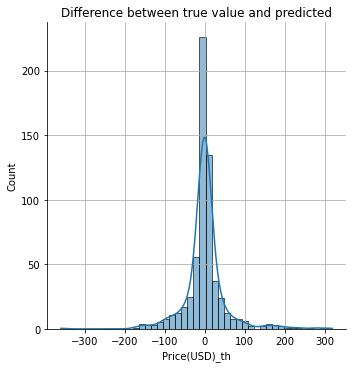

In [39]:
yy = y_test - pred_test_cbr
sns.displot(yy, bins=45,kde=True)
plt.grid()
plt.title('Difference between true value and predicted')

Text(0.5, 1.0, 'Difference between true value and predicted')

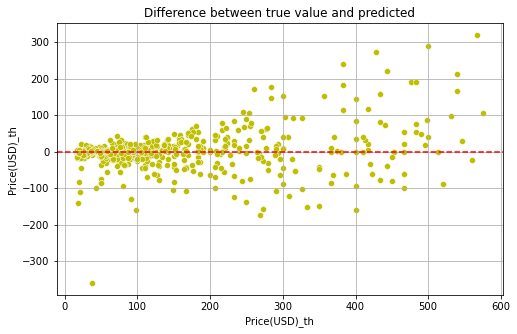

In [40]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_test,y=yy, color = 'y')
plt.axhline(y=0,color='r',ls='--')
plt.grid()
plt.title('Difference between true value and predicted')

In [41]:
res_all = np.array([['SGDRegressor', round(rmse_test_s,2)],['CatBoostRegressor', round(rmse_test_cbr,2)]])
result_all = pd.DataFrame(res_all,columns = ['Name','RMSE'])

In [42]:
result_all

,Name,RMSE
0,SGDRegressor,66.58
1,CatBoostRegressor,52.69


# Выводы
В результате исследования данных были выявлены отсутствующие и аномальные значения, преобразованы типы данных и подготовлены для обучения моделей. 
Основное влияние на стоимость жилой недвижимости из представленных данных оказывает количество комнат и площадь. 
Были рассмотрены 2 модели: стохастический градиентный спуск и градиентный бустинг. Обе модели показали не лучший результат, так как метрика RMSE составила более 50 000 долларов при медианной цене около100000. Но все-таки лучшие показатели оказались у градиентного бустинга. Его и рекомендуется использовать в дальнейшем для предсказания цены.
